In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b10','b25','b50','b75'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : [],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_e_e_n_e_0_0_e_0_0_basal_seg_data_norm_b10_b25_b50_b75_roi_t1_native_k5_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1755717, 856)
(1755717, 3)
validation
(308504, 856)
(308504, 3)
test
(223783, 856)
(223783, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 856)]             0         


 dense (Dense)               (None, 1024)              877568    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 1566979 (5.98 MB)


Trainable params: 1566979 (5.98 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/176 [..............................] - ETA: 3:25 - loss: 1.4413 - STD: 0.3039 - MAE: 0.4123

  5/176 [..............................] - ETA: 2s - loss: 1.1983 - STD: 0.1410 - MAE: 0.4341  

  9/176 [>.............................] - ETA: 2s - loss: 1.1650 - STD: 0.1391 - MAE: 0.4331

 12/176 [=>............................] - ETA: 2s - loss: 1.1436 - STD: 0.1261 - MAE: 0.4330

 15/176 [=>............................] - ETA: 2s - loss: 1.1359 - STD: 0.1207 - MAE: 0.4335

 18/176 [==>...........................] - ETA: 2s - loss: 1.1274 - STD: 0.1158 - MAE: 0.4335

 21/176 [==>...........................] - ETA: 2s - loss: 1.1197 - STD: 0.1110 - MAE: 0.4333

 24/176 [===>..........................] - ETA: 2s - loss: 1.1148 - STD: 0.1082 - MAE: 0.4333

 27/176 [===>..........................] - ETA: 2s - loss: 1.1109 - STD: 0.1051 - MAE: 0.4334

 30/176 [====>.........................] - ETA: 2s - loss: 1.1072 - STD: 0.1018 - MAE: 0.4335

 33/176 [====>.........................] - ETA: 2s - loss: 1.1043 - STD: 0.0997 - MAE: 0.4334

 36/176 [=====>........................] - ETA: 2s - loss: 1.1021 - STD: 0.0978 - MAE: 0.4335

 39/176 [=====>........................] - ETA: 2s - loss: 1.0998 - STD: 0.0956 - MAE: 0.4335

 42/176 [======>.......................] - ETA: 2s - loss: 1.0979 - STD: 0.0942 - MAE: 0.4335

 45/176 [======>.......................] - ETA: 2s - loss: 1.0961 - STD: 0.0929 - MAE: 0.4335

 47/176 [=======>......................] - ETA: 3s - loss: 1.0953 - STD: 0.0922 - MAE: 0.4334

 51/176 [=======>......................] - ETA: 3s - loss: 1.0932 - STD: 0.0907 - MAE: 0.4334

 55/176 [========>.....................] - ETA: 3s - loss: 1.0913 - STD: 0.0895 - MAE: 0.4333

 59/176 [=========>....................] - ETA: 3s - loss: 1.0896 - STD: 0.0885 - MAE: 0.4332

 63/176 [=========>....................] - ETA: 2s - loss: 1.0878 - STD: 0.0876 - MAE: 0.4330

 66/176 [==========>...................] - ETA: 2s - loss: 1.0865 - STD: 0.0871 - MAE: 0.4328

 69/176 [==========>...................] - ETA: 2s - loss: 1.0849 - STD: 0.0865 - MAE: 0.4326

 72/176 [===========>..................] - ETA: 2s - loss: 1.0830 - STD: 0.0863 - MAE: 0.4323

 75/176 [===========>..................] - ETA: 2s - loss: 1.0808 - STD: 0.0863 - MAE: 0.4318

 78/176 [============>.................] - ETA: 2s - loss: 1.0782 - STD: 0.0865 - MAE: 0.4312

 81/176 [============>.................] - ETA: 2s - loss: 1.0750 - STD: 0.0872 - MAE: 0.4304

 84/176 [=============>................] - ETA: 2s - loss: 1.0714 - STD: 0.0886 - MAE: 0.4293

 87/176 [=============>................] - ETA: 2s - loss: 1.0674 - STD: 0.0907 - MAE: 0.4280

 90/176 [==============>...............] - ETA: 2s - loss: 1.0633 - STD: 0.0932 - MAE: 0.4264

 93/176 [==============>...............] - ETA: 1s - loss: 1.0590 - STD: 0.0962 - MAE: 0.4247

 96/176 [===============>..............] - ETA: 1s - loss: 1.0548 - STD: 0.0993 - MAE: 0.4229

 99/176 [===============>..............] - ETA: 1s - loss: 1.0505 - STD: 0.1023 - MAE: 0.4211

102/176 [================>.............] - ETA: 1s - loss: 1.0462 - STD: 0.1050 - MAE: 0.4194

105/176 [================>.............] - ETA: 1s - loss: 1.0418 - STD: 0.1074 - MAE: 0.4177

108/176 [=================>............] - ETA: 1s - loss: 1.0375 - STD: 0.1101 - MAE: 0.4160

111/176 [=================>............] - ETA: 1s - loss: 1.0333 - STD: 0.1124 - MAE: 0.4144

114/176 [==================>...........] - ETA: 1s - loss: 1.0291 - STD: 0.1148 - MAE: 0.4128

117/176 [==================>...........] - ETA: 1s - loss: 1.0250 - STD: 0.1174 - MAE: 0.4110

120/176 [===================>..........] - ETA: 1s - loss: 1.0211 - STD: 0.1199 - MAE: 0.4094

123/176 [===================>..........] - ETA: 1s - loss: 1.0171 - STD: 0.1221 - MAE: 0.4078

126/176 [====================>.........] - ETA: 1s - loss: 1.0132 - STD: 0.1244 - MAE: 0.4062

129/176 [====================>.........] - ETA: 1s - loss: 1.0093 - STD: 0.1268 - MAE: 0.4046

132/176 [=====================>........] - ETA: 0s - loss: 1.0055 - STD: 0.1290 - MAE: 0.4031

135/176 [======================>.......] - ETA: 0s - loss: 1.0017 - STD: 0.1313 - MAE: 0.4015

138/176 [======================>.......] - ETA: 0s - loss: 0.9980 - STD: 0.1336 - MAE: 0.3999

141/176 [=======================>......] - ETA: 0s - loss: 0.9942 - STD: 0.1357 - MAE: 0.3984

144/176 [=======================>......] - ETA: 0s - loss: 0.9907 - STD: 0.1378 - MAE: 0.3969

147/176 [========================>.....] - ETA: 0s - loss: 0.9872 - STD: 0.1398 - MAE: 0.3955

150/176 [========================>.....] - ETA: 0s - loss: 0.9840 - STD: 0.1419 - MAE: 0.3940

153/176 [=========================>....] - ETA: 0s - loss: 0.9806 - STD: 0.1439 - MAE: 0.3926

156/176 [=========================>....] - ETA: 0s - loss: 0.9774 - STD: 0.1458 - MAE: 0.3913

159/176 [==========================>...] - ETA: 0s - loss: 0.9742 - STD: 0.1477 - MAE: 0.3899

162/176 [==========================>...] - ETA: 0s - loss: 0.9711 - STD: 0.1495 - MAE: 0.3886

165/176 [===========================>..] - ETA: 0s - loss: 0.9681 - STD: 0.1513 - MAE: 0.3874

168/176 [===========================>..] - ETA: 0s - loss: 0.9652 - STD: 0.1530 - MAE: 0.3861

171/176 [============================>.] - ETA: 0s - loss: 0.9625 - STD: 0.1547 - MAE: 0.3850

174/176 [============================>.] - ETA: 0s - loss: 0.9599 - STD: 0.1563 - MAE: 0.3838

176/176 [==============================] - 6s 28ms/step - loss: 0.9580 - STD: 0.1575 - MAE: 0.3830 - val_loss: 0.7969 - val_STD: 0.2535 - val_MAE: 0.3112


Epoch 2/10000


  1/176 [..............................] - ETA: 8s - loss: 0.7971 - STD: 0.2444 - MAE: 0.3181

  4/176 [..............................] - ETA: 3s - loss: 0.7989 - STD: 0.2499 - MAE: 0.3156

  7/176 [>.............................] - ETA: 3s - loss: 0.7987 - STD: 0.2504 - MAE: 0.3153

 10/176 [>.............................] - ETA: 2s - loss: 0.7967 - STD: 0.2514 - MAE: 0.3144

 13/176 [=>............................] - ETA: 2s - loss: 0.7955 - STD: 0.2520 - MAE: 0.3139

 16/176 [=>............................] - ETA: 2s - loss: 0.7934 - STD: 0.2526 - MAE: 0.3132

 19/176 [==>...........................] - ETA: 2s - loss: 0.7928 - STD: 0.2536 - MAE: 0.3126

 22/176 [==>...........................] - ETA: 2s - loss: 0.7917 - STD: 0.2539 - MAE: 0.3121

 25/176 [===>..........................] - ETA: 2s - loss: 0.7908 - STD: 0.2545 - MAE: 0.3116

 28/176 [===>..........................] - ETA: 2s - loss: 0.7890 - STD: 0.2548 - MAE: 0.3111

 31/176 [====>.........................] - ETA: 2s - loss: 0.7878 - STD: 0.2555 - MAE: 0.3105

 34/176 [====>.........................] - ETA: 2s - loss: 0.7873 - STD: 0.2560 - MAE: 0.3102

 37/176 [=====>........................] - ETA: 2s - loss: 0.7866 - STD: 0.2566 - MAE: 0.3097

 40/176 [=====>........................] - ETA: 2s - loss: 0.7857 - STD: 0.2569 - MAE: 0.3093

 43/176 [======>.......................] - ETA: 2s - loss: 0.7848 - STD: 0.2573 - MAE: 0.3089

 46/176 [======>.......................] - ETA: 2s - loss: 0.7841 - STD: 0.2577 - MAE: 0.3086

 49/176 [=======>......................] - ETA: 2s - loss: 0.7837 - STD: 0.2581 - MAE: 0.3083

 52/176 [=======>......................] - ETA: 2s - loss: 0.7827 - STD: 0.2587 - MAE: 0.3078

 55/176 [========>.....................] - ETA: 2s - loss: 0.7821 - STD: 0.2591 - MAE: 0.3075

 58/176 [========>.....................] - ETA: 2s - loss: 0.7812 - STD: 0.2595 - MAE: 0.3071

 61/176 [=========>....................] - ETA: 2s - loss: 0.7807 - STD: 0.2597 - MAE: 0.3069

 64/176 [=========>....................] - ETA: 2s - loss: 0.7799 - STD: 0.2600 - MAE: 0.3066

 67/176 [==========>...................] - ETA: 1s - loss: 0.7789 - STD: 0.2604 - MAE: 0.3061

 70/176 [==========>...................] - ETA: 1s - loss: 0.7785 - STD: 0.2609 - MAE: 0.3058

 73/176 [===========>..................] - ETA: 1s - loss: 0.7779 - STD: 0.2612 - MAE: 0.3055

 76/176 [===========>..................] - ETA: 1s - loss: 0.7776 - STD: 0.2613 - MAE: 0.3054

 79/176 [============>.................] - ETA: 1s - loss: 0.7773 - STD: 0.2614 - MAE: 0.3053

 82/176 [============>.................] - ETA: 1s - loss: 0.7770 - STD: 0.2617 - MAE: 0.3051

 85/176 [=============>................] - ETA: 1s - loss: 0.7764 - STD: 0.2620 - MAE: 0.3048

 88/176 [==============>...............] - ETA: 1s - loss: 0.7759 - STD: 0.2622 - MAE: 0.3046

 91/176 [==============>...............] - ETA: 1s - loss: 0.7754 - STD: 0.2625 - MAE: 0.3044

 94/176 [===============>..............] - ETA: 1s - loss: 0.7748 - STD: 0.2626 - MAE: 0.3042

 97/176 [===============>..............] - ETA: 1s - loss: 0.7743 - STD: 0.2629 - MAE: 0.3040

100/176 [================>.............] - ETA: 1s - loss: 0.7739 - STD: 0.2632 - MAE: 0.3037

103/176 [================>.............] - ETA: 1s - loss: 0.7733 - STD: 0.2634 - MAE: 0.3035

106/176 [=================>............] - ETA: 1s - loss: 0.7730 - STD: 0.2636 - MAE: 0.3034

109/176 [=================>............] - ETA: 1s - loss: 0.7726 - STD: 0.2638 - MAE: 0.3032

112/176 [==================>...........] - ETA: 1s - loss: 0.7724 - STD: 0.2639 - MAE: 0.3031

115/176 [==================>...........] - ETA: 1s - loss: 0.7720 - STD: 0.2640 - MAE: 0.3029

118/176 [===================>..........] - ETA: 1s - loss: 0.7715 - STD: 0.2642 - MAE: 0.3028

121/176 [===================>..........] - ETA: 1s - loss: 0.7711 - STD: 0.2644 - MAE: 0.3026

124/176 [====================>.........] - ETA: 0s - loss: 0.7706 - STD: 0.2646 - MAE: 0.3024

127/176 [====================>.........] - ETA: 0s - loss: 0.7701 - STD: 0.2648 - MAE: 0.3022

131/176 [=====================>........] - ETA: 0s - loss: 0.7696 - STD: 0.2650 - MAE: 0.3019

134/176 [=====================>........] - ETA: 0s - loss: 0.7691 - STD: 0.2653 - MAE: 0.3017

137/176 [======================>.......] - ETA: 0s - loss: 0.7687 - STD: 0.2655 - MAE: 0.3015

140/176 [======================>.......] - ETA: 0s - loss: 0.7684 - STD: 0.2656 - MAE: 0.3014

143/176 [=======================>......] - ETA: 0s - loss: 0.7680 - STD: 0.2657 - MAE: 0.3013

146/176 [=======================>......] - ETA: 0s - loss: 0.7675 - STD: 0.2659 - MAE: 0.3011

149/176 [========================>.....] - ETA: 0s - loss: 0.7671 - STD: 0.2660 - MAE: 0.3010

152/176 [========================>.....] - ETA: 0s - loss: 0.7668 - STD: 0.2662 - MAE: 0.3008

155/176 [=========================>....] - ETA: 0s - loss: 0.7665 - STD: 0.2664 - MAE: 0.3007

158/176 [=========================>....] - ETA: 0s - loss: 0.7662 - STD: 0.2666 - MAE: 0.3005

161/176 [==========================>...] - ETA: 0s - loss: 0.7659 - STD: 0.2668 - MAE: 0.3004

164/176 [==========================>...] - ETA: 0s - loss: 0.7656 - STD: 0.2669 - MAE: 0.3002

167/176 [===========================>..] - ETA: 0s - loss: 0.7651 - STD: 0.2670 - MAE: 0.3001

170/176 [===========================>..] - ETA: 0s - loss: 0.7648 - STD: 0.2671 - MAE: 0.3000

173/176 [============================>.] - ETA: 0s - loss: 0.7644 - STD: 0.2673 - MAE: 0.2998

176/176 [==============================] - ETA: 0s - loss: 0.7640 - STD: 0.2674 - MAE: 0.2997

176/176 [==============================] - 4s 22ms/step - loss: 0.7640 - STD: 0.2674 - MAE: 0.2997 - val_loss: 0.7547 - val_STD: 0.2879 - val_MAE: 0.2852


Epoch 3/10000


  1/176 [..............................] - ETA: 7s - loss: 0.7415 - STD: 0.2734 - MAE: 0.2917

  4/176 [..............................] - ETA: 3s - loss: 0.7396 - STD: 0.2752 - MAE: 0.2908

  7/176 [>.............................] - ETA: 3s - loss: 0.7373 - STD: 0.2763 - MAE: 0.2898

 10/176 [>.............................] - ETA: 3s - loss: 0.7372 - STD: 0.2762 - MAE: 0.2899

 13/176 [=>............................] - ETA: 3s - loss: 0.7351 - STD: 0.2765 - MAE: 0.2894

 16/176 [=>............................] - ETA: 2s - loss: 0.7360 - STD: 0.2768 - MAE: 0.2895

 19/176 [==>...........................] - ETA: 2s - loss: 0.7365 - STD: 0.2774 - MAE: 0.2893

 22/176 [==>...........................] - ETA: 2s - loss: 0.7381 - STD: 0.2778 - MAE: 0.2895

 25/176 [===>..........................] - ETA: 2s - loss: 0.7383 - STD: 0.2779 - MAE: 0.2894

 28/176 [===>..........................] - ETA: 2s - loss: 0.7386 - STD: 0.2778 - MAE: 0.2896

 31/176 [====>.........................] - ETA: 2s - loss: 0.7393 - STD: 0.2778 - MAE: 0.2897

 34/176 [====>.........................] - ETA: 2s - loss: 0.7393 - STD: 0.2780 - MAE: 0.2896

 37/176 [=====>........................] - ETA: 2s - loss: 0.7393 - STD: 0.2780 - MAE: 0.2896

 40/176 [=====>........................] - ETA: 2s - loss: 0.7393 - STD: 0.2777 - MAE: 0.2898

 43/176 [======>.......................] - ETA: 2s - loss: 0.7390 - STD: 0.2776 - MAE: 0.2898

 46/176 [======>.......................] - ETA: 2s - loss: 0.7386 - STD: 0.2775 - MAE: 0.2897

 49/176 [=======>......................] - ETA: 2s - loss: 0.7378 - STD: 0.2777 - MAE: 0.2895

 52/176 [=======>......................] - ETA: 2s - loss: 0.7373 - STD: 0.2779 - MAE: 0.2893

 55/176 [========>.....................] - ETA: 2s - loss: 0.7366 - STD: 0.2781 - MAE: 0.2891

 58/176 [========>.....................] - ETA: 2s - loss: 0.7365 - STD: 0.2781 - MAE: 0.2890

 61/176 [=========>....................] - ETA: 2s - loss: 0.7361 - STD: 0.2782 - MAE: 0.2889

 64/176 [=========>....................] - ETA: 2s - loss: 0.7357 - STD: 0.2784 - MAE: 0.2887

 67/176 [==========>...................] - ETA: 1s - loss: 0.7357 - STD: 0.2786 - MAE: 0.2886

 70/176 [==========>...................] - ETA: 1s - loss: 0.7355 - STD: 0.2787 - MAE: 0.2885

 73/176 [===========>..................] - ETA: 1s - loss: 0.7352 - STD: 0.2787 - MAE: 0.2885

 76/176 [===========>..................] - ETA: 1s - loss: 0.7349 - STD: 0.2788 - MAE: 0.2884

 79/176 [============>.................] - ETA: 1s - loss: 0.7346 - STD: 0.2789 - MAE: 0.2882

 82/176 [============>.................] - ETA: 1s - loss: 0.7343 - STD: 0.2790 - MAE: 0.2881

 85/176 [=============>................] - ETA: 1s - loss: 0.7341 - STD: 0.2791 - MAE: 0.2880

 88/176 [==============>...............] - ETA: 1s - loss: 0.7341 - STD: 0.2792 - MAE: 0.2880

 91/176 [==============>...............] - ETA: 1s - loss: 0.7341 - STD: 0.2793 - MAE: 0.2879

 94/176 [===============>..............] - ETA: 1s - loss: 0.7339 - STD: 0.2794 - MAE: 0.2878

 97/176 [===============>..............] - ETA: 1s - loss: 0.7336 - STD: 0.2795 - MAE: 0.2877

100/176 [================>.............] - ETA: 1s - loss: 0.7332 - STD: 0.2796 - MAE: 0.2876

103/176 [================>.............] - ETA: 1s - loss: 0.7330 - STD: 0.2797 - MAE: 0.2875

106/176 [=================>............] - ETA: 1s - loss: 0.7327 - STD: 0.2797 - MAE: 0.2874

109/176 [=================>............] - ETA: 1s - loss: 0.7326 - STD: 0.2797 - MAE: 0.2874

112/176 [==================>...........] - ETA: 1s - loss: 0.7324 - STD: 0.2798 - MAE: 0.2873

115/176 [==================>...........] - ETA: 1s - loss: 0.7321 - STD: 0.2798 - MAE: 0.2872

118/176 [===================>..........] - ETA: 1s - loss: 0.7319 - STD: 0.2799 - MAE: 0.2871

121/176 [===================>..........] - ETA: 0s - loss: 0.7317 - STD: 0.2800 - MAE: 0.2871

124/176 [====================>.........] - ETA: 0s - loss: 0.7316 - STD: 0.2801 - MAE: 0.2870

127/176 [====================>.........] - ETA: 0s - loss: 0.7312 - STD: 0.2802 - MAE: 0.2869

130/176 [=====================>........] - ETA: 0s - loss: 0.7308 - STD: 0.2803 - MAE: 0.2867

133/176 [=====================>........] - ETA: 0s - loss: 0.7308 - STD: 0.2804 - MAE: 0.2866

136/176 [======================>.......] - ETA: 0s - loss: 0.7305 - STD: 0.2805 - MAE: 0.2865

139/176 [======================>.......] - ETA: 0s - loss: 0.7302 - STD: 0.2805 - MAE: 0.2865

142/176 [=======================>......] - ETA: 0s - loss: 0.7299 - STD: 0.2806 - MAE: 0.2864

145/176 [=======================>......] - ETA: 0s - loss: 0.7298 - STD: 0.2807 - MAE: 0.2863

148/176 [========================>.....] - ETA: 0s - loss: 0.7295 - STD: 0.2808 - MAE: 0.2862

151/176 [========================>.....] - ETA: 0s - loss: 0.7293 - STD: 0.2808 - MAE: 0.2861

154/176 [=========================>....] - ETA: 0s - loss: 0.7291 - STD: 0.2809 - MAE: 0.2861

158/176 [=========================>....] - ETA: 0s - loss: 0.7288 - STD: 0.2810 - MAE: 0.2859

161/176 [==========================>...] - ETA: 0s - loss: 0.7288 - STD: 0.2811 - MAE: 0.2859

164/176 [==========================>...] - ETA: 0s - loss: 0.7286 - STD: 0.2811 - MAE: 0.2858

167/176 [===========================>..] - ETA: 0s - loss: 0.7284 - STD: 0.2812 - MAE: 0.2857

170/176 [===========================>..] - ETA: 0s - loss: 0.7283 - STD: 0.2813 - MAE: 0.2857

173/176 [============================>.] - ETA: 0s - loss: 0.7282 - STD: 0.2813 - MAE: 0.2856

176/176 [==============================] - ETA: 0s - loss: 0.7280 - STD: 0.2814 - MAE: 0.2855

176/176 [==============================] - 4s 21ms/step - loss: 0.7280 - STD: 0.2814 - MAE: 0.2855 - val_loss: 0.7422 - val_STD: 0.3069 - val_MAE: 0.2721


Epoch 4/10000


  1/176 [..............................] - ETA: 8s - loss: 0.7093 - STD: 0.2894 - MAE: 0.2770

  4/176 [..............................] - ETA: 3s - loss: 0.7168 - STD: 0.2877 - MAE: 0.2799

  7/176 [>.............................] - ETA: 3s - loss: 0.7176 - STD: 0.2862 - MAE: 0.2808

 10/176 [>.............................] - ETA: 3s - loss: 0.7162 - STD: 0.2861 - MAE: 0.2805

 13/176 [=>............................] - ETA: 3s - loss: 0.7158 - STD: 0.2859 - MAE: 0.2806

 16/176 [=>............................] - ETA: 2s - loss: 0.7161 - STD: 0.2865 - MAE: 0.2803

 19/176 [==>...........................] - ETA: 2s - loss: 0.7170 - STD: 0.2863 - MAE: 0.2807

 22/176 [==>...........................] - ETA: 2s - loss: 0.7172 - STD: 0.2862 - MAE: 0.2808

 25/176 [===>..........................] - ETA: 2s - loss: 0.7174 - STD: 0.2860 - MAE: 0.2809

 28/176 [===>..........................] - ETA: 2s - loss: 0.7178 - STD: 0.2858 - MAE: 0.2811

 31/176 [====>.........................] - ETA: 2s - loss: 0.7177 - STD: 0.2857 - MAE: 0.2812

 34/176 [====>.........................] - ETA: 2s - loss: 0.7175 - STD: 0.2855 - MAE: 0.2813

 37/176 [=====>........................] - ETA: 2s - loss: 0.7175 - STD: 0.2855 - MAE: 0.2813

 40/176 [=====>........................] - ETA: 2s - loss: 0.7183 - STD: 0.2855 - MAE: 0.2814

 43/176 [======>.......................] - ETA: 2s - loss: 0.7187 - STD: 0.2856 - MAE: 0.2815

 46/176 [======>.......................] - ETA: 2s - loss: 0.7197 - STD: 0.2855 - MAE: 0.2817

 49/176 [=======>......................] - ETA: 2s - loss: 0.7211 - STD: 0.2856 - MAE: 0.2820

 53/176 [========>.....................] - ETA: 2s - loss: 0.7219 - STD: 0.2854 - MAE: 0.2822

 56/176 [========>.....................] - ETA: 2s - loss: 0.7222 - STD: 0.2853 - MAE: 0.2823

 59/176 [=========>....................] - ETA: 2s - loss: 0.7220 - STD: 0.2853 - MAE: 0.2823

 62/176 [=========>....................] - ETA: 2s - loss: 0.7218 - STD: 0.2851 - MAE: 0.2824

 65/176 [==========>...................] - ETA: 1s - loss: 0.7216 - STD: 0.2851 - MAE: 0.2823

 68/176 [==========>...................] - ETA: 1s - loss: 0.7214 - STD: 0.2851 - MAE: 0.2823

 71/176 [===========>..................] - ETA: 1s - loss: 0.7211 - STD: 0.2851 - MAE: 0.2822

 74/176 [===========>..................] - ETA: 1s - loss: 0.7211 - STD: 0.2851 - MAE: 0.2823

 77/176 [============>.................] - ETA: 1s - loss: 0.7209 - STD: 0.2849 - MAE: 0.2823

 80/176 [============>.................] - ETA: 1s - loss: 0.7209 - STD: 0.2849 - MAE: 0.2823

 83/176 [=============>................] - ETA: 1s - loss: 0.7209 - STD: 0.2849 - MAE: 0.2824

 86/176 [=============>................] - ETA: 1s - loss: 0.7213 - STD: 0.2849 - MAE: 0.2824

 89/176 [==============>...............] - ETA: 1s - loss: 0.7211 - STD: 0.2848 - MAE: 0.2824

 92/176 [==============>...............] - ETA: 1s - loss: 0.7209 - STD: 0.2849 - MAE: 0.2823

 95/176 [===============>..............] - ETA: 1s - loss: 0.7206 - STD: 0.2850 - MAE: 0.2822

 98/176 [===============>..............] - ETA: 1s - loss: 0.7208 - STD: 0.2850 - MAE: 0.2822

101/176 [================>.............] - ETA: 1s - loss: 0.7208 - STD: 0.2849 - MAE: 0.2823

104/176 [================>.............] - ETA: 1s - loss: 0.7206 - STD: 0.2849 - MAE: 0.2823

107/176 [=================>............] - ETA: 1s - loss: 0.7205 - STD: 0.2849 - MAE: 0.2822

110/176 [=================>............] - ETA: 1s - loss: 0.7203 - STD: 0.2850 - MAE: 0.2821

113/176 [==================>...........] - ETA: 1s - loss: 0.7199 - STD: 0.2851 - MAE: 0.2820

116/176 [==================>...........] - ETA: 1s - loss: 0.7195 - STD: 0.2852 - MAE: 0.2819

119/176 [===================>..........] - ETA: 1s - loss: 0.7194 - STD: 0.2852 - MAE: 0.2818

122/176 [===================>..........] - ETA: 0s - loss: 0.7192 - STD: 0.2852 - MAE: 0.2818

125/176 [====================>.........] - ETA: 0s - loss: 0.7189 - STD: 0.2852 - MAE: 0.2817

128/176 [====================>.........] - ETA: 0s - loss: 0.7187 - STD: 0.2852 - MAE: 0.2817

131/176 [=====================>........] - ETA: 0s - loss: 0.7185 - STD: 0.2853 - MAE: 0.2816

134/176 [=====================>........] - ETA: 0s - loss: 0.7181 - STD: 0.2854 - MAE: 0.2815

137/176 [======================>.......] - ETA: 0s - loss: 0.7179 - STD: 0.2854 - MAE: 0.2814

140/176 [======================>.......] - ETA: 0s - loss: 0.7176 - STD: 0.2855 - MAE: 0.2813

143/176 [=======================>......] - ETA: 0s - loss: 0.7174 - STD: 0.2856 - MAE: 0.2812

146/176 [=======================>......] - ETA: 0s - loss: 0.7172 - STD: 0.2857 - MAE: 0.2811

149/176 [========================>.....] - ETA: 0s - loss: 0.7171 - STD: 0.2858 - MAE: 0.2810

151/176 [========================>.....] - ETA: 0s - loss: 0.7170 - STD: 0.2858 - MAE: 0.2810

153/176 [=========================>....] - ETA: 0s - loss: 0.7169 - STD: 0.2859 - MAE: 0.2809

156/176 [=========================>....] - ETA: 0s - loss: 0.7168 - STD: 0.2860 - MAE: 0.2808

159/176 [==========================>...] - ETA: 0s - loss: 0.7168 - STD: 0.2860 - MAE: 0.2808

161/176 [==========================>...] - ETA: 0s - loss: 0.7167 - STD: 0.2860 - MAE: 0.2808

164/176 [==========================>...] - ETA: 0s - loss: 0.7166 - STD: 0.2860 - MAE: 0.2808

167/176 [===========================>..] - ETA: 0s - loss: 0.7164 - STD: 0.2860 - MAE: 0.2808

170/176 [===========================>..] - ETA: 0s - loss: 0.7162 - STD: 0.2861 - MAE: 0.2807

173/176 [============================>.] - ETA: 0s - loss: 0.7160 - STD: 0.2861 - MAE: 0.2807

176/176 [==============================] - ETA: 0s - loss: 0.7159 - STD: 0.2861 - MAE: 0.2806

176/176 [==============================] - 4s 22ms/step - loss: 0.7159 - STD: 0.2861 - MAE: 0.2806 - val_loss: 0.7590 - val_STD: 0.3159 - val_MAE: 0.2697


Epoch 5/10000


  1/176 [..............................] - ETA: 9s - loss: 0.7089 - STD: 0.2963 - MAE: 0.2733

  4/176 [..............................] - ETA: 3s - loss: 0.7070 - STD: 0.2898 - MAE: 0.2767

  7/176 [>.............................] - ETA: 3s - loss: 0.7054 - STD: 0.2885 - MAE: 0.2773

 10/176 [>.............................] - ETA: 3s - loss: 0.7065 - STD: 0.2888 - MAE: 0.2773

 13/176 [=>............................] - ETA: 3s - loss: 0.7064 - STD: 0.2889 - MAE: 0.2772

 16/176 [=>............................] - ETA: 3s - loss: 0.7053 - STD: 0.2891 - MAE: 0.2768

 19/176 [==>...........................] - ETA: 3s - loss: 0.7053 - STD: 0.2892 - MAE: 0.2768

 22/176 [==>...........................] - ETA: 3s - loss: 0.7052 - STD: 0.2894 - MAE: 0.2766

 25/176 [===>..........................] - ETA: 3s - loss: 0.7049 - STD: 0.2893 - MAE: 0.2766

 28/176 [===>..........................] - ETA: 3s - loss: 0.7054 - STD: 0.2890 - MAE: 0.2769

 31/176 [====>.........................] - ETA: 2s - loss: 0.7048 - STD: 0.2891 - MAE: 0.2767

 34/176 [====>.........................] - ETA: 2s - loss: 0.7042 - STD: 0.2894 - MAE: 0.2764

 37/176 [=====>........................] - ETA: 2s - loss: 0.7048 - STD: 0.2895 - MAE: 0.2764

 40/176 [=====>........................] - ETA: 2s - loss: 0.7050 - STD: 0.2893 - MAE: 0.2766

 43/176 [======>.......................] - ETA: 2s - loss: 0.7053 - STD: 0.2891 - MAE: 0.2768

 46/176 [======>.......................] - ETA: 2s - loss: 0.7048 - STD: 0.2891 - MAE: 0.2767

 49/176 [=======>......................] - ETA: 2s - loss: 0.7047 - STD: 0.2893 - MAE: 0.2766

 52/176 [=======>......................] - ETA: 2s - loss: 0.7048 - STD: 0.2894 - MAE: 0.2766

 55/176 [========>.....................] - ETA: 2s - loss: 0.7043 - STD: 0.2894 - MAE: 0.2765

 58/176 [========>.....................] - ETA: 2s - loss: 0.7041 - STD: 0.2893 - MAE: 0.2765

 61/176 [=========>....................] - ETA: 2s - loss: 0.7039 - STD: 0.2894 - MAE: 0.2764

 64/176 [=========>....................] - ETA: 2s - loss: 0.7037 - STD: 0.2895 - MAE: 0.2763

 67/176 [==========>...................] - ETA: 2s - loss: 0.7040 - STD: 0.2895 - MAE: 0.2764

 70/176 [==========>...................] - ETA: 2s - loss: 0.7039 - STD: 0.2895 - MAE: 0.2763

 73/176 [===========>..................] - ETA: 2s - loss: 0.7042 - STD: 0.2895 - MAE: 0.2764

 76/176 [===========>..................] - ETA: 2s - loss: 0.7045 - STD: 0.2896 - MAE: 0.2764

 79/176 [============>.................] - ETA: 2s - loss: 0.7048 - STD: 0.2896 - MAE: 0.2764

 82/176 [============>.................] - ETA: 1s - loss: 0.7045 - STD: 0.2897 - MAE: 0.2764

 85/176 [=============>................] - ETA: 1s - loss: 0.7044 - STD: 0.2897 - MAE: 0.2763

 88/176 [==============>...............] - ETA: 1s - loss: 0.7042 - STD: 0.2897 - MAE: 0.2763

 91/176 [==============>...............] - ETA: 1s - loss: 0.7040 - STD: 0.2897 - MAE: 0.2762

 94/176 [===============>..............] - ETA: 1s - loss: 0.7040 - STD: 0.2897 - MAE: 0.2762

 97/176 [===============>..............] - ETA: 1s - loss: 0.7040 - STD: 0.2897 - MAE: 0.2762

100/176 [================>.............] - ETA: 1s - loss: 0.7040 - STD: 0.2897 - MAE: 0.2762

103/176 [================>.............] - ETA: 1s - loss: 0.7041 - STD: 0.2897 - MAE: 0.2762

106/176 [=================>............] - ETA: 1s - loss: 0.7041 - STD: 0.2897 - MAE: 0.2762

109/176 [=================>............] - ETA: 1s - loss: 0.7042 - STD: 0.2897 - MAE: 0.2762

112/176 [==================>...........] - ETA: 1s - loss: 0.7042 - STD: 0.2898 - MAE: 0.2762

115/176 [==================>...........] - ETA: 1s - loss: 0.7041 - STD: 0.2897 - MAE: 0.2762

118/176 [===================>..........] - ETA: 1s - loss: 0.7041 - STD: 0.2897 - MAE: 0.2763

121/176 [===================>..........] - ETA: 1s - loss: 0.7043 - STD: 0.2897 - MAE: 0.2763

124/176 [====================>.........] - ETA: 1s - loss: 0.7047 - STD: 0.2898 - MAE: 0.2763

127/176 [====================>.........] - ETA: 0s - loss: 0.7051 - STD: 0.2899 - MAE: 0.2763

131/176 [=====================>........] - ETA: 0s - loss: 0.7053 - STD: 0.2898 - MAE: 0.2764

134/176 [=====================>........] - ETA: 0s - loss: 0.7052 - STD: 0.2898 - MAE: 0.2764

137/176 [======================>.......] - ETA: 0s - loss: 0.7051 - STD: 0.2898 - MAE: 0.2763

140/176 [======================>.......] - ETA: 0s - loss: 0.7050 - STD: 0.2898 - MAE: 0.2764

143/176 [=======================>......] - ETA: 0s - loss: 0.7049 - STD: 0.2897 - MAE: 0.2764

146/176 [=======================>......] - ETA: 0s - loss: 0.7048 - STD: 0.2897 - MAE: 0.2764

149/176 [========================>.....] - ETA: 0s - loss: 0.7048 - STD: 0.2897 - MAE: 0.2764

152/176 [========================>.....] - ETA: 0s - loss: 0.7046 - STD: 0.2896 - MAE: 0.2764

155/176 [=========================>....] - ETA: 0s - loss: 0.7045 - STD: 0.2897 - MAE: 0.2763

158/176 [=========================>....] - ETA: 0s - loss: 0.7044 - STD: 0.2897 - MAE: 0.2763

161/176 [==========================>...] - ETA: 0s - loss: 0.7044 - STD: 0.2897 - MAE: 0.2763

164/176 [==========================>...] - ETA: 0s - loss: 0.7042 - STD: 0.2898 - MAE: 0.2762

167/176 [===========================>..] - ETA: 0s - loss: 0.7041 - STD: 0.2898 - MAE: 0.2762

170/176 [===========================>..] - ETA: 0s - loss: 0.7040 - STD: 0.2899 - MAE: 0.2761

173/176 [============================>.] - ETA: 0s - loss: 0.7039 - STD: 0.2899 - MAE: 0.2761

176/176 [==============================] - ETA: 0s - loss: 0.7038 - STD: 0.2899 - MAE: 0.2761

176/176 [==============================] - 4s 23ms/step - loss: 0.7038 - STD: 0.2899 - MAE: 0.2761 - val_loss: 0.7230 - val_STD: 0.3084 - val_MAE: 0.2677


Epoch 6/10000


  1/176 [..............................] - ETA: 7s - loss: 0.6978 - STD: 0.2913 - MAE: 0.2744

  4/176 [..............................] - ETA: 3s - loss: 0.6975 - STD: 0.2923 - MAE: 0.2733

  7/176 [>.............................] - ETA: 3s - loss: 0.6964 - STD: 0.2923 - MAE: 0.2733

 10/176 [>.............................] - ETA: 3s - loss: 0.6964 - STD: 0.2911 - MAE: 0.2739

 13/176 [=>............................] - ETA: 3s - loss: 0.6964 - STD: 0.2912 - MAE: 0.2738

 16/176 [=>............................] - ETA: 2s - loss: 0.6962 - STD: 0.2917 - MAE: 0.2735

 19/176 [==>...........................] - ETA: 2s - loss: 0.6969 - STD: 0.2920 - MAE: 0.2734

 22/176 [==>...........................] - ETA: 2s - loss: 0.6967 - STD: 0.2922 - MAE: 0.2733

 25/176 [===>..........................] - ETA: 2s - loss: 0.6975 - STD: 0.2922 - MAE: 0.2735

 28/176 [===>..........................] - ETA: 2s - loss: 0.6990 - STD: 0.2921 - MAE: 0.2738

 31/176 [====>.........................] - ETA: 2s - loss: 0.6997 - STD: 0.2920 - MAE: 0.2740

 34/176 [====>.........................] - ETA: 2s - loss: 0.7003 - STD: 0.2920 - MAE: 0.2741

 37/176 [=====>........................] - ETA: 2s - loss: 0.7009 - STD: 0.2921 - MAE: 0.2741

 40/176 [=====>........................] - ETA: 2s - loss: 0.7008 - STD: 0.2919 - MAE: 0.2742

 43/176 [======>.......................] - ETA: 2s - loss: 0.7006 - STD: 0.2919 - MAE: 0.2742

 46/176 [======>.......................] - ETA: 2s - loss: 0.7003 - STD: 0.2919 - MAE: 0.2741

 49/176 [=======>......................] - ETA: 2s - loss: 0.7001 - STD: 0.2919 - MAE: 0.2741

 52/176 [=======>......................] - ETA: 2s - loss: 0.6995 - STD: 0.2916 - MAE: 0.2742

 55/176 [========>.....................] - ETA: 2s - loss: 0.6994 - STD: 0.2916 - MAE: 0.2741

 58/176 [========>.....................] - ETA: 2s - loss: 0.6991 - STD: 0.2916 - MAE: 0.2740

 61/176 [=========>....................] - ETA: 2s - loss: 0.6985 - STD: 0.2915 - MAE: 0.2740

 64/176 [=========>....................] - ETA: 2s - loss: 0.6983 - STD: 0.2915 - MAE: 0.2739

 67/176 [==========>...................] - ETA: 2s - loss: 0.6982 - STD: 0.2915 - MAE: 0.2739

 70/176 [==========>...................] - ETA: 2s - loss: 0.6981 - STD: 0.2915 - MAE: 0.2739

 73/176 [===========>..................] - ETA: 2s - loss: 0.6980 - STD: 0.2916 - MAE: 0.2738

 76/176 [===========>..................] - ETA: 1s - loss: 0.6982 - STD: 0.2916 - MAE: 0.2739

 79/176 [============>.................] - ETA: 1s - loss: 0.6981 - STD: 0.2916 - MAE: 0.2739

 82/176 [============>.................] - ETA: 1s - loss: 0.6982 - STD: 0.2916 - MAE: 0.2739

 85/176 [=============>................] - ETA: 1s - loss: 0.6979 - STD: 0.2917 - MAE: 0.2738

 88/176 [==============>...............] - ETA: 1s - loss: 0.6980 - STD: 0.2918 - MAE: 0.2738

 91/176 [==============>...............] - ETA: 1s - loss: 0.6983 - STD: 0.2918 - MAE: 0.2738

 94/176 [===============>..............] - ETA: 1s - loss: 0.6982 - STD: 0.2917 - MAE: 0.2739

 97/176 [===============>..............] - ETA: 1s - loss: 0.6979 - STD: 0.2917 - MAE: 0.2738

100/176 [================>.............] - ETA: 1s - loss: 0.6979 - STD: 0.2919 - MAE: 0.2737

103/176 [================>.............] - ETA: 1s - loss: 0.6978 - STD: 0.2919 - MAE: 0.2737

106/176 [=================>............] - ETA: 1s - loss: 0.6977 - STD: 0.2918 - MAE: 0.2737

109/176 [=================>............] - ETA: 1s - loss: 0.6975 - STD: 0.2918 - MAE: 0.2737

112/176 [==================>...........] - ETA: 1s - loss: 0.6971 - STD: 0.2919 - MAE: 0.2735

115/176 [==================>...........] - ETA: 1s - loss: 0.6971 - STD: 0.2920 - MAE: 0.2735

118/176 [===================>..........] - ETA: 1s - loss: 0.6972 - STD: 0.2919 - MAE: 0.2735

121/176 [===================>..........] - ETA: 1s - loss: 0.6970 - STD: 0.2919 - MAE: 0.2735

124/176 [====================>.........] - ETA: 1s - loss: 0.6969 - STD: 0.2920 - MAE: 0.2734

127/176 [====================>.........] - ETA: 0s - loss: 0.6966 - STD: 0.2920 - MAE: 0.2733

130/176 [=====================>........] - ETA: 0s - loss: 0.6965 - STD: 0.2921 - MAE: 0.2733

133/176 [=====================>........] - ETA: 0s - loss: 0.6966 - STD: 0.2921 - MAE: 0.2733

136/176 [======================>.......] - ETA: 0s - loss: 0.6965 - STD: 0.2921 - MAE: 0.2733

139/176 [======================>.......] - ETA: 0s - loss: 0.6963 - STD: 0.2921 - MAE: 0.2732

142/176 [=======================>......] - ETA: 0s - loss: 0.6961 - STD: 0.2921 - MAE: 0.2732

145/176 [=======================>......] - ETA: 0s - loss: 0.6960 - STD: 0.2921 - MAE: 0.2731

148/176 [========================>.....] - ETA: 0s - loss: 0.6958 - STD: 0.2922 - MAE: 0.2730

151/176 [========================>.....] - ETA: 0s - loss: 0.6956 - STD: 0.2922 - MAE: 0.2730

154/176 [=========================>....] - ETA: 0s - loss: 0.6955 - STD: 0.2923 - MAE: 0.2729

157/176 [=========================>....] - ETA: 0s - loss: 0.6953 - STD: 0.2923 - MAE: 0.2729

160/176 [==========================>...] - ETA: 0s - loss: 0.6952 - STD: 0.2924 - MAE: 0.2728

163/176 [==========================>...] - ETA: 0s - loss: 0.6952 - STD: 0.2923 - MAE: 0.2729

166/176 [===========================>..] - ETA: 0s - loss: 0.6952 - STD: 0.2923 - MAE: 0.2729

169/176 [===========================>..] - ETA: 0s - loss: 0.6951 - STD: 0.2924 - MAE: 0.2728

172/176 [============================>.] - ETA: 0s - loss: 0.6949 - STD: 0.2925 - MAE: 0.2727

175/176 [============================>.] - ETA: 0s - loss: 0.6948 - STD: 0.2925 - MAE: 0.2727

176/176 [==============================] - 4s 24ms/step - loss: 0.6947 - STD: 0.2925 - MAE: 0.2727 - val_loss: 0.7073 - val_STD: 0.3065 - val_MAE: 0.2659


Epoch 7/10000


  1/176 [..............................] - ETA: 9s - loss: 0.6773 - STD: 0.2924 - MAE: 0.2690

  4/176 [..............................] - ETA: 3s - loss: 0.6870 - STD: 0.2948 - MAE: 0.2699

  7/176 [>.............................] - ETA: 3s - loss: 0.6899 - STD: 0.2947 - MAE: 0.2705

 10/176 [>.............................] - ETA: 3s - loss: 0.6884 - STD: 0.2941 - MAE: 0.2705

 13/176 [=>............................] - ETA: 3s - loss: 0.6874 - STD: 0.2946 - MAE: 0.2699

 16/176 [=>............................] - ETA: 3s - loss: 0.6876 - STD: 0.2951 - MAE: 0.2696

 19/176 [==>...........................] - ETA: 3s - loss: 0.6879 - STD: 0.2950 - MAE: 0.2698

 22/176 [==>...........................] - ETA: 3s - loss: 0.6881 - STD: 0.2944 - MAE: 0.2702

 25/176 [===>..........................] - ETA: 3s - loss: 0.6874 - STD: 0.2945 - MAE: 0.2700

 28/176 [===>..........................] - ETA: 3s - loss: 0.6875 - STD: 0.2946 - MAE: 0.2700

 31/176 [====>.........................] - ETA: 2s - loss: 0.6872 - STD: 0.2945 - MAE: 0.2699

 34/176 [====>.........................] - ETA: 2s - loss: 0.6870 - STD: 0.2946 - MAE: 0.2698

 37/176 [=====>........................] - ETA: 2s - loss: 0.6883 - STD: 0.2947 - MAE: 0.2700

 40/176 [=====>........................] - ETA: 2s - loss: 0.6882 - STD: 0.2948 - MAE: 0.2699

 43/176 [======>.......................] - ETA: 2s - loss: 0.6894 - STD: 0.2950 - MAE: 0.2701

 46/176 [======>.......................] - ETA: 2s - loss: 0.6892 - STD: 0.2950 - MAE: 0.2700

 49/176 [=======>......................] - ETA: 2s - loss: 0.6897 - STD: 0.2948 - MAE: 0.2702

 52/176 [=======>......................] - ETA: 2s - loss: 0.6899 - STD: 0.2947 - MAE: 0.2704

 55/176 [========>.....................] - ETA: 2s - loss: 0.6898 - STD: 0.2948 - MAE: 0.2703

 58/176 [========>.....................] - ETA: 2s - loss: 0.6896 - STD: 0.2946 - MAE: 0.2704

 61/176 [=========>....................] - ETA: 2s - loss: 0.6893 - STD: 0.2944 - MAE: 0.2704

 64/176 [=========>....................] - ETA: 2s - loss: 0.6893 - STD: 0.2945 - MAE: 0.2704

 67/176 [==========>...................] - ETA: 2s - loss: 0.6892 - STD: 0.2944 - MAE: 0.2704

 70/176 [==========>...................] - ETA: 2s - loss: 0.6889 - STD: 0.2943 - MAE: 0.2703

 73/176 [===========>..................] - ETA: 2s - loss: 0.6884 - STD: 0.2945 - MAE: 0.2702

 76/176 [===========>..................] - ETA: 2s - loss: 0.6885 - STD: 0.2945 - MAE: 0.2702

 79/176 [============>.................] - ETA: 1s - loss: 0.6880 - STD: 0.2944 - MAE: 0.2702

 81/176 [============>.................] - ETA: 1s - loss: 0.6881 - STD: 0.2945 - MAE: 0.2701

 84/176 [=============>................] - ETA: 1s - loss: 0.6881 - STD: 0.2947 - MAE: 0.2700

 87/176 [=============>................] - ETA: 1s - loss: 0.6882 - STD: 0.2946 - MAE: 0.2701

 90/176 [==============>...............] - ETA: 1s - loss: 0.6891 - STD: 0.2946 - MAE: 0.2702

 93/176 [==============>...............] - ETA: 1s - loss: 0.6892 - STD: 0.2948 - MAE: 0.2701

 96/176 [===============>..............] - ETA: 1s - loss: 0.6894 - STD: 0.2949 - MAE: 0.2701

 99/176 [===============>..............] - ETA: 1s - loss: 0.6895 - STD: 0.2948 - MAE: 0.2702

102/176 [================>.............] - ETA: 1s - loss: 0.6898 - STD: 0.2948 - MAE: 0.2703

105/176 [================>.............] - ETA: 1s - loss: 0.6905 - STD: 0.2949 - MAE: 0.2704

108/176 [=================>............] - ETA: 1s - loss: 0.6909 - STD: 0.2949 - MAE: 0.2705

111/176 [=================>............] - ETA: 1s - loss: 0.6912 - STD: 0.2946 - MAE: 0.2707

114/176 [==================>...........] - ETA: 1s - loss: 0.6918 - STD: 0.2944 - MAE: 0.2709

117/176 [==================>...........] - ETA: 1s - loss: 0.6919 - STD: 0.2943 - MAE: 0.2710

120/176 [===================>..........] - ETA: 1s - loss: 0.6920 - STD: 0.2943 - MAE: 0.2710

123/176 [===================>..........] - ETA: 1s - loss: 0.6921 - STD: 0.2943 - MAE: 0.2711

126/176 [====================>.........] - ETA: 1s - loss: 0.6923 - STD: 0.2942 - MAE: 0.2712

130/176 [=====================>........] - ETA: 0s - loss: 0.6923 - STD: 0.2941 - MAE: 0.2712

133/176 [=====================>........] - ETA: 0s - loss: 0.6920 - STD: 0.2941 - MAE: 0.2712

136/176 [======================>.......] - ETA: 0s - loss: 0.6918 - STD: 0.2940 - MAE: 0.2712

139/176 [======================>.......] - ETA: 0s - loss: 0.6917 - STD: 0.2939 - MAE: 0.2713

142/176 [=======================>......] - ETA: 0s - loss: 0.6916 - STD: 0.2939 - MAE: 0.2712

145/176 [=======================>......] - ETA: 0s - loss: 0.6915 - STD: 0.2939 - MAE: 0.2712

148/176 [========================>.....] - ETA: 0s - loss: 0.6913 - STD: 0.2939 - MAE: 0.2712

151/176 [========================>.....] - ETA: 0s - loss: 0.6911 - STD: 0.2940 - MAE: 0.2711

154/176 [=========================>....] - ETA: 0s - loss: 0.6910 - STD: 0.2940 - MAE: 0.2710

157/176 [=========================>....] - ETA: 0s - loss: 0.6909 - STD: 0.2940 - MAE: 0.2710

160/176 [==========================>...] - ETA: 0s - loss: 0.6908 - STD: 0.2941 - MAE: 0.2709

163/176 [==========================>...] - ETA: 0s - loss: 0.6908 - STD: 0.2942 - MAE: 0.2709

166/176 [===========================>..] - ETA: 0s - loss: 0.6909 - STD: 0.2943 - MAE: 0.2708

169/176 [===========================>..] - ETA: 0s - loss: 0.6911 - STD: 0.2943 - MAE: 0.2708

172/176 [============================>.] - ETA: 0s - loss: 0.6912 - STD: 0.2944 - MAE: 0.2708

175/176 [============================>.] - ETA: 0s - loss: 0.6913 - STD: 0.2945 - MAE: 0.2708

176/176 [==============================] - 4s 24ms/step - loss: 0.6913 - STD: 0.2945 - MAE: 0.2708 - val_loss: 0.7134 - val_STD: 0.3054 - val_MAE: 0.2668


Epoch 8/10000


  1/176 [..............................] - ETA: 9s - loss: 0.6807 - STD: 0.2918 - MAE: 0.2703

  4/176 [..............................] - ETA: 3s - loss: 0.6902 - STD: 0.2927 - MAE: 0.2715

  7/176 [>.............................] - ETA: 3s - loss: 0.6907 - STD: 0.2932 - MAE: 0.2714

 10/176 [>.............................] - ETA: 3s - loss: 0.6892 - STD: 0.2936 - MAE: 0.2709

 13/176 [=>............................] - ETA: 3s - loss: 0.6872 - STD: 0.2932 - MAE: 0.2707

 16/176 [=>............................] - ETA: 3s - loss: 0.6857 - STD: 0.2930 - MAE: 0.2706

 19/176 [==>...........................] - ETA: 3s - loss: 0.6846 - STD: 0.2930 - MAE: 0.2704

 22/176 [==>...........................] - ETA: 3s - loss: 0.6837 - STD: 0.2930 - MAE: 0.2701

 25/176 [===>..........................] - ETA: 3s - loss: 0.6837 - STD: 0.2933 - MAE: 0.2700

 28/176 [===>..........................] - ETA: 3s - loss: 0.6835 - STD: 0.2936 - MAE: 0.2697

 31/176 [====>.........................] - ETA: 3s - loss: 0.6837 - STD: 0.2934 - MAE: 0.2698

 34/176 [====>.........................] - ETA: 2s - loss: 0.6845 - STD: 0.2939 - MAE: 0.2697

 37/176 [=====>........................] - ETA: 2s - loss: 0.6850 - STD: 0.2942 - MAE: 0.2696

 40/176 [=====>........................] - ETA: 2s - loss: 0.6851 - STD: 0.2940 - MAE: 0.2698

 43/176 [======>.......................] - ETA: 2s - loss: 0.6850 - STD: 0.2943 - MAE: 0.2696

 46/176 [======>.......................] - ETA: 2s - loss: 0.6855 - STD: 0.2947 - MAE: 0.2695

 49/176 [=======>......................] - ETA: 2s - loss: 0.6856 - STD: 0.2946 - MAE: 0.2696

 52/176 [=======>......................] - ETA: 2s - loss: 0.6858 - STD: 0.2946 - MAE: 0.2696

 55/176 [========>.....................] - ETA: 2s - loss: 0.6858 - STD: 0.2948 - MAE: 0.2695

 58/176 [========>.....................] - ETA: 2s - loss: 0.6858 - STD: 0.2948 - MAE: 0.2695

 61/176 [=========>....................] - ETA: 2s - loss: 0.6856 - STD: 0.2948 - MAE: 0.2695

 64/176 [=========>....................] - ETA: 2s - loss: 0.6855 - STD: 0.2948 - MAE: 0.2694

 67/176 [==========>...................] - ETA: 2s - loss: 0.6851 - STD: 0.2948 - MAE: 0.2693

 70/176 [==========>...................] - ETA: 2s - loss: 0.6849 - STD: 0.2948 - MAE: 0.2693

 73/176 [===========>..................] - ETA: 2s - loss: 0.6847 - STD: 0.2948 - MAE: 0.2693

 76/176 [===========>..................] - ETA: 2s - loss: 0.6842 - STD: 0.2948 - MAE: 0.2692

 79/176 [============>.................] - ETA: 1s - loss: 0.6839 - STD: 0.2950 - MAE: 0.2690

 82/176 [============>.................] - ETA: 1s - loss: 0.6839 - STD: 0.2951 - MAE: 0.2689

 85/176 [=============>................] - ETA: 1s - loss: 0.6837 - STD: 0.2952 - MAE: 0.2689

 88/176 [==============>...............] - ETA: 1s - loss: 0.6838 - STD: 0.2952 - MAE: 0.2688

 92/176 [==============>...............] - ETA: 1s - loss: 0.6835 - STD: 0.2953 - MAE: 0.2687

 95/176 [===============>..............] - ETA: 1s - loss: 0.6834 - STD: 0.2954 - MAE: 0.2686

 98/176 [===============>..............] - ETA: 1s - loss: 0.6832 - STD: 0.2954 - MAE: 0.2686

101/176 [================>.............] - ETA: 1s - loss: 0.6831 - STD: 0.2955 - MAE: 0.2686

104/176 [================>.............] - ETA: 1s - loss: 0.6832 - STD: 0.2955 - MAE: 0.2685

107/176 [=================>............] - ETA: 1s - loss: 0.6829 - STD: 0.2956 - MAE: 0.2684

110/176 [=================>............] - ETA: 1s - loss: 0.6827 - STD: 0.2957 - MAE: 0.2683

113/176 [==================>...........] - ETA: 1s - loss: 0.6827 - STD: 0.2956 - MAE: 0.2684

116/176 [==================>...........] - ETA: 1s - loss: 0.6825 - STD: 0.2956 - MAE: 0.2684

119/176 [===================>..........] - ETA: 1s - loss: 0.6822 - STD: 0.2958 - MAE: 0.2682

122/176 [===================>..........] - ETA: 1s - loss: 0.6820 - STD: 0.2958 - MAE: 0.2681

125/176 [====================>.........] - ETA: 1s - loss: 0.6818 - STD: 0.2959 - MAE: 0.2680

128/176 [====================>.........] - ETA: 0s - loss: 0.6819 - STD: 0.2960 - MAE: 0.2680

131/176 [=====================>........] - ETA: 0s - loss: 0.6817 - STD: 0.2960 - MAE: 0.2680

134/176 [=====================>........] - ETA: 0s - loss: 0.6817 - STD: 0.2960 - MAE: 0.2679

137/176 [======================>.......] - ETA: 0s - loss: 0.6817 - STD: 0.2961 - MAE: 0.2679

140/176 [======================>.......] - ETA: 0s - loss: 0.6815 - STD: 0.2961 - MAE: 0.2679

143/176 [=======================>......] - ETA: 0s - loss: 0.6814 - STD: 0.2962 - MAE: 0.2678

146/176 [=======================>......] - ETA: 0s - loss: 0.6813 - STD: 0.2962 - MAE: 0.2677

149/176 [========================>.....] - ETA: 0s - loss: 0.6813 - STD: 0.2962 - MAE: 0.2677

152/176 [========================>.....] - ETA: 0s - loss: 0.6814 - STD: 0.2963 - MAE: 0.2677

155/176 [=========================>....] - ETA: 0s - loss: 0.6813 - STD: 0.2963 - MAE: 0.2677

158/176 [=========================>....] - ETA: 0s - loss: 0.6811 - STD: 0.2963 - MAE: 0.2676

161/176 [==========================>...] - ETA: 0s - loss: 0.6809 - STD: 0.2964 - MAE: 0.2675

164/176 [==========================>...] - ETA: 0s - loss: 0.6808 - STD: 0.2964 - MAE: 0.2675

167/176 [===========================>..] - ETA: 0s - loss: 0.6808 - STD: 0.2964 - MAE: 0.2675

170/176 [===========================>..] - ETA: 0s - loss: 0.6807 - STD: 0.2964 - MAE: 0.2674

173/176 [============================>.] - ETA: 0s - loss: 0.6806 - STD: 0.2965 - MAE: 0.2674

176/176 [==============================] - ETA: 0s - loss: 0.6805 - STD: 0.2965 - MAE: 0.2674

176/176 [==============================] - 4s 24ms/step - loss: 0.6805 - STD: 0.2965 - MAE: 0.2674 - val_loss: 0.7133 - val_STD: 0.3162 - val_MAE: 0.2611


Epoch 9/10000


  1/176 [..............................] - ETA: 7s - loss: 0.6834 - STD: 0.3021 - MAE: 0.2645

  4/176 [..............................] - ETA: 3s - loss: 0.6747 - STD: 0.3018 - MAE: 0.2628

  7/176 [>.............................] - ETA: 3s - loss: 0.6740 - STD: 0.3002 - MAE: 0.2637

 10/176 [>.............................] - ETA: 3s - loss: 0.6734 - STD: 0.2997 - MAE: 0.2638

 13/176 [=>............................] - ETA: 3s - loss: 0.6734 - STD: 0.2993 - MAE: 0.2641

 16/176 [=>............................] - ETA: 3s - loss: 0.6709 - STD: 0.2994 - MAE: 0.2635

 19/176 [==>...........................] - ETA: 3s - loss: 0.6716 - STD: 0.2997 - MAE: 0.2635

 22/176 [==>...........................] - ETA: 3s - loss: 0.6725 - STD: 0.2993 - MAE: 0.2640

 25/176 [===>..........................] - ETA: 3s - loss: 0.6721 - STD: 0.2996 - MAE: 0.2637

 28/176 [===>..........................] - ETA: 3s - loss: 0.6716 - STD: 0.3000 - MAE: 0.2634

 31/176 [====>.........................] - ETA: 3s - loss: 0.6726 - STD: 0.2996 - MAE: 0.2639

 34/176 [====>.........................] - ETA: 2s - loss: 0.6728 - STD: 0.2997 - MAE: 0.2639

 37/176 [=====>........................] - ETA: 2s - loss: 0.6739 - STD: 0.2996 - MAE: 0.2642

 40/176 [=====>........................] - ETA: 2s - loss: 0.6744 - STD: 0.2995 - MAE: 0.2644

 43/176 [======>.......................] - ETA: 2s - loss: 0.6747 - STD: 0.2995 - MAE: 0.2644

 46/176 [======>.......................] - ETA: 2s - loss: 0.6751 - STD: 0.2994 - MAE: 0.2645

 49/176 [=======>......................] - ETA: 2s - loss: 0.6751 - STD: 0.2995 - MAE: 0.2644

 52/176 [=======>......................] - ETA: 2s - loss: 0.6748 - STD: 0.2994 - MAE: 0.2645

 55/176 [========>.....................] - ETA: 2s - loss: 0.6747 - STD: 0.2994 - MAE: 0.2644

 59/176 [=========>....................] - ETA: 2s - loss: 0.6750 - STD: 0.2993 - MAE: 0.2646

 62/176 [=========>....................] - ETA: 2s - loss: 0.6748 - STD: 0.2993 - MAE: 0.2645

 65/176 [==========>...................] - ETA: 2s - loss: 0.6746 - STD: 0.2992 - MAE: 0.2645

 68/176 [==========>...................] - ETA: 2s - loss: 0.6748 - STD: 0.2992 - MAE: 0.2645

 71/176 [===========>..................] - ETA: 2s - loss: 0.6748 - STD: 0.2991 - MAE: 0.2646

 74/176 [===========>..................] - ETA: 2s - loss: 0.6746 - STD: 0.2989 - MAE: 0.2647

 77/176 [============>.................] - ETA: 1s - loss: 0.6746 - STD: 0.2990 - MAE: 0.2646

 80/176 [============>.................] - ETA: 1s - loss: 0.6744 - STD: 0.2989 - MAE: 0.2647

 83/176 [=============>................] - ETA: 1s - loss: 0.6741 - STD: 0.2989 - MAE: 0.2646

 86/176 [=============>................] - ETA: 1s - loss: 0.6737 - STD: 0.2990 - MAE: 0.2644

 89/176 [==============>...............] - ETA: 1s - loss: 0.6734 - STD: 0.2990 - MAE: 0.2644

 92/176 [==============>...............] - ETA: 1s - loss: 0.6734 - STD: 0.2991 - MAE: 0.2643

 95/176 [===============>..............] - ETA: 1s - loss: 0.6738 - STD: 0.2992 - MAE: 0.2644

 98/176 [===============>..............] - ETA: 1s - loss: 0.6740 - STD: 0.2993 - MAE: 0.2644

101/176 [================>.............] - ETA: 1s - loss: 0.6740 - STD: 0.2993 - MAE: 0.2643

104/176 [================>.............] - ETA: 1s - loss: 0.6738 - STD: 0.2993 - MAE: 0.2643

107/176 [=================>............] - ETA: 1s - loss: 0.6741 - STD: 0.2993 - MAE: 0.2643

110/176 [=================>............] - ETA: 1s - loss: 0.6743 - STD: 0.2992 - MAE: 0.2645

113/176 [==================>...........] - ETA: 1s - loss: 0.6746 - STD: 0.2994 - MAE: 0.2644

116/176 [==================>...........] - ETA: 1s - loss: 0.6749 - STD: 0.2993 - MAE: 0.2645

119/176 [===================>..........] - ETA: 1s - loss: 0.6758 - STD: 0.2995 - MAE: 0.2646

122/176 [===================>..........] - ETA: 1s - loss: 0.6766 - STD: 0.2994 - MAE: 0.2648

125/176 [====================>.........] - ETA: 1s - loss: 0.6768 - STD: 0.2993 - MAE: 0.2649

128/176 [====================>.........] - ETA: 0s - loss: 0.6768 - STD: 0.2991 - MAE: 0.2650

131/176 [=====================>........] - ETA: 0s - loss: 0.6767 - STD: 0.2989 - MAE: 0.2651

134/176 [=====================>........] - ETA: 0s - loss: 0.6767 - STD: 0.2989 - MAE: 0.2651

137/176 [======================>.......] - ETA: 0s - loss: 0.6768 - STD: 0.2988 - MAE: 0.2652

140/176 [======================>.......] - ETA: 0s - loss: 0.6768 - STD: 0.2987 - MAE: 0.2653

143/176 [=======================>......] - ETA: 0s - loss: 0.6765 - STD: 0.2987 - MAE: 0.2652

146/176 [=======================>......] - ETA: 0s - loss: 0.6763 - STD: 0.2987 - MAE: 0.2652

149/176 [========================>.....] - ETA: 0s - loss: 0.6762 - STD: 0.2987 - MAE: 0.2651

152/176 [========================>.....] - ETA: 0s - loss: 0.6760 - STD: 0.2987 - MAE: 0.2651

155/176 [=========================>....] - ETA: 0s - loss: 0.6760 - STD: 0.2987 - MAE: 0.2651

158/176 [=========================>....] - ETA: 0s - loss: 0.6759 - STD: 0.2988 - MAE: 0.2650

161/176 [==========================>...] - ETA: 0s - loss: 0.6758 - STD: 0.2988 - MAE: 0.2650

164/176 [==========================>...] - ETA: 0s - loss: 0.6759 - STD: 0.2988 - MAE: 0.2651

167/176 [===========================>..] - ETA: 0s - loss: 0.6759 - STD: 0.2988 - MAE: 0.2650

170/176 [===========================>..] - ETA: 0s - loss: 0.6758 - STD: 0.2988 - MAE: 0.2650

173/176 [============================>.] - ETA: 0s - loss: 0.6757 - STD: 0.2989 - MAE: 0.2649

176/176 [==============================] - ETA: 0s - loss: 0.6756 - STD: 0.2988 - MAE: 0.2650

176/176 [==============================] - 4s 24ms/step - loss: 0.6756 - STD: 0.2988 - MAE: 0.2650 - val_loss: 0.7040 - val_STD: 0.3139 - val_MAE: 0.2603


Epoch 10/10000


  1/176 [..............................] - ETA: 9s - loss: 0.6508 - STD: 0.3015 - MAE: 0.2585

  4/176 [..............................] - ETA: 3s - loss: 0.6659 - STD: 0.3025 - MAE: 0.2607

  7/176 [>.............................] - ETA: 3s - loss: 0.6673 - STD: 0.2997 - MAE: 0.2626

 10/176 [>.............................] - ETA: 3s - loss: 0.6669 - STD: 0.3000 - MAE: 0.2624

 13/176 [=>............................] - ETA: 3s - loss: 0.6668 - STD: 0.2995 - MAE: 0.2627

 16/176 [=>............................] - ETA: 3s - loss: 0.6664 - STD: 0.2999 - MAE: 0.2623

 19/176 [==>...........................] - ETA: 3s - loss: 0.6676 - STD: 0.3007 - MAE: 0.2621

 22/176 [==>...........................] - ETA: 3s - loss: 0.6656 - STD: 0.3004 - MAE: 0.2619

 25/176 [===>..........................] - ETA: 3s - loss: 0.6661 - STD: 0.3011 - MAE: 0.2616

 28/176 [===>..........................] - ETA: 3s - loss: 0.6664 - STD: 0.3009 - MAE: 0.2618

 31/176 [====>.........................] - ETA: 2s - loss: 0.6662 - STD: 0.3009 - MAE: 0.2618

 34/176 [====>.........................] - ETA: 2s - loss: 0.6661 - STD: 0.3011 - MAE: 0.2616

 37/176 [=====>........................] - ETA: 2s - loss: 0.6659 - STD: 0.3012 - MAE: 0.2615

 40/176 [=====>........................] - ETA: 2s - loss: 0.6661 - STD: 0.3014 - MAE: 0.2614

 43/176 [======>.......................] - ETA: 2s - loss: 0.6665 - STD: 0.3013 - MAE: 0.2616

 46/176 [======>.......................] - ETA: 2s - loss: 0.6665 - STD: 0.3013 - MAE: 0.2616

 49/176 [=======>......................] - ETA: 2s - loss: 0.6660 - STD: 0.3012 - MAE: 0.2615

 52/176 [=======>......................] - ETA: 2s - loss: 0.6660 - STD: 0.3013 - MAE: 0.2615

 55/176 [========>.....................] - ETA: 2s - loss: 0.6660 - STD: 0.3012 - MAE: 0.2615

 58/176 [========>.....................] - ETA: 2s - loss: 0.6658 - STD: 0.3013 - MAE: 0.2614

 61/176 [=========>....................] - ETA: 2s - loss: 0.6654 - STD: 0.3013 - MAE: 0.2613

 64/176 [=========>....................] - ETA: 2s - loss: 0.6654 - STD: 0.3014 - MAE: 0.2613

 67/176 [==========>...................] - ETA: 2s - loss: 0.6651 - STD: 0.3013 - MAE: 0.2613

 70/176 [==========>...................] - ETA: 2s - loss: 0.6652 - STD: 0.3014 - MAE: 0.2613

 73/176 [===========>..................] - ETA: 2s - loss: 0.6651 - STD: 0.3015 - MAE: 0.2612

 76/176 [===========>..................] - ETA: 2s - loss: 0.6649 - STD: 0.3015 - MAE: 0.2612

 79/176 [============>.................] - ETA: 1s - loss: 0.6647 - STD: 0.3015 - MAE: 0.2611

 82/176 [============>.................] - ETA: 1s - loss: 0.6645 - STD: 0.3016 - MAE: 0.2610

 85/176 [=============>................] - ETA: 1s - loss: 0.6644 - STD: 0.3016 - MAE: 0.2610

 88/176 [==============>...............] - ETA: 1s - loss: 0.6647 - STD: 0.3017 - MAE: 0.2610

 91/176 [==============>...............] - ETA: 1s - loss: 0.6647 - STD: 0.3017 - MAE: 0.2610

 94/176 [===============>..............] - ETA: 1s - loss: 0.6646 - STD: 0.3017 - MAE: 0.2610

 97/176 [===============>..............] - ETA: 1s - loss: 0.6645 - STD: 0.3016 - MAE: 0.2610

100/176 [================>.............] - ETA: 1s - loss: 0.6646 - STD: 0.3017 - MAE: 0.2610

103/176 [================>.............] - ETA: 1s - loss: 0.6645 - STD: 0.3017 - MAE: 0.2610

106/176 [=================>............] - ETA: 1s - loss: 0.6645 - STD: 0.3017 - MAE: 0.2609

109/176 [=================>............] - ETA: 1s - loss: 0.6644 - STD: 0.3017 - MAE: 0.2609

112/176 [==================>...........] - ETA: 1s - loss: 0.6642 - STD: 0.3016 - MAE: 0.2609

115/176 [==================>...........] - ETA: 1s - loss: 0.6640 - STD: 0.3017 - MAE: 0.2609

118/176 [===================>..........] - ETA: 1s - loss: 0.6640 - STD: 0.3017 - MAE: 0.2608

121/176 [===================>..........] - ETA: 1s - loss: 0.6639 - STD: 0.3018 - MAE: 0.2608

124/176 [====================>.........] - ETA: 1s - loss: 0.6641 - STD: 0.3018 - MAE: 0.2608

127/176 [====================>.........] - ETA: 1s - loss: 0.6640 - STD: 0.3018 - MAE: 0.2608

130/176 [=====================>........] - ETA: 0s - loss: 0.6641 - STD: 0.3019 - MAE: 0.2608

133/176 [=====================>........] - ETA: 0s - loss: 0.6640 - STD: 0.3019 - MAE: 0.2608

136/176 [======================>.......] - ETA: 0s - loss: 0.6638 - STD: 0.3019 - MAE: 0.2607

139/176 [======================>.......] - ETA: 0s - loss: 0.6636 - STD: 0.3019 - MAE: 0.2606

142/176 [=======================>......] - ETA: 0s - loss: 0.6635 - STD: 0.3019 - MAE: 0.2606

146/176 [=======================>......] - ETA: 0s - loss: 0.6634 - STD: 0.3020 - MAE: 0.2606

149/176 [========================>.....] - ETA: 0s - loss: 0.6633 - STD: 0.3020 - MAE: 0.2606

152/176 [========================>.....] - ETA: 0s - loss: 0.6634 - STD: 0.3019 - MAE: 0.2606

155/176 [=========================>....] - ETA: 0s - loss: 0.6633 - STD: 0.3019 - MAE: 0.2606

158/176 [=========================>....] - ETA: 0s - loss: 0.6632 - STD: 0.3020 - MAE: 0.2606

161/176 [==========================>...] - ETA: 0s - loss: 0.6631 - STD: 0.3020 - MAE: 0.2605

164/176 [==========================>...] - ETA: 0s - loss: 0.6630 - STD: 0.3020 - MAE: 0.2605

167/176 [===========================>..] - ETA: 0s - loss: 0.6630 - STD: 0.3020 - MAE: 0.2605

170/176 [===========================>..] - ETA: 0s - loss: 0.6629 - STD: 0.3020 - MAE: 0.2605

173/176 [============================>.] - ETA: 0s - loss: 0.6629 - STD: 0.3020 - MAE: 0.2605

176/176 [==============================] - ETA: 0s - loss: 0.6629 - STD: 0.3020 - MAE: 0.2605

176/176 [==============================] - 4s 24ms/step - loss: 0.6629 - STD: 0.3020 - MAE: 0.2605 - val_loss: 0.7022 - val_STD: 0.3149 - val_MAE: 0.2589


Epoch 11/10000


  1/176 [..............................] - ETA: 9s - loss: 0.6507 - STD: 0.3042 - MAE: 0.2569

  4/176 [..............................] - ETA: 3s - loss: 0.6601 - STD: 0.3032 - MAE: 0.2594

  7/176 [>.............................] - ETA: 3s - loss: 0.6581 - STD: 0.3045 - MAE: 0.2581

 10/176 [>.............................] - ETA: 3s - loss: 0.6568 - STD: 0.3043 - MAE: 0.2579

 13/176 [=>............................] - ETA: 3s - loss: 0.6552 - STD: 0.3044 - MAE: 0.2576

 16/176 [=>............................] - ETA: 3s - loss: 0.6543 - STD: 0.3040 - MAE: 0.2577

 19/176 [==>...........................] - ETA: 3s - loss: 0.6546 - STD: 0.3043 - MAE: 0.2576

 22/176 [==>...........................] - ETA: 3s - loss: 0.6545 - STD: 0.3037 - MAE: 0.2579

 25/176 [===>..........................] - ETA: 3s - loss: 0.6541 - STD: 0.3040 - MAE: 0.2576

 28/176 [===>..........................] - ETA: 3s - loss: 0.6538 - STD: 0.3038 - MAE: 0.2577

 31/176 [====>.........................] - ETA: 2s - loss: 0.6536 - STD: 0.3040 - MAE: 0.2575

 34/176 [====>.........................] - ETA: 2s - loss: 0.6535 - STD: 0.3041 - MAE: 0.2574

 37/176 [=====>........................] - ETA: 2s - loss: 0.6551 - STD: 0.3043 - MAE: 0.2576

 40/176 [=====>........................] - ETA: 2s - loss: 0.6558 - STD: 0.3041 - MAE: 0.2580

 43/176 [======>.......................] - ETA: 2s - loss: 0.6558 - STD: 0.3042 - MAE: 0.2579

 46/176 [======>.......................] - ETA: 2s - loss: 0.6553 - STD: 0.3039 - MAE: 0.2580

 49/176 [=======>......................] - ETA: 2s - loss: 0.6556 - STD: 0.3041 - MAE: 0.2579

 52/176 [=======>......................] - ETA: 2s - loss: 0.6552 - STD: 0.3041 - MAE: 0.2578

 55/176 [========>.....................] - ETA: 2s - loss: 0.6557 - STD: 0.3044 - MAE: 0.2577

 58/176 [========>.....................] - ETA: 2s - loss: 0.6568 - STD: 0.3042 - MAE: 0.2581

 61/176 [=========>....................] - ETA: 2s - loss: 0.6580 - STD: 0.3042 - MAE: 0.2583

 64/176 [=========>....................] - ETA: 2s - loss: 0.6591 - STD: 0.3043 - MAE: 0.2586

 67/176 [==========>...................] - ETA: 2s - loss: 0.6611 - STD: 0.3045 - MAE: 0.2588

 70/176 [==========>...................] - ETA: 2s - loss: 0.6625 - STD: 0.3040 - MAE: 0.2594

 73/176 [===========>..................] - ETA: 2s - loss: 0.6630 - STD: 0.3044 - MAE: 0.2593

 76/176 [===========>..................] - ETA: 2s - loss: 0.6637 - STD: 0.3038 - MAE: 0.2598

 79/176 [============>.................] - ETA: 1s - loss: 0.6640 - STD: 0.3036 - MAE: 0.2601

 82/176 [============>.................] - ETA: 1s - loss: 0.6640 - STD: 0.3033 - MAE: 0.2602

 85/176 [=============>................] - ETA: 1s - loss: 0.6638 - STD: 0.3030 - MAE: 0.2604

 88/176 [==============>...............] - ETA: 1s - loss: 0.6632 - STD: 0.3031 - MAE: 0.2602

 91/176 [==============>...............] - ETA: 1s - loss: 0.6630 - STD: 0.3029 - MAE: 0.2603

 94/176 [===============>..............] - ETA: 1s - loss: 0.6628 - STD: 0.3030 - MAE: 0.2602

 97/176 [===============>..............] - ETA: 1s - loss: 0.6626 - STD: 0.3029 - MAE: 0.2602

100/176 [================>.............] - ETA: 1s - loss: 0.6624 - STD: 0.3029 - MAE: 0.2602

103/176 [================>.............] - ETA: 1s - loss: 0.6622 - STD: 0.3029 - MAE: 0.2601

106/176 [=================>............] - ETA: 1s - loss: 0.6620 - STD: 0.3028 - MAE: 0.2601

109/176 [=================>............] - ETA: 1s - loss: 0.6616 - STD: 0.3030 - MAE: 0.2600

112/176 [==================>...........] - ETA: 1s - loss: 0.6611 - STD: 0.3029 - MAE: 0.2599

115/176 [==================>...........] - ETA: 1s - loss: 0.6607 - STD: 0.3030 - MAE: 0.2598

118/176 [===================>..........] - ETA: 1s - loss: 0.6603 - STD: 0.3030 - MAE: 0.2597

121/176 [===================>..........] - ETA: 1s - loss: 0.6602 - STD: 0.3030 - MAE: 0.2597

124/176 [====================>.........] - ETA: 1s - loss: 0.6599 - STD: 0.3030 - MAE: 0.2596

127/176 [====================>.........] - ETA: 0s - loss: 0.6597 - STD: 0.3031 - MAE: 0.2595

130/176 [=====================>........] - ETA: 0s - loss: 0.6596 - STD: 0.3031 - MAE: 0.2595

133/176 [=====================>........] - ETA: 0s - loss: 0.6594 - STD: 0.3032 - MAE: 0.2594

136/176 [======================>.......] - ETA: 0s - loss: 0.6592 - STD: 0.3033 - MAE: 0.2593

139/176 [======================>.......] - ETA: 0s - loss: 0.6589 - STD: 0.3034 - MAE: 0.2592

142/176 [=======================>......] - ETA: 0s - loss: 0.6591 - STD: 0.3034 - MAE: 0.2592

145/176 [=======================>......] - ETA: 0s - loss: 0.6593 - STD: 0.3035 - MAE: 0.2592

148/176 [========================>.....] - ETA: 0s - loss: 0.6594 - STD: 0.3036 - MAE: 0.2592

151/176 [========================>.....] - ETA: 0s - loss: 0.6594 - STD: 0.3035 - MAE: 0.2592

154/176 [=========================>....] - ETA: 0s - loss: 0.6591 - STD: 0.3035 - MAE: 0.2592

157/176 [=========================>....] - ETA: 0s - loss: 0.6589 - STD: 0.3036 - MAE: 0.2591

160/176 [==========================>...] - ETA: 0s - loss: 0.6586 - STD: 0.3035 - MAE: 0.2591

163/176 [==========================>...] - ETA: 0s - loss: 0.6582 - STD: 0.3036 - MAE: 0.2590

166/176 [===========================>..] - ETA: 0s - loss: 0.6578 - STD: 0.3036 - MAE: 0.2589

169/176 [===========================>..] - ETA: 0s - loss: 0.6576 - STD: 0.3036 - MAE: 0.2588

172/176 [============================>.] - ETA: 0s - loss: 0.6574 - STD: 0.3037 - MAE: 0.2587

175/176 [============================>.] - ETA: 0s - loss: 0.6570 - STD: 0.3037 - MAE: 0.2586

176/176 [==============================] - 4s 24ms/step - loss: 0.6569 - STD: 0.3038 - MAE: 0.2586 - val_loss: 0.6986 - val_STD: 0.3129 - val_MAE: 0.2599


Epoch 12/10000


  1/176 [..............................] - ETA: 8s - loss: 0.6416 - STD: 0.3042 - MAE: 0.2560

  4/176 [..............................] - ETA: 3s - loss: 0.6383 - STD: 0.3085 - MAE: 0.2523

  7/176 [>.............................] - ETA: 3s - loss: 0.6404 - STD: 0.3076 - MAE: 0.2531

 10/176 [>.............................] - ETA: 3s - loss: 0.6409 - STD: 0.3073 - MAE: 0.2534

 13/176 [=>............................] - ETA: 3s - loss: 0.6412 - STD: 0.3072 - MAE: 0.2535

 16/176 [=>............................] - ETA: 3s - loss: 0.6414 - STD: 0.3071 - MAE: 0.2535

 19/176 [==>...........................] - ETA: 3s - loss: 0.6399 - STD: 0.3071 - MAE: 0.2532

 22/176 [==>...........................] - ETA: 2s - loss: 0.6397 - STD: 0.3073 - MAE: 0.2530

 25/176 [===>..........................] - ETA: 2s - loss: 0.6394 - STD: 0.3072 - MAE: 0.2530

 28/176 [===>..........................] - ETA: 2s - loss: 0.6390 - STD: 0.3072 - MAE: 0.2529

 31/176 [====>.........................] - ETA: 2s - loss: 0.6392 - STD: 0.3073 - MAE: 0.2529

 34/176 [====>.........................] - ETA: 2s - loss: 0.6389 - STD: 0.3073 - MAE: 0.2528

 37/176 [=====>........................] - ETA: 2s - loss: 0.6392 - STD: 0.3072 - MAE: 0.2529

 40/176 [=====>........................] - ETA: 2s - loss: 0.6391 - STD: 0.3074 - MAE: 0.2528

 43/176 [======>.......................] - ETA: 2s - loss: 0.6389 - STD: 0.3074 - MAE: 0.2528

 46/176 [======>.......................] - ETA: 2s - loss: 0.6382 - STD: 0.3075 - MAE: 0.2526

 49/176 [=======>......................] - ETA: 2s - loss: 0.6382 - STD: 0.3075 - MAE: 0.2526

 52/176 [=======>......................] - ETA: 2s - loss: 0.6380 - STD: 0.3077 - MAE: 0.2524

 55/176 [========>.....................] - ETA: 2s - loss: 0.6378 - STD: 0.3076 - MAE: 0.2524

 58/176 [========>.....................] - ETA: 2s - loss: 0.6372 - STD: 0.3078 - MAE: 0.2522

 61/176 [=========>....................] - ETA: 2s - loss: 0.6377 - STD: 0.3080 - MAE: 0.2522

 64/176 [=========>....................] - ETA: 2s - loss: 0.6375 - STD: 0.3081 - MAE: 0.2521

 67/176 [==========>...................] - ETA: 2s - loss: 0.6376 - STD: 0.3081 - MAE: 0.2521

 70/176 [==========>...................] - ETA: 2s - loss: 0.6372 - STD: 0.3083 - MAE: 0.2519

 73/176 [===========>..................] - ETA: 2s - loss: 0.6369 - STD: 0.3083 - MAE: 0.2519

 76/176 [===========>..................] - ETA: 2s - loss: 0.6367 - STD: 0.3083 - MAE: 0.2518

 79/176 [============>.................] - ETA: 1s - loss: 0.6364 - STD: 0.3085 - MAE: 0.2517

 82/176 [============>.................] - ETA: 1s - loss: 0.6360 - STD: 0.3084 - MAE: 0.2516

 85/176 [=============>................] - ETA: 1s - loss: 0.6356 - STD: 0.3086 - MAE: 0.2514

 88/176 [==============>...............] - ETA: 1s - loss: 0.6355 - STD: 0.3088 - MAE: 0.2513

 91/176 [==============>...............] - ETA: 1s - loss: 0.6354 - STD: 0.3087 - MAE: 0.2513

 94/176 [===============>..............] - ETA: 1s - loss: 0.6355 - STD: 0.3089 - MAE: 0.2512

 97/176 [===============>..............] - ETA: 1s - loss: 0.6355 - STD: 0.3089 - MAE: 0.2512

100/176 [================>.............] - ETA: 1s - loss: 0.6358 - STD: 0.3089 - MAE: 0.2513

103/176 [================>.............] - ETA: 1s - loss: 0.6359 - STD: 0.3090 - MAE: 0.2512

106/176 [=================>............] - ETA: 1s - loss: 0.6356 - STD: 0.3090 - MAE: 0.2512

109/176 [=================>............] - ETA: 1s - loss: 0.6360 - STD: 0.3091 - MAE: 0.2512

112/176 [==================>...........] - ETA: 1s - loss: 0.6362 - STD: 0.3092 - MAE: 0.2512

115/176 [==================>...........] - ETA: 1s - loss: 0.6364 - STD: 0.3092 - MAE: 0.2512

118/176 [===================>..........] - ETA: 1s - loss: 0.6366 - STD: 0.3093 - MAE: 0.2512

121/176 [===================>..........] - ETA: 1s - loss: 0.6369 - STD: 0.3093 - MAE: 0.2513

124/176 [====================>.........] - ETA: 1s - loss: 0.6377 - STD: 0.3093 - MAE: 0.2515

127/176 [====================>.........] - ETA: 0s - loss: 0.6387 - STD: 0.3093 - MAE: 0.2517

130/176 [=====================>........] - ETA: 0s - loss: 0.6391 - STD: 0.3093 - MAE: 0.2518

133/176 [=====================>........] - ETA: 0s - loss: 0.6395 - STD: 0.3091 - MAE: 0.2520

136/176 [======================>.......] - ETA: 0s - loss: 0.6398 - STD: 0.3092 - MAE: 0.2520

139/176 [======================>.......] - ETA: 0s - loss: 0.6397 - STD: 0.3091 - MAE: 0.2521

142/176 [=======================>......] - ETA: 0s - loss: 0.6399 - STD: 0.3091 - MAE: 0.2521

145/176 [=======================>......] - ETA: 0s - loss: 0.6398 - STD: 0.3090 - MAE: 0.2522

148/176 [========================>.....] - ETA: 0s - loss: 0.6397 - STD: 0.3090 - MAE: 0.2521

151/176 [========================>.....] - ETA: 0s - loss: 0.6397 - STD: 0.3090 - MAE: 0.2521

155/176 [=========================>....] - ETA: 0s - loss: 0.6397 - STD: 0.3090 - MAE: 0.2522

158/176 [=========================>....] - ETA: 0s - loss: 0.6396 - STD: 0.3091 - MAE: 0.2521

161/176 [==========================>...] - ETA: 0s - loss: 0.6395 - STD: 0.3090 - MAE: 0.2521

164/176 [==========================>...] - ETA: 0s - loss: 0.6392 - STD: 0.3090 - MAE: 0.2520

167/176 [===========================>..] - ETA: 0s - loss: 0.6391 - STD: 0.3090 - MAE: 0.2520

170/176 [===========================>..] - ETA: 0s - loss: 0.6388 - STD: 0.3090 - MAE: 0.2520

173/176 [============================>.] - ETA: 0s - loss: 0.6387 - STD: 0.3090 - MAE: 0.2519

176/176 [==============================] - ETA: 0s - loss: 0.6385 - STD: 0.3090 - MAE: 0.2519

176/176 [==============================] - 4s 24ms/step - loss: 0.6385 - STD: 0.3090 - MAE: 0.2519 - val_loss: 0.6810 - val_STD: 0.3262 - val_MAE: 0.2479


Epoch 13/10000


  1/176 [..............................] - ETA: 8s - loss: 0.6310 - STD: 0.3163 - MAE: 0.2460

  4/176 [..............................] - ETA: 3s - loss: 0.6356 - STD: 0.3127 - MAE: 0.2493

  7/176 [>.............................] - ETA: 3s - loss: 0.6336 - STD: 0.3113 - MAE: 0.2497

 10/176 [>.............................] - ETA: 3s - loss: 0.6304 - STD: 0.3109 - MAE: 0.2492

 13/176 [=>............................] - ETA: 3s - loss: 0.6307 - STD: 0.3112 - MAE: 0.2491

 16/176 [=>............................] - ETA: 3s - loss: 0.6304 - STD: 0.3109 - MAE: 0.2492

 19/176 [==>...........................] - ETA: 3s - loss: 0.6305 - STD: 0.3109 - MAE: 0.2492

 22/176 [==>...........................] - ETA: 3s - loss: 0.6293 - STD: 0.3115 - MAE: 0.2486

 25/176 [===>..........................] - ETA: 3s - loss: 0.6292 - STD: 0.3108 - MAE: 0.2490

 28/176 [===>..........................] - ETA: 3s - loss: 0.6280 - STD: 0.3114 - MAE: 0.2483

 31/176 [====>.........................] - ETA: 2s - loss: 0.6276 - STD: 0.3114 - MAE: 0.2482

 34/176 [====>.........................] - ETA: 2s - loss: 0.6280 - STD: 0.3114 - MAE: 0.2483

 37/176 [=====>........................] - ETA: 2s - loss: 0.6274 - STD: 0.3115 - MAE: 0.2481

 40/176 [=====>........................] - ETA: 2s - loss: 0.6271 - STD: 0.3119 - MAE: 0.2479

 43/176 [======>.......................] - ETA: 2s - loss: 0.6271 - STD: 0.3119 - MAE: 0.2479

 46/176 [======>.......................] - ETA: 2s - loss: 0.6275 - STD: 0.3118 - MAE: 0.2480

 49/176 [=======>......................] - ETA: 2s - loss: 0.6271 - STD: 0.3118 - MAE: 0.2479

 52/176 [=======>......................] - ETA: 2s - loss: 0.6269 - STD: 0.3118 - MAE: 0.2479

 55/176 [========>.....................] - ETA: 2s - loss: 0.6270 - STD: 0.3118 - MAE: 0.2479

 58/176 [========>.....................] - ETA: 2s - loss: 0.6266 - STD: 0.3120 - MAE: 0.2477

 61/176 [=========>....................] - ETA: 2s - loss: 0.6269 - STD: 0.3121 - MAE: 0.2477

 64/176 [=========>....................] - ETA: 2s - loss: 0.6266 - STD: 0.3123 - MAE: 0.2475

 67/176 [==========>...................] - ETA: 2s - loss: 0.6269 - STD: 0.3121 - MAE: 0.2477

 70/176 [==========>...................] - ETA: 2s - loss: 0.6272 - STD: 0.3122 - MAE: 0.2477

 73/176 [===========>..................] - ETA: 2s - loss: 0.6270 - STD: 0.3121 - MAE: 0.2477

 77/176 [============>.................] - ETA: 1s - loss: 0.6276 - STD: 0.3120 - MAE: 0.2479

 81/176 [============>.................] - ETA: 1s - loss: 0.6275 - STD: 0.3121 - MAE: 0.2478

 84/176 [=============>................] - ETA: 1s - loss: 0.6280 - STD: 0.3123 - MAE: 0.2478

 88/176 [==============>...............] - ETA: 1s - loss: 0.6279 - STD: 0.3122 - MAE: 0.2479

 92/176 [==============>...............] - ETA: 1s - loss: 0.6279 - STD: 0.3123 - MAE: 0.2478

 95/176 [===============>..............] - ETA: 1s - loss: 0.6279 - STD: 0.3123 - MAE: 0.2478

 98/176 [===============>..............] - ETA: 1s - loss: 0.6281 - STD: 0.3122 - MAE: 0.2479

101/176 [================>.............] - ETA: 1s - loss: 0.6279 - STD: 0.3123 - MAE: 0.2478

104/176 [================>.............] - ETA: 1s - loss: 0.6277 - STD: 0.3123 - MAE: 0.2478

107/176 [=================>............] - ETA: 1s - loss: 0.6275 - STD: 0.3123 - MAE: 0.2478

110/176 [=================>............] - ETA: 1s - loss: 0.6273 - STD: 0.3123 - MAE: 0.2477

113/176 [==================>...........] - ETA: 1s - loss: 0.6270 - STD: 0.3123 - MAE: 0.2476

116/176 [==================>...........] - ETA: 1s - loss: 0.6269 - STD: 0.3124 - MAE: 0.2476

119/176 [===================>..........] - ETA: 1s - loss: 0.6266 - STD: 0.3125 - MAE: 0.2474

122/176 [===================>..........] - ETA: 1s - loss: 0.6263 - STD: 0.3126 - MAE: 0.2473

126/176 [====================>.........] - ETA: 0s - loss: 0.6263 - STD: 0.3127 - MAE: 0.2473

129/176 [====================>.........] - ETA: 0s - loss: 0.6262 - STD: 0.3129 - MAE: 0.2471

132/176 [=====================>........] - ETA: 0s - loss: 0.6266 - STD: 0.3129 - MAE: 0.2472

135/176 [======================>.......] - ETA: 0s - loss: 0.6265 - STD: 0.3130 - MAE: 0.2472

138/176 [======================>.......] - ETA: 0s - loss: 0.6264 - STD: 0.3130 - MAE: 0.2471

141/176 [=======================>......] - ETA: 0s - loss: 0.6266 - STD: 0.3130 - MAE: 0.2472

144/176 [=======================>......] - ETA: 0s - loss: 0.6269 - STD: 0.3131 - MAE: 0.2472

147/176 [========================>.....] - ETA: 0s - loss: 0.6276 - STD: 0.3132 - MAE: 0.2473

150/176 [========================>.....] - ETA: 0s - loss: 0.6283 - STD: 0.3132 - MAE: 0.2474

153/176 [=========================>....] - ETA: 0s - loss: 0.6287 - STD: 0.3130 - MAE: 0.2476

156/176 [=========================>....] - ETA: 0s - loss: 0.6289 - STD: 0.3130 - MAE: 0.2477

160/176 [==========================>...] - ETA: 0s - loss: 0.6289 - STD: 0.3129 - MAE: 0.2478

162/176 [==========================>...] - ETA: 0s - loss: 0.6291 - STD: 0.3128 - MAE: 0.2478

165/176 [===========================>..] - ETA: 0s - loss: 0.6291 - STD: 0.3127 - MAE: 0.2479

169/176 [===========================>..] - ETA: 0s - loss: 0.6291 - STD: 0.3126 - MAE: 0.2480

172/176 [============================>.] - ETA: 0s - loss: 0.6290 - STD: 0.3127 - MAE: 0.2479

175/176 [============================>.] - ETA: 0s - loss: 0.6289 - STD: 0.3127 - MAE: 0.2479

176/176 [==============================] - 4s 23ms/step - loss: 0.6288 - STD: 0.3127 - MAE: 0.2479 - val_loss: 0.6972 - val_STD: 0.3277 - val_MAE: 0.2500


Epoch 14/10000


  1/176 [..............................] - ETA: 8s - loss: 0.6127 - STD: 0.3170 - MAE: 0.2431

  4/176 [..............................] - ETA: 3s - loss: 0.6116 - STD: 0.3140 - MAE: 0.2438

  7/176 [>.............................] - ETA: 3s - loss: 0.6121 - STD: 0.3149 - MAE: 0.2434

 10/176 [>.............................] - ETA: 3s - loss: 0.6124 - STD: 0.3136 - MAE: 0.2441

 13/176 [=>............................] - ETA: 3s - loss: 0.6128 - STD: 0.3139 - MAE: 0.2440

 16/176 [=>............................] - ETA: 3s - loss: 0.6121 - STD: 0.3146 - MAE: 0.2434

 19/176 [==>...........................] - ETA: 3s - loss: 0.6123 - STD: 0.3149 - MAE: 0.2432

 23/176 [==>...........................] - ETA: 2s - loss: 0.6126 - STD: 0.3147 - MAE: 0.2434

 27/176 [===>..........................] - ETA: 2s - loss: 0.6122 - STD: 0.3153 - MAE: 0.2429

 31/176 [====>.........................] - ETA: 2s - loss: 0.6131 - STD: 0.3156 - MAE: 0.2429

 34/176 [====>.........................] - ETA: 2s - loss: 0.6141 - STD: 0.3155 - MAE: 0.2431

 37/176 [=====>........................] - ETA: 2s - loss: 0.6146 - STD: 0.3161 - MAE: 0.2429

 40/176 [=====>........................] - ETA: 2s - loss: 0.6160 - STD: 0.3159 - MAE: 0.2433

 43/176 [======>.......................] - ETA: 2s - loss: 0.6168 - STD: 0.3158 - MAE: 0.2435

 46/176 [======>.......................] - ETA: 2s - loss: 0.6168 - STD: 0.3158 - MAE: 0.2435

 49/176 [=======>......................] - ETA: 2s - loss: 0.6163 - STD: 0.3155 - MAE: 0.2436

 52/176 [=======>......................] - ETA: 2s - loss: 0.6163 - STD: 0.3155 - MAE: 0.2436

 55/176 [========>.....................] - ETA: 2s - loss: 0.6160 - STD: 0.3152 - MAE: 0.2437

 58/176 [========>.....................] - ETA: 2s - loss: 0.6153 - STD: 0.3153 - MAE: 0.2435

 61/176 [=========>....................] - ETA: 2s - loss: 0.6150 - STD: 0.3155 - MAE: 0.2433

 64/176 [=========>....................] - ETA: 2s - loss: 0.6148 - STD: 0.3155 - MAE: 0.2433

 67/176 [==========>...................] - ETA: 2s - loss: 0.6147 - STD: 0.3156 - MAE: 0.2432

 70/176 [==========>...................] - ETA: 2s - loss: 0.6148 - STD: 0.3158 - MAE: 0.2431

 73/176 [===========>..................] - ETA: 2s - loss: 0.6147 - STD: 0.3158 - MAE: 0.2431

 76/176 [===========>..................] - ETA: 1s - loss: 0.6146 - STD: 0.3159 - MAE: 0.2430

 79/176 [============>.................] - ETA: 1s - loss: 0.6147 - STD: 0.3159 - MAE: 0.2431

 82/176 [============>.................] - ETA: 1s - loss: 0.6149 - STD: 0.3159 - MAE: 0.2431

 85/176 [=============>................] - ETA: 1s - loss: 0.6150 - STD: 0.3159 - MAE: 0.2431

 88/176 [==============>...............] - ETA: 1s - loss: 0.6150 - STD: 0.3158 - MAE: 0.2431

 91/176 [==============>...............] - ETA: 1s - loss: 0.6150 - STD: 0.3159 - MAE: 0.2431

 94/176 [===============>..............] - ETA: 1s - loss: 0.6153 - STD: 0.3160 - MAE: 0.2431

 97/176 [===============>..............] - ETA: 1s - loss: 0.6153 - STD: 0.3160 - MAE: 0.2431

100/176 [================>.............] - ETA: 1s - loss: 0.6153 - STD: 0.3160 - MAE: 0.2431

103/176 [================>.............] - ETA: 1s - loss: 0.6152 - STD: 0.3160 - MAE: 0.2431

106/176 [=================>............] - ETA: 1s - loss: 0.6151 - STD: 0.3160 - MAE: 0.2431

109/176 [=================>............] - ETA: 1s - loss: 0.6150 - STD: 0.3160 - MAE: 0.2431

112/176 [==================>...........] - ETA: 1s - loss: 0.6149 - STD: 0.3160 - MAE: 0.2430

115/176 [==================>...........] - ETA: 1s - loss: 0.6149 - STD: 0.3160 - MAE: 0.2430

118/176 [===================>..........] - ETA: 1s - loss: 0.6147 - STD: 0.3161 - MAE: 0.2430

121/176 [===================>..........] - ETA: 1s - loss: 0.6147 - STD: 0.3161 - MAE: 0.2429

124/176 [====================>.........] - ETA: 1s - loss: 0.6147 - STD: 0.3161 - MAE: 0.2429

127/176 [====================>.........] - ETA: 0s - loss: 0.6146 - STD: 0.3161 - MAE: 0.2429

130/176 [=====================>........] - ETA: 0s - loss: 0.6145 - STD: 0.3161 - MAE: 0.2429

133/176 [=====================>........] - ETA: 0s - loss: 0.6144 - STD: 0.3162 - MAE: 0.2428

136/176 [======================>.......] - ETA: 0s - loss: 0.6148 - STD: 0.3162 - MAE: 0.2429

139/176 [======================>.......] - ETA: 0s - loss: 0.6151 - STD: 0.3162 - MAE: 0.2430

142/176 [=======================>......] - ETA: 0s - loss: 0.6156 - STD: 0.3163 - MAE: 0.2430

145/176 [=======================>......] - ETA: 0s - loss: 0.6160 - STD: 0.3164 - MAE: 0.2430

148/176 [========================>.....] - ETA: 0s - loss: 0.6165 - STD: 0.3163 - MAE: 0.2432

151/176 [========================>.....] - ETA: 0s - loss: 0.6167 - STD: 0.3164 - MAE: 0.2432

154/176 [=========================>....] - ETA: 0s - loss: 0.6171 - STD: 0.3163 - MAE: 0.2433

157/176 [=========================>....] - ETA: 0s - loss: 0.6174 - STD: 0.3162 - MAE: 0.2435

160/176 [==========================>...] - ETA: 0s - loss: 0.6174 - STD: 0.3160 - MAE: 0.2436

163/176 [==========================>...] - ETA: 0s - loss: 0.6173 - STD: 0.3159 - MAE: 0.2436

166/176 [===========================>..] - ETA: 0s - loss: 0.6173 - STD: 0.3158 - MAE: 0.2437

169/176 [===========================>..] - ETA: 0s - loss: 0.6172 - STD: 0.3158 - MAE: 0.2437

172/176 [============================>.] - ETA: 0s - loss: 0.6172 - STD: 0.3158 - MAE: 0.2437

175/176 [============================>.] - ETA: 0s - loss: 0.6172 - STD: 0.3158 - MAE: 0.2437

176/176 [==============================] - 4s 23ms/step - loss: 0.6172 - STD: 0.3158 - MAE: 0.2437 - val_loss: 0.6961 - val_STD: 0.3222 - val_MAE: 0.2516


Epoch 15/10000


  1/176 [..............................] - ETA: 10s - loss: 0.6133 - STD: 0.3113 - MAE: 0.2458

  4/176 [..............................] - ETA: 3s - loss: 0.6147 - STD: 0.3172 - MAE: 0.2424 

  7/176 [>.............................] - ETA: 3s - loss: 0.6155 - STD: 0.3178 - MAE: 0.2422

 10/176 [>.............................] - ETA: 3s - loss: 0.6141 - STD: 0.3165 - MAE: 0.2426

 13/176 [=>............................] - ETA: 3s - loss: 0.6110 - STD: 0.3168 - MAE: 0.2419

 16/176 [=>............................] - ETA: 3s - loss: 0.6113 - STD: 0.3170 - MAE: 0.2418

 19/176 [==>...........................] - ETA: 3s - loss: 0.6107 - STD: 0.3168 - MAE: 0.2418

 22/176 [==>...........................] - ETA: 3s - loss: 0.6092 - STD: 0.3172 - MAE: 0.2412

 25/176 [===>..........................] - ETA: 3s - loss: 0.6096 - STD: 0.3175 - MAE: 0.2411

 28/176 [===>..........................] - ETA: 3s - loss: 0.6098 - STD: 0.3178 - MAE: 0.2410

 31/176 [====>.........................] - ETA: 2s - loss: 0.6102 - STD: 0.3178 - MAE: 0.2411

 34/176 [====>.........................] - ETA: 2s - loss: 0.6098 - STD: 0.3179 - MAE: 0.2410

 37/176 [=====>........................] - ETA: 2s - loss: 0.6110 - STD: 0.3178 - MAE: 0.2413

 40/176 [=====>........................] - ETA: 2s - loss: 0.6111 - STD: 0.3176 - MAE: 0.2414

 43/176 [======>.......................] - ETA: 2s - loss: 0.6113 - STD: 0.3175 - MAE: 0.2416

 46/176 [======>.......................] - ETA: 2s - loss: 0.6107 - STD: 0.3173 - MAE: 0.2415

 49/176 [=======>......................] - ETA: 2s - loss: 0.6102 - STD: 0.3175 - MAE: 0.2414

 52/176 [=======>......................] - ETA: 2s - loss: 0.6107 - STD: 0.3175 - MAE: 0.2414

 55/176 [========>.....................] - ETA: 2s - loss: 0.6109 - STD: 0.3176 - MAE: 0.2414

 58/176 [========>.....................] - ETA: 2s - loss: 0.6116 - STD: 0.3176 - MAE: 0.2415

 61/176 [=========>....................] - ETA: 2s - loss: 0.6120 - STD: 0.3175 - MAE: 0.2417

 64/176 [=========>....................] - ETA: 2s - loss: 0.6123 - STD: 0.3175 - MAE: 0.2418

 67/176 [==========>...................] - ETA: 2s - loss: 0.6120 - STD: 0.3176 - MAE: 0.2416

 70/176 [==========>...................] - ETA: 2s - loss: 0.6121 - STD: 0.3176 - MAE: 0.2417

 73/176 [===========>..................] - ETA: 2s - loss: 0.6121 - STD: 0.3176 - MAE: 0.2417

 76/176 [===========>..................] - ETA: 2s - loss: 0.6126 - STD: 0.3176 - MAE: 0.2418

 79/176 [============>.................] - ETA: 1s - loss: 0.6127 - STD: 0.3175 - MAE: 0.2418

 82/176 [============>.................] - ETA: 1s - loss: 0.6128 - STD: 0.3175 - MAE: 0.2419

 85/176 [=============>................] - ETA: 1s - loss: 0.6125 - STD: 0.3175 - MAE: 0.2418

 88/176 [==============>...............] - ETA: 1s - loss: 0.6122 - STD: 0.3175 - MAE: 0.2417

 91/176 [==============>...............] - ETA: 1s - loss: 0.6121 - STD: 0.3176 - MAE: 0.2416

 94/176 [===============>..............] - ETA: 1s - loss: 0.6116 - STD: 0.3176 - MAE: 0.2416

 97/176 [===============>..............] - ETA: 1s - loss: 0.6116 - STD: 0.3177 - MAE: 0.2415

100/176 [================>.............] - ETA: 1s - loss: 0.6116 - STD: 0.3175 - MAE: 0.2416

103/176 [================>.............] - ETA: 1s - loss: 0.6117 - STD: 0.3177 - MAE: 0.2415

106/176 [=================>............] - ETA: 1s - loss: 0.6121 - STD: 0.3177 - MAE: 0.2416

109/176 [=================>............] - ETA: 1s - loss: 0.6123 - STD: 0.3178 - MAE: 0.2416

112/176 [==================>...........] - ETA: 1s - loss: 0.6125 - STD: 0.3178 - MAE: 0.2416

115/176 [==================>...........] - ETA: 1s - loss: 0.6125 - STD: 0.3177 - MAE: 0.2417

118/176 [===================>..........] - ETA: 1s - loss: 0.6125 - STD: 0.3177 - MAE: 0.2417

121/176 [===================>..........] - ETA: 1s - loss: 0.6124 - STD: 0.3177 - MAE: 0.2417

124/176 [====================>.........] - ETA: 1s - loss: 0.6123 - STD: 0.3177 - MAE: 0.2416

127/176 [====================>.........] - ETA: 0s - loss: 0.6122 - STD: 0.3177 - MAE: 0.2416

130/176 [=====================>........] - ETA: 0s - loss: 0.6120 - STD: 0.3177 - MAE: 0.2416

133/176 [=====================>........] - ETA: 0s - loss: 0.6117 - STD: 0.3177 - MAE: 0.2415

136/176 [======================>.......] - ETA: 0s - loss: 0.6114 - STD: 0.3178 - MAE: 0.2414

139/176 [======================>.......] - ETA: 0s - loss: 0.6112 - STD: 0.3177 - MAE: 0.2414

142/176 [=======================>......] - ETA: 0s - loss: 0.6109 - STD: 0.3178 - MAE: 0.2413

145/176 [=======================>......] - ETA: 0s - loss: 0.6107 - STD: 0.3178 - MAE: 0.2412

148/176 [========================>.....] - ETA: 0s - loss: 0.6105 - STD: 0.3179 - MAE: 0.2412

151/176 [========================>.....] - ETA: 0s - loss: 0.6101 - STD: 0.3180 - MAE: 0.2410

154/176 [=========================>....] - ETA: 0s - loss: 0.6100 - STD: 0.3180 - MAE: 0.2410

157/176 [=========================>....] - ETA: 0s - loss: 0.6097 - STD: 0.3181 - MAE: 0.2409

160/176 [==========================>...] - ETA: 0s - loss: 0.6095 - STD: 0.3182 - MAE: 0.2408

163/176 [==========================>...] - ETA: 0s - loss: 0.6094 - STD: 0.3182 - MAE: 0.2407

166/176 [===========================>..] - ETA: 0s - loss: 0.6091 - STD: 0.3182 - MAE: 0.2407

169/176 [===========================>..] - ETA: 0s - loss: 0.6090 - STD: 0.3183 - MAE: 0.2406

172/176 [============================>.] - ETA: 0s - loss: 0.6088 - STD: 0.3183 - MAE: 0.2405

175/176 [============================>.] - ETA: 0s - loss: 0.6086 - STD: 0.3184 - MAE: 0.2405

176/176 [==============================] - 4s 24ms/step - loss: 0.6086 - STD: 0.3184 - MAE: 0.2404 - val_loss: 0.6896 - val_STD: 0.3329 - val_MAE: 0.2440


Epoch 16/10000


  1/176 [..............................] - ETA: 8s - loss: 0.5973 - STD: 0.3251 - MAE: 0.2335

  4/176 [..............................] - ETA: 3s - loss: 0.6004 - STD: 0.3215 - MAE: 0.2369

  7/176 [>.............................] - ETA: 3s - loss: 0.6018 - STD: 0.3208 - MAE: 0.2377

 10/176 [>.............................] - ETA: 3s - loss: 0.5999 - STD: 0.3204 - MAE: 0.2374

 13/176 [=>............................] - ETA: 3s - loss: 0.6012 - STD: 0.3205 - MAE: 0.2377

 16/176 [=>............................] - ETA: 3s - loss: 0.6012 - STD: 0.3202 - MAE: 0.2378

 19/176 [==>...........................] - ETA: 3s - loss: 0.6008 - STD: 0.3208 - MAE: 0.2374

 22/176 [==>...........................] - ETA: 3s - loss: 0.5997 - STD: 0.3210 - MAE: 0.2370

 25/176 [===>..........................] - ETA: 3s - loss: 0.5989 - STD: 0.3210 - MAE: 0.2368

 28/176 [===>..........................] - ETA: 3s - loss: 0.5990 - STD: 0.3208 - MAE: 0.2370

 31/176 [====>.........................] - ETA: 3s - loss: 0.5990 - STD: 0.3210 - MAE: 0.2368

 34/176 [====>.........................] - ETA: 2s - loss: 0.5989 - STD: 0.3209 - MAE: 0.2369

 37/176 [=====>........................] - ETA: 2s - loss: 0.5989 - STD: 0.3207 - MAE: 0.2370

 40/176 [=====>........................] - ETA: 2s - loss: 0.5991 - STD: 0.3209 - MAE: 0.2369

 43/176 [======>.......................] - ETA: 2s - loss: 0.5995 - STD: 0.3209 - MAE: 0.2369

 46/176 [======>.......................] - ETA: 2s - loss: 0.5999 - STD: 0.3211 - MAE: 0.2369

 49/176 [=======>......................] - ETA: 2s - loss: 0.5996 - STD: 0.3210 - MAE: 0.2370

 52/176 [=======>......................] - ETA: 2s - loss: 0.5996 - STD: 0.3209 - MAE: 0.2369

 55/176 [========>.....................] - ETA: 2s - loss: 0.5993 - STD: 0.3211 - MAE: 0.2368

 58/176 [========>.....................] - ETA: 2s - loss: 0.5992 - STD: 0.3211 - MAE: 0.2368

 61/176 [=========>....................] - ETA: 2s - loss: 0.5990 - STD: 0.3211 - MAE: 0.2368

 64/176 [=========>....................] - ETA: 2s - loss: 0.5995 - STD: 0.3211 - MAE: 0.2369

 67/176 [==========>...................] - ETA: 2s - loss: 0.5995 - STD: 0.3210 - MAE: 0.2369

 70/176 [==========>...................] - ETA: 2s - loss: 0.5995 - STD: 0.3212 - MAE: 0.2368

 73/176 [===========>..................] - ETA: 2s - loss: 0.6000 - STD: 0.3211 - MAE: 0.2370

 76/176 [===========>..................] - ETA: 2s - loss: 0.6008 - STD: 0.3212 - MAE: 0.2371

 79/176 [============>.................] - ETA: 2s - loss: 0.6019 - STD: 0.3213 - MAE: 0.2373

 82/176 [============>.................] - ETA: 1s - loss: 0.6040 - STD: 0.3213 - MAE: 0.2377

 85/176 [=============>................] - ETA: 1s - loss: 0.6058 - STD: 0.3211 - MAE: 0.2382

 88/176 [==============>...............] - ETA: 1s - loss: 0.6060 - STD: 0.3208 - MAE: 0.2385

 91/176 [==============>...............] - ETA: 1s - loss: 0.6064 - STD: 0.3203 - MAE: 0.2389

 94/176 [===============>..............] - ETA: 1s - loss: 0.6065 - STD: 0.3200 - MAE: 0.2391

 97/176 [===============>..............] - ETA: 1s - loss: 0.6064 - STD: 0.3200 - MAE: 0.2390

100/176 [================>.............] - ETA: 1s - loss: 0.6064 - STD: 0.3198 - MAE: 0.2392

103/176 [================>.............] - ETA: 1s - loss: 0.6062 - STD: 0.3200 - MAE: 0.2390

106/176 [=================>............] - ETA: 1s - loss: 0.6059 - STD: 0.3198 - MAE: 0.2390

109/176 [=================>............] - ETA: 1s - loss: 0.6058 - STD: 0.3199 - MAE: 0.2390

112/176 [==================>...........] - ETA: 1s - loss: 0.6057 - STD: 0.3199 - MAE: 0.2389

115/176 [==================>...........] - ETA: 1s - loss: 0.6056 - STD: 0.3199 - MAE: 0.2389

118/176 [===================>..........] - ETA: 1s - loss: 0.6055 - STD: 0.3201 - MAE: 0.2388

121/176 [===================>..........] - ETA: 1s - loss: 0.6054 - STD: 0.3201 - MAE: 0.2388

124/176 [====================>.........] - ETA: 1s - loss: 0.6053 - STD: 0.3201 - MAE: 0.2387

127/176 [====================>.........] - ETA: 1s - loss: 0.6050 - STD: 0.3201 - MAE: 0.2387

130/176 [=====================>........] - ETA: 0s - loss: 0.6051 - STD: 0.3202 - MAE: 0.2387

133/176 [=====================>........] - ETA: 0s - loss: 0.6050 - STD: 0.3202 - MAE: 0.2387

136/176 [======================>.......] - ETA: 0s - loss: 0.6047 - STD: 0.3201 - MAE: 0.2386

139/176 [======================>.......] - ETA: 0s - loss: 0.6045 - STD: 0.3202 - MAE: 0.2385

142/176 [=======================>......] - ETA: 0s - loss: 0.6043 - STD: 0.3202 - MAE: 0.2385

145/176 [=======================>......] - ETA: 0s - loss: 0.6042 - STD: 0.3202 - MAE: 0.2385

148/176 [========================>.....] - ETA: 0s - loss: 0.6039 - STD: 0.3203 - MAE: 0.2384

151/176 [========================>.....] - ETA: 0s - loss: 0.6038 - STD: 0.3203 - MAE: 0.2383

153/176 [=========================>....] - ETA: 0s - loss: 0.6037 - STD: 0.3203 - MAE: 0.2383

156/176 [=========================>....] - ETA: 0s - loss: 0.6037 - STD: 0.3204 - MAE: 0.2382

159/176 [==========================>...] - ETA: 0s - loss: 0.6038 - STD: 0.3204 - MAE: 0.2382

162/176 [==========================>...] - ETA: 0s - loss: 0.6040 - STD: 0.3205 - MAE: 0.2383

165/176 [===========================>..] - ETA: 0s - loss: 0.6040 - STD: 0.3204 - MAE: 0.2383

168/176 [===========================>..] - ETA: 0s - loss: 0.6038 - STD: 0.3205 - MAE: 0.2382

171/176 [============================>.] - ETA: 0s - loss: 0.6037 - STD: 0.3205 - MAE: 0.2382

174/176 [============================>.] - ETA: 0s - loss: 0.6035 - STD: 0.3205 - MAE: 0.2382

176/176 [==============================] - 4s 24ms/step - loss: 0.6034 - STD: 0.3205 - MAE: 0.2381 - val_loss: 0.6896 - val_STD: 0.3257 - val_MAE: 0.2493


Epoch 17/10000


  1/176 [..............................] - ETA: 8s - loss: 0.5948 - STD: 0.3175 - MAE: 0.2386

  4/176 [..............................] - ETA: 3s - loss: 0.5960 - STD: 0.3205 - MAE: 0.2367

  7/176 [>.............................] - ETA: 3s - loss: 0.6009 - STD: 0.3207 - MAE: 0.2374

 10/176 [>.............................] - ETA: 3s - loss: 0.6079 - STD: 0.3217 - MAE: 0.2383

 13/176 [=>............................] - ETA: 2s - loss: 0.6087 - STD: 0.3211 - MAE: 0.2389

 16/176 [=>............................] - ETA: 2s - loss: 0.6077 - STD: 0.3208 - MAE: 0.2389

 19/176 [==>...........................] - ETA: 2s - loss: 0.6067 - STD: 0.3207 - MAE: 0.2387

 22/176 [==>...........................] - ETA: 2s - loss: 0.6048 - STD: 0.3205 - MAE: 0.2385

 25/176 [===>..........................] - ETA: 2s - loss: 0.6033 - STD: 0.3201 - MAE: 0.2383

 28/176 [===>..........................] - ETA: 2s - loss: 0.6022 - STD: 0.3205 - MAE: 0.2379

 31/176 [====>.........................] - ETA: 2s - loss: 0.6017 - STD: 0.3207 - MAE: 0.2376

 35/176 [====>.........................] - ETA: 2s - loss: 0.6002 - STD: 0.3208 - MAE: 0.2372

 38/176 [=====>........................] - ETA: 2s - loss: 0.5998 - STD: 0.3209 - MAE: 0.2371

 41/176 [=====>........................] - ETA: 2s - loss: 0.5991 - STD: 0.3210 - MAE: 0.2369

 44/176 [======>.......................] - ETA: 2s - loss: 0.5986 - STD: 0.3211 - MAE: 0.2368

 47/176 [=======>......................] - ETA: 2s - loss: 0.5982 - STD: 0.3212 - MAE: 0.2366

 50/176 [=======>......................] - ETA: 2s - loss: 0.5980 - STD: 0.3215 - MAE: 0.2364

 53/176 [========>.....................] - ETA: 2s - loss: 0.5978 - STD: 0.3213 - MAE: 0.2365

 56/176 [========>.....................] - ETA: 2s - loss: 0.5974 - STD: 0.3215 - MAE: 0.2363

 59/176 [=========>....................] - ETA: 2s - loss: 0.5972 - STD: 0.3216 - MAE: 0.2362

 62/176 [=========>....................] - ETA: 2s - loss: 0.5970 - STD: 0.3217 - MAE: 0.2361

 65/176 [==========>...................] - ETA: 2s - loss: 0.5970 - STD: 0.3218 - MAE: 0.2361

 68/176 [==========>...................] - ETA: 2s - loss: 0.5973 - STD: 0.3218 - MAE: 0.2361

 71/176 [===========>..................] - ETA: 1s - loss: 0.5976 - STD: 0.3217 - MAE: 0.2362

 74/176 [===========>..................] - ETA: 1s - loss: 0.5977 - STD: 0.3218 - MAE: 0.2362

 77/176 [============>.................] - ETA: 1s - loss: 0.5976 - STD: 0.3218 - MAE: 0.2362

 80/176 [============>.................] - ETA: 1s - loss: 0.5975 - STD: 0.3217 - MAE: 0.2362

 83/176 [=============>................] - ETA: 1s - loss: 0.5972 - STD: 0.3218 - MAE: 0.2361

 86/176 [=============>................] - ETA: 1s - loss: 0.5968 - STD: 0.3218 - MAE: 0.2360

 89/176 [==============>...............] - ETA: 1s - loss: 0.5965 - STD: 0.3219 - MAE: 0.2359

 92/176 [==============>...............] - ETA: 1s - loss: 0.5968 - STD: 0.3219 - MAE: 0.2360

 95/176 [===============>..............] - ETA: 1s - loss: 0.5966 - STD: 0.3220 - MAE: 0.2358

 98/176 [===============>..............] - ETA: 1s - loss: 0.5966 - STD: 0.3220 - MAE: 0.2358

101/176 [================>.............] - ETA: 1s - loss: 0.5962 - STD: 0.3221 - MAE: 0.2357

104/176 [================>.............] - ETA: 1s - loss: 0.5959 - STD: 0.3221 - MAE: 0.2356

107/176 [=================>............] - ETA: 1s - loss: 0.5959 - STD: 0.3222 - MAE: 0.2356

110/176 [=================>............] - ETA: 1s - loss: 0.5958 - STD: 0.3222 - MAE: 0.2355

113/176 [==================>...........] - ETA: 1s - loss: 0.5958 - STD: 0.3222 - MAE: 0.2355

116/176 [==================>...........] - ETA: 1s - loss: 0.5955 - STD: 0.3223 - MAE: 0.2354

119/176 [===================>..........] - ETA: 1s - loss: 0.5952 - STD: 0.3223 - MAE: 0.2354

122/176 [===================>..........] - ETA: 1s - loss: 0.5950 - STD: 0.3224 - MAE: 0.2352

125/176 [====================>.........] - ETA: 0s - loss: 0.5950 - STD: 0.3224 - MAE: 0.2352

128/176 [====================>.........] - ETA: 0s - loss: 0.5949 - STD: 0.3225 - MAE: 0.2352

131/176 [=====================>........] - ETA: 0s - loss: 0.5948 - STD: 0.3224 - MAE: 0.2352

134/176 [=====================>........] - ETA: 0s - loss: 0.5947 - STD: 0.3225 - MAE: 0.2351

137/176 [======================>.......] - ETA: 0s - loss: 0.5946 - STD: 0.3225 - MAE: 0.2351

140/176 [======================>.......] - ETA: 0s - loss: 0.5946 - STD: 0.3226 - MAE: 0.2351

143/176 [=======================>......] - ETA: 0s - loss: 0.5948 - STD: 0.3226 - MAE: 0.2351

146/176 [=======================>......] - ETA: 0s - loss: 0.5950 - STD: 0.3226 - MAE: 0.2351

149/176 [========================>.....] - ETA: 0s - loss: 0.5951 - STD: 0.3226 - MAE: 0.2351

152/176 [========================>.....] - ETA: 0s - loss: 0.5949 - STD: 0.3226 - MAE: 0.2351

155/176 [=========================>....] - ETA: 0s - loss: 0.5950 - STD: 0.3226 - MAE: 0.2351

158/176 [=========================>....] - ETA: 0s - loss: 0.5950 - STD: 0.3226 - MAE: 0.2351

161/176 [==========================>...] - ETA: 0s - loss: 0.5949 - STD: 0.3227 - MAE: 0.2350

164/176 [==========================>...] - ETA: 0s - loss: 0.5948 - STD: 0.3227 - MAE: 0.2350

167/176 [===========================>..] - ETA: 0s - loss: 0.5947 - STD: 0.3227 - MAE: 0.2350

170/176 [===========================>..] - ETA: 0s - loss: 0.5946 - STD: 0.3226 - MAE: 0.2350

173/176 [============================>.] - ETA: 0s - loss: 0.5946 - STD: 0.3227 - MAE: 0.2350

176/176 [==============================] - ETA: 0s - loss: 0.5945 - STD: 0.3227 - MAE: 0.2349

176/176 [==============================] - 4s 22ms/step - loss: 0.5945 - STD: 0.3227 - MAE: 0.2349 - val_loss: 0.6932 - val_STD: 0.3342 - val_MAE: 0.2438


Epoch 18/10000


  1/176 [..............................] - ETA: 8s - loss: 0.5996 - STD: 0.3256 - MAE: 0.2344

  4/176 [..............................] - ETA: 3s - loss: 0.5925 - STD: 0.3240 - MAE: 0.2339

  7/176 [>.............................] - ETA: 3s - loss: 0.5940 - STD: 0.3234 - MAE: 0.2345

 11/176 [>.............................] - ETA: 3s - loss: 0.5922 - STD: 0.3239 - MAE: 0.2337

 14/176 [=>............................] - ETA: 3s - loss: 0.5909 - STD: 0.3241 - MAE: 0.2332

 17/176 [=>............................] - ETA: 3s - loss: 0.5938 - STD: 0.3255 - MAE: 0.2329

 20/176 [==>...........................] - ETA: 2s - loss: 0.5961 - STD: 0.3248 - MAE: 0.2339

 23/176 [==>...........................] - ETA: 2s - loss: 0.5973 - STD: 0.3252 - MAE: 0.2338

 26/176 [===>..........................] - ETA: 2s - loss: 0.5973 - STD: 0.3248 - MAE: 0.2341

 29/176 [===>..........................] - ETA: 2s - loss: 0.5986 - STD: 0.3244 - MAE: 0.2347

 32/176 [====>.........................] - ETA: 2s - loss: 0.6005 - STD: 0.3240 - MAE: 0.2353

 35/176 [====>.........................] - ETA: 2s - loss: 0.6015 - STD: 0.3237 - MAE: 0.2358

 38/176 [=====>........................] - ETA: 2s - loss: 0.6004 - STD: 0.3236 - MAE: 0.2356

 41/176 [=====>........................] - ETA: 2s - loss: 0.5994 - STD: 0.3233 - MAE: 0.2356

 44/176 [======>.......................] - ETA: 2s - loss: 0.5988 - STD: 0.3234 - MAE: 0.2354

 47/176 [=======>......................] - ETA: 2s - loss: 0.5979 - STD: 0.3233 - MAE: 0.2353

 50/176 [=======>......................] - ETA: 2s - loss: 0.5975 - STD: 0.3233 - MAE: 0.2352

 53/176 [========>.....................] - ETA: 2s - loss: 0.5967 - STD: 0.3233 - MAE: 0.2350

 56/176 [========>.....................] - ETA: 2s - loss: 0.5964 - STD: 0.3234 - MAE: 0.2350

 59/176 [=========>....................] - ETA: 2s - loss: 0.5961 - STD: 0.3235 - MAE: 0.2348

 62/176 [=========>....................] - ETA: 2s - loss: 0.5957 - STD: 0.3236 - MAE: 0.2347

 65/176 [==========>...................] - ETA: 2s - loss: 0.5959 - STD: 0.3237 - MAE: 0.2347

 68/176 [==========>...................] - ETA: 2s - loss: 0.5965 - STD: 0.3238 - MAE: 0.2348

 71/176 [===========>..................] - ETA: 1s - loss: 0.5971 - STD: 0.3235 - MAE: 0.2350

 74/176 [===========>..................] - ETA: 1s - loss: 0.5973 - STD: 0.3234 - MAE: 0.2352

 77/176 [============>.................] - ETA: 1s - loss: 0.5973 - STD: 0.3236 - MAE: 0.2350

 80/176 [============>.................] - ETA: 1s - loss: 0.5972 - STD: 0.3234 - MAE: 0.2351

 83/176 [=============>................] - ETA: 1s - loss: 0.5973 - STD: 0.3235 - MAE: 0.2351

 86/176 [=============>................] - ETA: 1s - loss: 0.5972 - STD: 0.3235 - MAE: 0.2351

 89/176 [==============>...............] - ETA: 1s - loss: 0.5971 - STD: 0.3233 - MAE: 0.2351

 92/176 [==============>...............] - ETA: 1s - loss: 0.5969 - STD: 0.3235 - MAE: 0.2350

 95/176 [===============>..............] - ETA: 1s - loss: 0.5964 - STD: 0.3235 - MAE: 0.2349

 98/176 [===============>..............] - ETA: 1s - loss: 0.5961 - STD: 0.3235 - MAE: 0.2348

101/176 [================>.............] - ETA: 1s - loss: 0.5959 - STD: 0.3235 - MAE: 0.2348

104/176 [================>.............] - ETA: 1s - loss: 0.5953 - STD: 0.3235 - MAE: 0.2347

107/176 [=================>............] - ETA: 1s - loss: 0.5951 - STD: 0.3235 - MAE: 0.2346

110/176 [=================>............] - ETA: 1s - loss: 0.5948 - STD: 0.3235 - MAE: 0.2345

113/176 [==================>...........] - ETA: 1s - loss: 0.5945 - STD: 0.3236 - MAE: 0.2345

116/176 [==================>...........] - ETA: 1s - loss: 0.5942 - STD: 0.3236 - MAE: 0.2344

119/176 [===================>..........] - ETA: 1s - loss: 0.5940 - STD: 0.3236 - MAE: 0.2343

122/176 [===================>..........] - ETA: 1s - loss: 0.5935 - STD: 0.3236 - MAE: 0.2342

125/176 [====================>.........] - ETA: 0s - loss: 0.5933 - STD: 0.3237 - MAE: 0.2342

128/176 [====================>.........] - ETA: 0s - loss: 0.5932 - STD: 0.3237 - MAE: 0.2341

131/176 [=====================>........] - ETA: 0s - loss: 0.5933 - STD: 0.3239 - MAE: 0.2340

134/176 [=====================>........] - ETA: 0s - loss: 0.5932 - STD: 0.3239 - MAE: 0.2340

137/176 [======================>.......] - ETA: 0s - loss: 0.5930 - STD: 0.3239 - MAE: 0.2339

140/176 [======================>.......] - ETA: 0s - loss: 0.5928 - STD: 0.3239 - MAE: 0.2339

143/176 [=======================>......] - ETA: 0s - loss: 0.5928 - STD: 0.3239 - MAE: 0.2339

146/176 [=======================>......] - ETA: 0s - loss: 0.5925 - STD: 0.3239 - MAE: 0.2338

149/176 [========================>.....] - ETA: 0s - loss: 0.5923 - STD: 0.3239 - MAE: 0.2338

152/176 [========================>.....] - ETA: 0s - loss: 0.5921 - STD: 0.3239 - MAE: 0.2337

155/176 [=========================>....] - ETA: 0s - loss: 0.5920 - STD: 0.3240 - MAE: 0.2337

158/176 [=========================>....] - ETA: 0s - loss: 0.5920 - STD: 0.3240 - MAE: 0.2337

161/176 [==========================>...] - ETA: 0s - loss: 0.5917 - STD: 0.3240 - MAE: 0.2336

164/176 [==========================>...] - ETA: 0s - loss: 0.5913 - STD: 0.3241 - MAE: 0.2335

167/176 [===========================>..] - ETA: 0s - loss: 0.5913 - STD: 0.3241 - MAE: 0.2335

170/176 [===========================>..] - ETA: 0s - loss: 0.5912 - STD: 0.3241 - MAE: 0.2334

173/176 [============================>.] - ETA: 0s - loss: 0.5912 - STD: 0.3242 - MAE: 0.2334

176/176 [==============================] - ETA: 0s - loss: 0.5910 - STD: 0.3242 - MAE: 0.2333

176/176 [==============================] - 4s 22ms/step - loss: 0.5910 - STD: 0.3242 - MAE: 0.2333 - val_loss: 0.6489 - val_STD: 0.3287 - val_MAE: 0.2400


Epoch 19/10000


  1/176 [..............................] - ETA: 8s - loss: 0.5826 - STD: 0.3216 - MAE: 0.2337

  4/176 [..............................] - ETA: 3s - loss: 0.5873 - STD: 0.3263 - MAE: 0.2311

  7/176 [>.............................] - ETA: 3s - loss: 0.5872 - STD: 0.3256 - MAE: 0.2315

 10/176 [>.............................] - ETA: 3s - loss: 0.5876 - STD: 0.3258 - MAE: 0.2315

 13/176 [=>............................] - ETA: 3s - loss: 0.5883 - STD: 0.3261 - MAE: 0.2315

 16/176 [=>............................] - ETA: 3s - loss: 0.5934 - STD: 0.3256 - MAE: 0.2330

 19/176 [==>...........................] - ETA: 3s - loss: 0.5927 - STD: 0.3258 - MAE: 0.2327

 22/176 [==>...........................] - ETA: 2s - loss: 0.5922 - STD: 0.3250 - MAE: 0.2331

 25/176 [===>..........................] - ETA: 2s - loss: 0.5919 - STD: 0.3252 - MAE: 0.2329

 28/176 [===>..........................] - ETA: 2s - loss: 0.5918 - STD: 0.3252 - MAE: 0.2328

 31/176 [====>.........................] - ETA: 2s - loss: 0.5906 - STD: 0.3252 - MAE: 0.2326

 34/176 [====>.........................] - ETA: 2s - loss: 0.5899 - STD: 0.3251 - MAE: 0.2325

 37/176 [=====>........................] - ETA: 2s - loss: 0.5896 - STD: 0.3251 - MAE: 0.2324

 40/176 [=====>........................] - ETA: 2s - loss: 0.5887 - STD: 0.3248 - MAE: 0.2324

 43/176 [======>.......................] - ETA: 2s - loss: 0.5878 - STD: 0.3251 - MAE: 0.2321

 47/176 [=======>......................] - ETA: 2s - loss: 0.5874 - STD: 0.3252 - MAE: 0.2320

 50/176 [=======>......................] - ETA: 2s - loss: 0.5872 - STD: 0.3253 - MAE: 0.2318

 53/176 [========>.....................] - ETA: 2s - loss: 0.5873 - STD: 0.3251 - MAE: 0.2320

 56/176 [========>.....................] - ETA: 2s - loss: 0.5869 - STD: 0.3254 - MAE: 0.2318

 59/176 [=========>....................] - ETA: 2s - loss: 0.5868 - STD: 0.3252 - MAE: 0.2319

 62/176 [=========>....................] - ETA: 2s - loss: 0.5870 - STD: 0.3254 - MAE: 0.2318

 65/176 [==========>...................] - ETA: 2s - loss: 0.5864 - STD: 0.3254 - MAE: 0.2317

 68/176 [==========>...................] - ETA: 2s - loss: 0.5863 - STD: 0.3254 - MAE: 0.2316

 71/176 [===========>..................] - ETA: 1s - loss: 0.5859 - STD: 0.3255 - MAE: 0.2315

 74/176 [===========>..................] - ETA: 1s - loss: 0.5854 - STD: 0.3255 - MAE: 0.2314

 78/176 [============>.................] - ETA: 1s - loss: 0.5852 - STD: 0.3257 - MAE: 0.2312

 82/176 [============>.................] - ETA: 1s - loss: 0.5847 - STD: 0.3258 - MAE: 0.2311

 86/176 [=============>................] - ETA: 1s - loss: 0.5848 - STD: 0.3256 - MAE: 0.2311

 90/176 [==============>...............] - ETA: 1s - loss: 0.5845 - STD: 0.3258 - MAE: 0.2310

 94/176 [===============>..............] - ETA: 1s - loss: 0.5845 - STD: 0.3257 - MAE: 0.2310

 98/176 [===============>..............] - ETA: 1s - loss: 0.5842 - STD: 0.3258 - MAE: 0.2309

102/176 [================>.............] - ETA: 1s - loss: 0.5839 - STD: 0.3259 - MAE: 0.2308

105/176 [================>.............] - ETA: 1s - loss: 0.5843 - STD: 0.3259 - MAE: 0.2309

108/176 [=================>............] - ETA: 1s - loss: 0.5843 - STD: 0.3260 - MAE: 0.2308

111/176 [=================>............] - ETA: 1s - loss: 0.5842 - STD: 0.3259 - MAE: 0.2309

115/176 [==================>...........] - ETA: 1s - loss: 0.5842 - STD: 0.3260 - MAE: 0.2308

118/176 [===================>..........] - ETA: 1s - loss: 0.5843 - STD: 0.3260 - MAE: 0.2308

121/176 [===================>..........] - ETA: 0s - loss: 0.5844 - STD: 0.3259 - MAE: 0.2309

124/176 [====================>.........] - ETA: 0s - loss: 0.5845 - STD: 0.3259 - MAE: 0.2309

127/176 [====================>.........] - ETA: 0s - loss: 0.5844 - STD: 0.3260 - MAE: 0.2309

130/176 [=====================>........] - ETA: 0s - loss: 0.5849 - STD: 0.3258 - MAE: 0.2311

133/176 [=====================>........] - ETA: 0s - loss: 0.5855 - STD: 0.3259 - MAE: 0.2311

137/176 [======================>.......] - ETA: 0s - loss: 0.5857 - STD: 0.3258 - MAE: 0.2312

141/176 [=======================>......] - ETA: 0s - loss: 0.5859 - STD: 0.3258 - MAE: 0.2313

144/176 [=======================>......] - ETA: 0s - loss: 0.5858 - STD: 0.3257 - MAE: 0.2314

147/176 [========================>.....] - ETA: 0s - loss: 0.5858 - STD: 0.3257 - MAE: 0.2313

150/176 [========================>.....] - ETA: 0s - loss: 0.5858 - STD: 0.3257 - MAE: 0.2314

153/176 [=========================>....] - ETA: 0s - loss: 0.5858 - STD: 0.3257 - MAE: 0.2313

156/176 [=========================>....] - ETA: 0s - loss: 0.5856 - STD: 0.3257 - MAE: 0.2313

159/176 [==========================>...] - ETA: 0s - loss: 0.5855 - STD: 0.3258 - MAE: 0.2312

162/176 [==========================>...] - ETA: 0s - loss: 0.5859 - STD: 0.3258 - MAE: 0.2313

165/176 [===========================>..] - ETA: 0s - loss: 0.5863 - STD: 0.3259 - MAE: 0.2313

168/176 [===========================>..] - ETA: 0s - loss: 0.5864 - STD: 0.3258 - MAE: 0.2314

171/176 [============================>.] - ETA: 0s - loss: 0.5865 - STD: 0.3257 - MAE: 0.2314

174/176 [============================>.] - ETA: 0s - loss: 0.5867 - STD: 0.3257 - MAE: 0.2315

176/176 [==============================] - 4s 21ms/step - loss: 0.5868 - STD: 0.3257 - MAE: 0.2315 - val_loss: 0.6798 - val_STD: 0.3276 - val_MAE: 0.2455


Epoch 20/10000


  1/176 [..............................] - ETA: 8s - loss: 0.5976 - STD: 0.3184 - MAE: 0.2389

  4/176 [..............................] - ETA: 3s - loss: 0.5878 - STD: 0.3223 - MAE: 0.2339

  7/176 [>.............................] - ETA: 3s - loss: 0.5823 - STD: 0.3238 - MAE: 0.2318

 10/176 [>.............................] - ETA: 2s - loss: 0.5797 - STD: 0.3243 - MAE: 0.2309

 14/176 [=>............................] - ETA: 2s - loss: 0.5777 - STD: 0.3245 - MAE: 0.2305

 17/176 [=>............................] - ETA: 2s - loss: 0.5778 - STD: 0.3247 - MAE: 0.2304

 20/176 [==>...........................] - ETA: 2s - loss: 0.5763 - STD: 0.3252 - MAE: 0.2298

 24/176 [===>..........................] - ETA: 2s - loss: 0.5763 - STD: 0.3261 - MAE: 0.2292

 28/176 [===>..........................] - ETA: 2s - loss: 0.5772 - STD: 0.3264 - MAE: 0.2292

 31/176 [====>.........................] - ETA: 2s - loss: 0.5774 - STD: 0.3265 - MAE: 0.2292

 35/176 [====>.........................] - ETA: 2s - loss: 0.5772 - STD: 0.3265 - MAE: 0.2291

 39/176 [=====>........................] - ETA: 2s - loss: 0.5781 - STD: 0.3269 - MAE: 0.2290

 42/176 [======>.......................] - ETA: 2s - loss: 0.5786 - STD: 0.3268 - MAE: 0.2292

 45/176 [======>.......................] - ETA: 2s - loss: 0.5796 - STD: 0.3268 - MAE: 0.2294

 49/176 [=======>......................] - ETA: 2s - loss: 0.5807 - STD: 0.3267 - MAE: 0.2297

 53/176 [========>.....................] - ETA: 2s - loss: 0.5813 - STD: 0.3266 - MAE: 0.2298

 57/176 [========>.....................] - ETA: 2s - loss: 0.5816 - STD: 0.3265 - MAE: 0.2300

 60/176 [=========>....................] - ETA: 1s - loss: 0.5815 - STD: 0.3264 - MAE: 0.2300

 63/176 [=========>....................] - ETA: 1s - loss: 0.5816 - STD: 0.3265 - MAE: 0.2299

 66/176 [==========>...................] - ETA: 1s - loss: 0.5821 - STD: 0.3265 - MAE: 0.2301

 69/176 [==========>...................] - ETA: 1s - loss: 0.5823 - STD: 0.3263 - MAE: 0.2302

 72/176 [===========>..................] - ETA: 1s - loss: 0.5825 - STD: 0.3262 - MAE: 0.2303

 75/176 [===========>..................] - ETA: 1s - loss: 0.5824 - STD: 0.3263 - MAE: 0.2303

 78/176 [============>.................] - ETA: 1s - loss: 0.5822 - STD: 0.3263 - MAE: 0.2302

 81/176 [============>.................] - ETA: 1s - loss: 0.5818 - STD: 0.3264 - MAE: 0.2300

 84/176 [=============>................] - ETA: 1s - loss: 0.5818 - STD: 0.3264 - MAE: 0.2300

 87/176 [=============>................] - ETA: 1s - loss: 0.5815 - STD: 0.3265 - MAE: 0.2299

 91/176 [==============>...............] - ETA: 1s - loss: 0.5816 - STD: 0.3266 - MAE: 0.2299

 94/176 [===============>..............] - ETA: 1s - loss: 0.5818 - STD: 0.3266 - MAE: 0.2299

 97/176 [===============>..............] - ETA: 1s - loss: 0.5819 - STD: 0.3265 - MAE: 0.2300

100/176 [================>.............] - ETA: 1s - loss: 0.5818 - STD: 0.3265 - MAE: 0.2300

103/176 [================>.............] - ETA: 1s - loss: 0.5818 - STD: 0.3264 - MAE: 0.2300

106/176 [=================>............] - ETA: 1s - loss: 0.5816 - STD: 0.3264 - MAE: 0.2300

109/176 [=================>............] - ETA: 1s - loss: 0.5814 - STD: 0.3265 - MAE: 0.2299

112/176 [==================>...........] - ETA: 1s - loss: 0.5812 - STD: 0.3265 - MAE: 0.2299

115/176 [==================>...........] - ETA: 1s - loss: 0.5811 - STD: 0.3266 - MAE: 0.2298

118/176 [===================>..........] - ETA: 1s - loss: 0.5809 - STD: 0.3266 - MAE: 0.2298

121/176 [===================>..........] - ETA: 0s - loss: 0.5808 - STD: 0.3266 - MAE: 0.2297

124/176 [====================>.........] - ETA: 0s - loss: 0.5807 - STD: 0.3267 - MAE: 0.2297

127/176 [====================>.........] - ETA: 0s - loss: 0.5805 - STD: 0.3267 - MAE: 0.2296

130/176 [=====================>........] - ETA: 0s - loss: 0.5805 - STD: 0.3267 - MAE: 0.2296

133/176 [=====================>........] - ETA: 0s - loss: 0.5803 - STD: 0.3268 - MAE: 0.2296

136/176 [======================>.......] - ETA: 0s - loss: 0.5804 - STD: 0.3268 - MAE: 0.2295

139/176 [======================>.......] - ETA: 0s - loss: 0.5809 - STD: 0.3268 - MAE: 0.2296

142/176 [=======================>......] - ETA: 0s - loss: 0.5811 - STD: 0.3269 - MAE: 0.2296

145/176 [=======================>......] - ETA: 0s - loss: 0.5811 - STD: 0.3268 - MAE: 0.2297

148/176 [========================>.....] - ETA: 0s - loss: 0.5811 - STD: 0.3268 - MAE: 0.2297

151/176 [========================>.....] - ETA: 0s - loss: 0.5811 - STD: 0.3267 - MAE: 0.2297

154/176 [=========================>....] - ETA: 0s - loss: 0.5811 - STD: 0.3268 - MAE: 0.2297

157/176 [=========================>....] - ETA: 0s - loss: 0.5814 - STD: 0.3267 - MAE: 0.2298

160/176 [==========================>...] - ETA: 0s - loss: 0.5814 - STD: 0.3268 - MAE: 0.2298

163/176 [==========================>...] - ETA: 0s - loss: 0.5815 - STD: 0.3268 - MAE: 0.2297

166/176 [===========================>..] - ETA: 0s - loss: 0.5814 - STD: 0.3269 - MAE: 0.2297

169/176 [===========================>..] - ETA: 0s - loss: 0.5815 - STD: 0.3269 - MAE: 0.2297

172/176 [============================>.] - ETA: 0s - loss: 0.5814 - STD: 0.3269 - MAE: 0.2297

175/176 [============================>.] - ETA: 0s - loss: 0.5815 - STD: 0.3268 - MAE: 0.2298

176/176 [==============================] - 4s 21ms/step - loss: 0.5815 - STD: 0.3268 - MAE: 0.2298 - val_loss: 0.6734 - val_STD: 0.3292 - val_MAE: 0.2441


Epoch 21/10000


  1/176 [..............................] - ETA: 7s - loss: 0.5694 - STD: 0.3218 - MAE: 0.2308

  4/176 [..............................] - ETA: 3s - loss: 0.5715 - STD: 0.3301 - MAE: 0.2260

  7/176 [>.............................] - ETA: 3s - loss: 0.5747 - STD: 0.3270 - MAE: 0.2286

 10/176 [>.............................] - ETA: 3s - loss: 0.5751 - STD: 0.3279 - MAE: 0.2279

 13/176 [=>............................] - ETA: 3s - loss: 0.5761 - STD: 0.3281 - MAE: 0.2279

 16/176 [=>............................] - ETA: 3s - loss: 0.5748 - STD: 0.3278 - MAE: 0.2278

 19/176 [==>...........................] - ETA: 2s - loss: 0.5760 - STD: 0.3281 - MAE: 0.2278

 22/176 [==>...........................] - ETA: 2s - loss: 0.5750 - STD: 0.3281 - MAE: 0.2277

 25/176 [===>..........................] - ETA: 2s - loss: 0.5749 - STD: 0.3281 - MAE: 0.2277

 28/176 [===>..........................] - ETA: 2s - loss: 0.5754 - STD: 0.3279 - MAE: 0.2278

 31/176 [====>.........................] - ETA: 2s - loss: 0.5751 - STD: 0.3283 - MAE: 0.2275

 34/176 [====>.........................] - ETA: 2s - loss: 0.5745 - STD: 0.3282 - MAE: 0.2274

 37/176 [=====>........................] - ETA: 2s - loss: 0.5741 - STD: 0.3284 - MAE: 0.2272

 40/176 [=====>........................] - ETA: 2s - loss: 0.5744 - STD: 0.3285 - MAE: 0.2272

 43/176 [======>.......................] - ETA: 2s - loss: 0.5747 - STD: 0.3285 - MAE: 0.2273

 46/176 [======>.......................] - ETA: 2s - loss: 0.5745 - STD: 0.3283 - MAE: 0.2273

 49/176 [=======>......................] - ETA: 2s - loss: 0.5744 - STD: 0.3284 - MAE: 0.2273

 52/176 [=======>......................] - ETA: 2s - loss: 0.5752 - STD: 0.3282 - MAE: 0.2276

 55/176 [========>.....................] - ETA: 2s - loss: 0.5758 - STD: 0.3284 - MAE: 0.2276

 58/176 [========>.....................] - ETA: 2s - loss: 0.5761 - STD: 0.3284 - MAE: 0.2277

 61/176 [=========>....................] - ETA: 2s - loss: 0.5761 - STD: 0.3284 - MAE: 0.2277

 64/176 [=========>....................] - ETA: 2s - loss: 0.5763 - STD: 0.3283 - MAE: 0.2278

 67/176 [==========>...................] - ETA: 2s - loss: 0.5766 - STD: 0.3283 - MAE: 0.2278

 70/176 [==========>...................] - ETA: 2s - loss: 0.5769 - STD: 0.3281 - MAE: 0.2280

 73/176 [===========>..................] - ETA: 1s - loss: 0.5767 - STD: 0.3281 - MAE: 0.2280

 76/176 [===========>..................] - ETA: 1s - loss: 0.5762 - STD: 0.3282 - MAE: 0.2278

 79/176 [============>.................] - ETA: 1s - loss: 0.5763 - STD: 0.3281 - MAE: 0.2279

 82/176 [============>.................] - ETA: 1s - loss: 0.5763 - STD: 0.3283 - MAE: 0.2278

 85/176 [=============>................] - ETA: 1s - loss: 0.5762 - STD: 0.3282 - MAE: 0.2278

 88/176 [==============>...............] - ETA: 1s - loss: 0.5761 - STD: 0.3283 - MAE: 0.2278

 91/176 [==============>...............] - ETA: 1s - loss: 0.5762 - STD: 0.3283 - MAE: 0.2278

 94/176 [===============>..............] - ETA: 1s - loss: 0.5763 - STD: 0.3284 - MAE: 0.2278

 97/176 [===============>..............] - ETA: 1s - loss: 0.5762 - STD: 0.3283 - MAE: 0.2278

100/176 [================>.............] - ETA: 1s - loss: 0.5760 - STD: 0.3283 - MAE: 0.2277

103/176 [================>.............] - ETA: 1s - loss: 0.5759 - STD: 0.3283 - MAE: 0.2277

107/176 [=================>............] - ETA: 1s - loss: 0.5755 - STD: 0.3283 - MAE: 0.2276

110/176 [=================>............] - ETA: 1s - loss: 0.5754 - STD: 0.3284 - MAE: 0.2276

113/176 [==================>...........] - ETA: 1s - loss: 0.5750 - STD: 0.3284 - MAE: 0.2274

116/176 [==================>...........] - ETA: 1s - loss: 0.5747 - STD: 0.3285 - MAE: 0.2273

119/176 [===================>..........] - ETA: 1s - loss: 0.5749 - STD: 0.3286 - MAE: 0.2273

122/176 [===================>..........] - ETA: 1s - loss: 0.5749 - STD: 0.3286 - MAE: 0.2273

125/176 [====================>.........] - ETA: 0s - loss: 0.5749 - STD: 0.3286 - MAE: 0.2273

128/176 [====================>.........] - ETA: 0s - loss: 0.5750 - STD: 0.3286 - MAE: 0.2273

131/176 [=====================>........] - ETA: 0s - loss: 0.5749 - STD: 0.3286 - MAE: 0.2273

134/176 [=====================>........] - ETA: 0s - loss: 0.5750 - STD: 0.3287 - MAE: 0.2273

137/176 [======================>.......] - ETA: 0s - loss: 0.5748 - STD: 0.3286 - MAE: 0.2273

140/176 [======================>.......] - ETA: 0s - loss: 0.5746 - STD: 0.3286 - MAE: 0.2272

143/176 [=======================>......] - ETA: 0s - loss: 0.5745 - STD: 0.3286 - MAE: 0.2272

146/176 [=======================>......] - ETA: 0s - loss: 0.5744 - STD: 0.3286 - MAE: 0.2272

149/176 [========================>.....] - ETA: 0s - loss: 0.5742 - STD: 0.3286 - MAE: 0.2271

152/176 [========================>.....] - ETA: 0s - loss: 0.5741 - STD: 0.3286 - MAE: 0.2271

155/176 [=========================>....] - ETA: 0s - loss: 0.5739 - STD: 0.3287 - MAE: 0.2270

158/176 [=========================>....] - ETA: 0s - loss: 0.5742 - STD: 0.3288 - MAE: 0.2270

161/176 [==========================>...] - ETA: 0s - loss: 0.5742 - STD: 0.3288 - MAE: 0.2270

164/176 [==========================>...] - ETA: 0s - loss: 0.5741 - STD: 0.3288 - MAE: 0.2270

167/176 [===========================>..] - ETA: 0s - loss: 0.5739 - STD: 0.3288 - MAE: 0.2269

170/176 [===========================>..] - ETA: 0s - loss: 0.5738 - STD: 0.3288 - MAE: 0.2269

173/176 [============================>.] - ETA: 0s - loss: 0.5737 - STD: 0.3288 - MAE: 0.2269

176/176 [==============================] - ETA: 0s - loss: 0.5736 - STD: 0.3288 - MAE: 0.2269

176/176 [==============================] - 4s 22ms/step - loss: 0.5736 - STD: 0.3288 - MAE: 0.2269 - val_loss: 0.6786 - val_STD: 0.3308 - val_MAE: 0.2436


Epoch 22/10000


  1/176 [..............................] - ETA: 7s - loss: 0.5599 - STD: 0.3255 - MAE: 0.2262

  4/176 [..............................] - ETA: 3s - loss: 0.5716 - STD: 0.3287 - MAE: 0.2264

  7/176 [>.............................] - ETA: 3s - loss: 0.5699 - STD: 0.3295 - MAE: 0.2255

 10/176 [>.............................] - ETA: 3s - loss: 0.5670 - STD: 0.3299 - MAE: 0.2247

 13/176 [=>............................] - ETA: 3s - loss: 0.5668 - STD: 0.3304 - MAE: 0.2244

 16/176 [=>............................] - ETA: 2s - loss: 0.5691 - STD: 0.3304 - MAE: 0.2249

 19/176 [==>...........................] - ETA: 2s - loss: 0.5699 - STD: 0.3304 - MAE: 0.2251

 22/176 [==>...........................] - ETA: 2s - loss: 0.5713 - STD: 0.3308 - MAE: 0.2251

 25/176 [===>..........................] - ETA: 2s - loss: 0.5730 - STD: 0.3307 - MAE: 0.2256

 28/176 [===>..........................] - ETA: 2s - loss: 0.5733 - STD: 0.3306 - MAE: 0.2258

 31/176 [====>.........................] - ETA: 2s - loss: 0.5746 - STD: 0.3305 - MAE: 0.2261

 34/176 [====>.........................] - ETA: 2s - loss: 0.5746 - STD: 0.3305 - MAE: 0.2260

 37/176 [=====>........................] - ETA: 2s - loss: 0.5747 - STD: 0.3301 - MAE: 0.2263

 40/176 [=====>........................] - ETA: 2s - loss: 0.5743 - STD: 0.3300 - MAE: 0.2263

 43/176 [======>.......................] - ETA: 2s - loss: 0.5740 - STD: 0.3300 - MAE: 0.2262

 46/176 [======>.......................] - ETA: 2s - loss: 0.5742 - STD: 0.3298 - MAE: 0.2264

 49/176 [=======>......................] - ETA: 2s - loss: 0.5741 - STD: 0.3298 - MAE: 0.2264

 52/176 [=======>......................] - ETA: 2s - loss: 0.5748 - STD: 0.3298 - MAE: 0.2266

 55/176 [========>.....................] - ETA: 2s - loss: 0.5750 - STD: 0.3297 - MAE: 0.2266

 58/176 [========>.....................] - ETA: 2s - loss: 0.5746 - STD: 0.3298 - MAE: 0.2265

 61/176 [=========>....................] - ETA: 2s - loss: 0.5742 - STD: 0.3297 - MAE: 0.2265

 64/176 [=========>....................] - ETA: 2s - loss: 0.5738 - STD: 0.3296 - MAE: 0.2264

 67/176 [==========>...................] - ETA: 2s - loss: 0.5735 - STD: 0.3297 - MAE: 0.2264

 70/176 [==========>...................] - ETA: 1s - loss: 0.5731 - STD: 0.3297 - MAE: 0.2263

 73/176 [===========>..................] - ETA: 1s - loss: 0.5731 - STD: 0.3297 - MAE: 0.2262

 76/176 [===========>..................] - ETA: 1s - loss: 0.5730 - STD: 0.3299 - MAE: 0.2261

 79/176 [============>.................] - ETA: 1s - loss: 0.5731 - STD: 0.3297 - MAE: 0.2263

 82/176 [============>.................] - ETA: 1s - loss: 0.5730 - STD: 0.3298 - MAE: 0.2262

 85/176 [=============>................] - ETA: 1s - loss: 0.5727 - STD: 0.3298 - MAE: 0.2261

 88/176 [==============>...............] - ETA: 1s - loss: 0.5726 - STD: 0.3298 - MAE: 0.2261

 91/176 [==============>...............] - ETA: 1s - loss: 0.5729 - STD: 0.3297 - MAE: 0.2262

 94/176 [===============>..............] - ETA: 1s - loss: 0.5729 - STD: 0.3298 - MAE: 0.2262

 97/176 [===============>..............] - ETA: 1s - loss: 0.5736 - STD: 0.3297 - MAE: 0.2264

100/176 [================>.............] - ETA: 1s - loss: 0.5740 - STD: 0.3296 - MAE: 0.2265

103/176 [================>.............] - ETA: 1s - loss: 0.5741 - STD: 0.3296 - MAE: 0.2266

106/176 [=================>............] - ETA: 1s - loss: 0.5743 - STD: 0.3295 - MAE: 0.2267

109/176 [=================>............] - ETA: 1s - loss: 0.5741 - STD: 0.3294 - MAE: 0.2267

112/176 [==================>...........] - ETA: 1s - loss: 0.5741 - STD: 0.3294 - MAE: 0.2267

115/176 [==================>...........] - ETA: 1s - loss: 0.5739 - STD: 0.3293 - MAE: 0.2267

118/176 [===================>..........] - ETA: 1s - loss: 0.5739 - STD: 0.3294 - MAE: 0.2267

121/176 [===================>..........] - ETA: 1s - loss: 0.5737 - STD: 0.3294 - MAE: 0.2266

124/176 [====================>.........] - ETA: 0s - loss: 0.5735 - STD: 0.3295 - MAE: 0.2265

127/176 [====================>.........] - ETA: 0s - loss: 0.5733 - STD: 0.3295 - MAE: 0.2265

130/176 [=====================>........] - ETA: 0s - loss: 0.5731 - STD: 0.3295 - MAE: 0.2264

133/176 [=====================>........] - ETA: 0s - loss: 0.5729 - STD: 0.3295 - MAE: 0.2263

136/176 [======================>.......] - ETA: 0s - loss: 0.5728 - STD: 0.3296 - MAE: 0.2263

139/176 [======================>.......] - ETA: 0s - loss: 0.5728 - STD: 0.3296 - MAE: 0.2263

142/176 [=======================>......] - ETA: 0s - loss: 0.5727 - STD: 0.3296 - MAE: 0.2262

145/176 [=======================>......] - ETA: 0s - loss: 0.5726 - STD: 0.3296 - MAE: 0.2262

148/176 [========================>.....] - ETA: 0s - loss: 0.5724 - STD: 0.3297 - MAE: 0.2261

152/176 [========================>.....] - ETA: 0s - loss: 0.5723 - STD: 0.3297 - MAE: 0.2261

155/176 [=========================>....] - ETA: 0s - loss: 0.5722 - STD: 0.3297 - MAE: 0.2261

158/176 [=========================>....] - ETA: 0s - loss: 0.5724 - STD: 0.3297 - MAE: 0.2262

161/176 [==========================>...] - ETA: 0s - loss: 0.5726 - STD: 0.3297 - MAE: 0.2262

164/176 [==========================>...] - ETA: 0s - loss: 0.5727 - STD: 0.3296 - MAE: 0.2263

167/176 [===========================>..] - ETA: 0s - loss: 0.5728 - STD: 0.3296 - MAE: 0.2263

170/176 [===========================>..] - ETA: 0s - loss: 0.5727 - STD: 0.3297 - MAE: 0.2262

173/176 [============================>.] - ETA: 0s - loss: 0.5727 - STD: 0.3297 - MAE: 0.2262

176/176 [==============================] - ETA: 0s - loss: 0.5728 - STD: 0.3297 - MAE: 0.2262

176/176 [==============================] - 4s 22ms/step - loss: 0.5728 - STD: 0.3297 - MAE: 0.2262 - val_loss: 0.6619 - val_STD: 0.3323 - val_MAE: 0.2400


Epoch 23/10000


  1/176 [..............................] - ETA: 8s - loss: 0.5626 - STD: 0.3268 - MAE: 0.2257

  5/176 [..............................] - ETA: 2s - loss: 0.5822 - STD: 0.3296 - MAE: 0.2277

  8/176 [>.............................] - ETA: 2s - loss: 0.5848 - STD: 0.3286 - MAE: 0.2292

 11/176 [>.............................] - ETA: 2s - loss: 0.5835 - STD: 0.3285 - MAE: 0.2290

 14/176 [=>............................] - ETA: 2s - loss: 0.5816 - STD: 0.3281 - MAE: 0.2289

 17/176 [=>............................] - ETA: 2s - loss: 0.5809 - STD: 0.3288 - MAE: 0.2284

 20/176 [==>...........................] - ETA: 2s - loss: 0.5799 - STD: 0.3282 - MAE: 0.2286

 23/176 [==>...........................] - ETA: 2s - loss: 0.5783 - STD: 0.3291 - MAE: 0.2277

 27/176 [===>..........................] - ETA: 2s - loss: 0.5763 - STD: 0.3291 - MAE: 0.2273

 30/176 [====>.........................] - ETA: 2s - loss: 0.5761 - STD: 0.3294 - MAE: 0.2271

 33/176 [====>.........................] - ETA: 2s - loss: 0.5761 - STD: 0.3290 - MAE: 0.2273

 37/176 [=====>........................] - ETA: 2s - loss: 0.5765 - STD: 0.3296 - MAE: 0.2270

 40/176 [=====>........................] - ETA: 2s - loss: 0.5768 - STD: 0.3293 - MAE: 0.2273

 43/176 [======>.......................] - ETA: 2s - loss: 0.5763 - STD: 0.3294 - MAE: 0.2271

 46/176 [======>.......................] - ETA: 2s - loss: 0.5756 - STD: 0.3296 - MAE: 0.2268

 50/176 [=======>......................] - ETA: 2s - loss: 0.5748 - STD: 0.3296 - MAE: 0.2267

 53/176 [========>.....................] - ETA: 2s - loss: 0.5750 - STD: 0.3297 - MAE: 0.2267

 56/176 [========>.....................] - ETA: 2s - loss: 0.5747 - STD: 0.3297 - MAE: 0.2266

 59/176 [=========>....................] - ETA: 2s - loss: 0.5743 - STD: 0.3295 - MAE: 0.2267

 62/176 [=========>....................] - ETA: 1s - loss: 0.5737 - STD: 0.3295 - MAE: 0.2265

 66/176 [==========>...................] - ETA: 1s - loss: 0.5733 - STD: 0.3295 - MAE: 0.2264

 70/176 [==========>...................] - ETA: 1s - loss: 0.5726 - STD: 0.3298 - MAE: 0.2261

 74/176 [===========>..................] - ETA: 1s - loss: 0.5720 - STD: 0.3298 - MAE: 0.2260

 78/176 [============>.................] - ETA: 1s - loss: 0.5720 - STD: 0.3298 - MAE: 0.2260

 81/176 [============>.................] - ETA: 1s - loss: 0.5716 - STD: 0.3298 - MAE: 0.2259

 84/176 [=============>................] - ETA: 1s - loss: 0.5712 - STD: 0.3300 - MAE: 0.2257

 87/176 [=============>................] - ETA: 1s - loss: 0.5714 - STD: 0.3300 - MAE: 0.2257

 91/176 [==============>...............] - ETA: 1s - loss: 0.5713 - STD: 0.3302 - MAE: 0.2256

 94/176 [===============>..............] - ETA: 1s - loss: 0.5714 - STD: 0.3301 - MAE: 0.2256

 98/176 [===============>..............] - ETA: 1s - loss: 0.5715 - STD: 0.3303 - MAE: 0.2256

101/176 [================>.............] - ETA: 1s - loss: 0.5717 - STD: 0.3301 - MAE: 0.2257

104/176 [================>.............] - ETA: 1s - loss: 0.5715 - STD: 0.3301 - MAE: 0.2257

108/176 [=================>............] - ETA: 1s - loss: 0.5714 - STD: 0.3301 - MAE: 0.2257

111/176 [=================>............] - ETA: 1s - loss: 0.5712 - STD: 0.3301 - MAE: 0.2256

114/176 [==================>...........] - ETA: 1s - loss: 0.5710 - STD: 0.3301 - MAE: 0.2256

118/176 [===================>..........] - ETA: 1s - loss: 0.5707 - STD: 0.3301 - MAE: 0.2255

121/176 [===================>..........] - ETA: 0s - loss: 0.5705 - STD: 0.3302 - MAE: 0.2255

125/176 [====================>.........] - ETA: 0s - loss: 0.5704 - STD: 0.3302 - MAE: 0.2254

128/176 [====================>.........] - ETA: 0s - loss: 0.5703 - STD: 0.3302 - MAE: 0.2254

131/176 [=====================>........] - ETA: 0s - loss: 0.5701 - STD: 0.3303 - MAE: 0.2253

134/176 [=====================>........] - ETA: 0s - loss: 0.5698 - STD: 0.3303 - MAE: 0.2252

138/176 [======================>.......] - ETA: 0s - loss: 0.5695 - STD: 0.3303 - MAE: 0.2251

141/176 [=======================>......] - ETA: 0s - loss: 0.5692 - STD: 0.3304 - MAE: 0.2251

144/176 [=======================>......] - ETA: 0s - loss: 0.5691 - STD: 0.3304 - MAE: 0.2250

147/176 [========================>.....] - ETA: 0s - loss: 0.5688 - STD: 0.3304 - MAE: 0.2249

150/176 [========================>.....] - ETA: 0s - loss: 0.5689 - STD: 0.3305 - MAE: 0.2249

153/176 [=========================>....] - ETA: 0s - loss: 0.5688 - STD: 0.3306 - MAE: 0.2248

156/176 [=========================>....] - ETA: 0s - loss: 0.5686 - STD: 0.3306 - MAE: 0.2248

160/176 [==========================>...] - ETA: 0s - loss: 0.5684 - STD: 0.3306 - MAE: 0.2247

163/176 [==========================>...] - ETA: 0s - loss: 0.5683 - STD: 0.3306 - MAE: 0.2247

166/176 [===========================>..] - ETA: 0s - loss: 0.5682 - STD: 0.3306 - MAE: 0.2247

169/176 [===========================>..] - ETA: 0s - loss: 0.5680 - STD: 0.3306 - MAE: 0.2246

172/176 [============================>.] - ETA: 0s - loss: 0.5679 - STD: 0.3307 - MAE: 0.2246

175/176 [============================>.] - ETA: 0s - loss: 0.5679 - STD: 0.3307 - MAE: 0.2245

176/176 [==============================] - 4s 20ms/step - loss: 0.5679 - STD: 0.3307 - MAE: 0.2245 - val_loss: 0.7138 - val_STD: 0.3484 - val_MAE: 0.2384


Epoch 24/10000


  1/176 [..............................] - ETA: 7s - loss: 0.6006 - STD: 0.3441 - MAE: 0.2223

  4/176 [..............................] - ETA: 3s - loss: 0.5934 - STD: 0.3348 - MAE: 0.2270

  8/176 [>.............................] - ETA: 3s - loss: 0.5924 - STD: 0.3323 - MAE: 0.2286

 11/176 [>.............................] - ETA: 3s - loss: 0.5966 - STD: 0.3310 - MAE: 0.2303

 14/176 [=>............................] - ETA: 2s - loss: 0.5973 - STD: 0.3298 - MAE: 0.2312

 18/176 [==>...........................] - ETA: 2s - loss: 0.5940 - STD: 0.3289 - MAE: 0.2312

 22/176 [==>...........................] - ETA: 2s - loss: 0.5918 - STD: 0.3282 - MAE: 0.2312

 26/176 [===>..........................] - ETA: 2s - loss: 0.5888 - STD: 0.3280 - MAE: 0.2306

 30/176 [====>.........................] - ETA: 2s - loss: 0.5864 - STD: 0.3284 - MAE: 0.2299

 34/176 [====>.........................] - ETA: 2s - loss: 0.5838 - STD: 0.3285 - MAE: 0.2293

 38/176 [=====>........................] - ETA: 2s - loss: 0.5822 - STD: 0.3288 - MAE: 0.2288

 40/176 [=====>........................] - ETA: 2s - loss: 0.5813 - STD: 0.3288 - MAE: 0.2286

 43/176 [======>.......................] - ETA: 2s - loss: 0.5798 - STD: 0.3289 - MAE: 0.2282

 47/176 [=======>......................] - ETA: 2s - loss: 0.5795 - STD: 0.3290 - MAE: 0.2281

 50/176 [=======>......................] - ETA: 2s - loss: 0.5785 - STD: 0.3291 - MAE: 0.2278

 53/176 [========>.....................] - ETA: 2s - loss: 0.5776 - STD: 0.3293 - MAE: 0.2275

 56/176 [========>.....................] - ETA: 2s - loss: 0.5764 - STD: 0.3293 - MAE: 0.2272

 59/176 [=========>....................] - ETA: 2s - loss: 0.5752 - STD: 0.3296 - MAE: 0.2269

 62/176 [=========>....................] - ETA: 2s - loss: 0.5742 - STD: 0.3297 - MAE: 0.2266

 66/176 [==========>...................] - ETA: 1s - loss: 0.5729 - STD: 0.3299 - MAE: 0.2261

 69/176 [==========>...................] - ETA: 1s - loss: 0.5722 - STD: 0.3301 - MAE: 0.2259

 72/176 [===========>..................] - ETA: 1s - loss: 0.5722 - STD: 0.3302 - MAE: 0.2258

 75/176 [===========>..................] - ETA: 1s - loss: 0.5718 - STD: 0.3303 - MAE: 0.2257

 78/176 [============>.................] - ETA: 1s - loss: 0.5713 - STD: 0.3304 - MAE: 0.2255

 82/176 [============>.................] - ETA: 1s - loss: 0.5706 - STD: 0.3305 - MAE: 0.2253

 85/176 [=============>................] - ETA: 1s - loss: 0.5702 - STD: 0.3306 - MAE: 0.2252

 88/176 [==============>...............] - ETA: 1s - loss: 0.5698 - STD: 0.3306 - MAE: 0.2250

 91/176 [==============>...............] - ETA: 1s - loss: 0.5693 - STD: 0.3306 - MAE: 0.2250

 94/176 [===============>..............] - ETA: 1s - loss: 0.5692 - STD: 0.3307 - MAE: 0.2249

 97/176 [===============>..............] - ETA: 1s - loss: 0.5691 - STD: 0.3307 - MAE: 0.2248

100/176 [================>.............] - ETA: 1s - loss: 0.5687 - STD: 0.3308 - MAE: 0.2247

103/176 [================>.............] - ETA: 1s - loss: 0.5685 - STD: 0.3308 - MAE: 0.2247

106/176 [=================>............] - ETA: 1s - loss: 0.5679 - STD: 0.3308 - MAE: 0.2245

109/176 [=================>............] - ETA: 1s - loss: 0.5675 - STD: 0.3310 - MAE: 0.2243

112/176 [==================>...........] - ETA: 1s - loss: 0.5674 - STD: 0.3311 - MAE: 0.2243

116/176 [==================>...........] - ETA: 1s - loss: 0.5669 - STD: 0.3312 - MAE: 0.2241

119/176 [===================>..........] - ETA: 0s - loss: 0.5666 - STD: 0.3312 - MAE: 0.2240

123/176 [===================>..........] - ETA: 0s - loss: 0.5663 - STD: 0.3313 - MAE: 0.2239

126/176 [====================>.........] - ETA: 0s - loss: 0.5663 - STD: 0.3314 - MAE: 0.2238

129/176 [====================>.........] - ETA: 0s - loss: 0.5659 - STD: 0.3314 - MAE: 0.2237

132/176 [=====================>........] - ETA: 0s - loss: 0.5660 - STD: 0.3315 - MAE: 0.2237

136/176 [======================>.......] - ETA: 0s - loss: 0.5658 - STD: 0.3316 - MAE: 0.2236

139/176 [======================>.......] - ETA: 0s - loss: 0.5659 - STD: 0.3316 - MAE: 0.2236

142/176 [=======================>......] - ETA: 0s - loss: 0.5657 - STD: 0.3317 - MAE: 0.2235

145/176 [=======================>......] - ETA: 0s - loss: 0.5655 - STD: 0.3317 - MAE: 0.2235

148/176 [========================>.....] - ETA: 0s - loss: 0.5653 - STD: 0.3317 - MAE: 0.2235

151/176 [========================>.....] - ETA: 0s - loss: 0.5651 - STD: 0.3317 - MAE: 0.2234

155/176 [=========================>....] - ETA: 0s - loss: 0.5649 - STD: 0.3317 - MAE: 0.2233

158/176 [=========================>....] - ETA: 0s - loss: 0.5649 - STD: 0.3318 - MAE: 0.2233

162/176 [==========================>...] - ETA: 0s - loss: 0.5653 - STD: 0.3319 - MAE: 0.2233

165/176 [===========================>..] - ETA: 0s - loss: 0.5654 - STD: 0.3319 - MAE: 0.2233

169/176 [===========================>..] - ETA: 0s - loss: 0.5652 - STD: 0.3319 - MAE: 0.2233

172/176 [============================>.] - ETA: 0s - loss: 0.5650 - STD: 0.3319 - MAE: 0.2232

175/176 [============================>.] - ETA: 0s - loss: 0.5648 - STD: 0.3318 - MAE: 0.2232

176/176 [==============================] - 4s 21ms/step - loss: 0.5648 - STD: 0.3318 - MAE: 0.2232 - val_loss: 0.6425 - val_STD: 0.3368 - val_MAE: 0.2335


Epoch 25/10000


  1/176 [..............................] - ETA: 8s - loss: 0.5658 - STD: 0.3288 - MAE: 0.2249

  5/176 [..............................] - ETA: 2s - loss: 0.5581 - STD: 0.3324 - MAE: 0.2217

  9/176 [>.............................] - ETA: 2s - loss: 0.5574 - STD: 0.3325 - MAE: 0.2214

 12/176 [=>............................] - ETA: 2s - loss: 0.5568 - STD: 0.3331 - MAE: 0.2207

 15/176 [=>............................] - ETA: 2s - loss: 0.5559 - STD: 0.3336 - MAE: 0.2203

 18/176 [==>...........................] - ETA: 2s - loss: 0.5586 - STD: 0.3342 - MAE: 0.2205

 22/176 [==>...........................] - ETA: 2s - loss: 0.5623 - STD: 0.3340 - MAE: 0.2213

 26/176 [===>..........................] - ETA: 2s - loss: 0.5647 - STD: 0.3339 - MAE: 0.2218

 30/176 [====>.........................] - ETA: 2s - loss: 0.5658 - STD: 0.3335 - MAE: 0.2223

 34/176 [====>.........................] - ETA: 2s - loss: 0.5653 - STD: 0.3330 - MAE: 0.2226

 38/176 [=====>........................] - ETA: 2s - loss: 0.5649 - STD: 0.3329 - MAE: 0.2225

 42/176 [======>.......................] - ETA: 2s - loss: 0.5634 - STD: 0.3328 - MAE: 0.2222

 46/176 [======>.......................] - ETA: 2s - loss: 0.5626 - STD: 0.3326 - MAE: 0.2222

 50/176 [=======>......................] - ETA: 1s - loss: 0.5620 - STD: 0.3329 - MAE: 0.2219

 53/176 [========>.....................] - ETA: 1s - loss: 0.5620 - STD: 0.3328 - MAE: 0.2220

 56/176 [========>.....................] - ETA: 1s - loss: 0.5626 - STD: 0.3329 - MAE: 0.2221

 59/176 [=========>....................] - ETA: 1s - loss: 0.5622 - STD: 0.3329 - MAE: 0.2220

 62/176 [=========>....................] - ETA: 1s - loss: 0.5620 - STD: 0.3329 - MAE: 0.2219

 65/176 [==========>...................] - ETA: 1s - loss: 0.5619 - STD: 0.3329 - MAE: 0.2219

 68/176 [==========>...................] - ETA: 1s - loss: 0.5614 - STD: 0.3330 - MAE: 0.2218

 71/176 [===========>..................] - ETA: 1s - loss: 0.5609 - STD: 0.3329 - MAE: 0.2217

 74/176 [===========>..................] - ETA: 1s - loss: 0.5605 - STD: 0.3329 - MAE: 0.2216

 77/176 [============>.................] - ETA: 1s - loss: 0.5604 - STD: 0.3331 - MAE: 0.2215

 80/176 [============>.................] - ETA: 1s - loss: 0.5602 - STD: 0.3331 - MAE: 0.2214

 83/176 [=============>................] - ETA: 1s - loss: 0.5598 - STD: 0.3331 - MAE: 0.2214

 86/176 [=============>................] - ETA: 1s - loss: 0.5595 - STD: 0.3331 - MAE: 0.2213

 89/176 [==============>...............] - ETA: 1s - loss: 0.5597 - STD: 0.3332 - MAE: 0.2212

 92/176 [==============>...............] - ETA: 1s - loss: 0.5599 - STD: 0.3333 - MAE: 0.2212

 95/176 [===============>..............] - ETA: 1s - loss: 0.5599 - STD: 0.3332 - MAE: 0.2213

 98/176 [===============>..............] - ETA: 1s - loss: 0.5600 - STD: 0.3333 - MAE: 0.2213

102/176 [================>.............] - ETA: 1s - loss: 0.5599 - STD: 0.3333 - MAE: 0.2213

105/176 [================>.............] - ETA: 1s - loss: 0.5597 - STD: 0.3332 - MAE: 0.2212

108/176 [=================>............] - ETA: 1s - loss: 0.5597 - STD: 0.3333 - MAE: 0.2212

111/176 [=================>............] - ETA: 1s - loss: 0.5597 - STD: 0.3332 - MAE: 0.2213

114/176 [==================>...........] - ETA: 1s - loss: 0.5597 - STD: 0.3332 - MAE: 0.2213

117/176 [==================>...........] - ETA: 1s - loss: 0.5596 - STD: 0.3333 - MAE: 0.2212

120/176 [===================>..........] - ETA: 0s - loss: 0.5597 - STD: 0.3332 - MAE: 0.2212

123/176 [===================>..........] - ETA: 0s - loss: 0.5601 - STD: 0.3332 - MAE: 0.2213

126/176 [====================>.........] - ETA: 0s - loss: 0.5606 - STD: 0.3332 - MAE: 0.2214

130/176 [=====================>........] - ETA: 0s - loss: 0.5606 - STD: 0.3331 - MAE: 0.2215

134/176 [=====================>........] - ETA: 0s - loss: 0.5611 - STD: 0.3332 - MAE: 0.2215

138/176 [======================>.......] - ETA: 0s - loss: 0.5609 - STD: 0.3332 - MAE: 0.2215

142/176 [=======================>......] - ETA: 0s - loss: 0.5608 - STD: 0.3331 - MAE: 0.2215

146/176 [=======================>......] - ETA: 0s - loss: 0.5606 - STD: 0.3332 - MAE: 0.2215

150/176 [========================>.....] - ETA: 0s - loss: 0.5607 - STD: 0.3331 - MAE: 0.2215

154/176 [=========================>....] - ETA: 0s - loss: 0.5607 - STD: 0.3332 - MAE: 0.2215

158/176 [=========================>....] - ETA: 0s - loss: 0.5608 - STD: 0.3332 - MAE: 0.2215

162/176 [==========================>...] - ETA: 0s - loss: 0.5611 - STD: 0.3332 - MAE: 0.2215

166/176 [===========================>..] - ETA: 0s - loss: 0.5610 - STD: 0.3332 - MAE: 0.2215

170/176 [===========================>..] - ETA: 0s - loss: 0.5613 - STD: 0.3332 - MAE: 0.2216

174/176 [============================>.] - ETA: 0s - loss: 0.5612 - STD: 0.3332 - MAE: 0.2216

176/176 [==============================] - 3s 20ms/step - loss: 0.5612 - STD: 0.3332 - MAE: 0.2216 - val_loss: 0.6568 - val_STD: 0.3388 - val_MAE: 0.2343


Epoch 26/10000


  1/176 [..............................] - ETA: 7s - loss: 0.5504 - STD: 0.3319 - MAE: 0.2197

  4/176 [..............................] - ETA: 2s - loss: 0.5535 - STD: 0.3319 - MAE: 0.2208

  8/176 [>.............................] - ETA: 2s - loss: 0.5530 - STD: 0.3333 - MAE: 0.2199

 12/176 [=>............................] - ETA: 2s - loss: 0.5582 - STD: 0.3328 - MAE: 0.2212

 16/176 [=>............................] - ETA: 2s - loss: 0.5566 - STD: 0.3336 - MAE: 0.2204

 20/176 [==>...........................] - ETA: 2s - loss: 0.5555 - STD: 0.3332 - MAE: 0.2205

 24/176 [===>..........................] - ETA: 2s - loss: 0.5554 - STD: 0.3335 - MAE: 0.2202

 28/176 [===>..........................] - ETA: 2s - loss: 0.5549 - STD: 0.3334 - MAE: 0.2202

 32/176 [====>.........................] - ETA: 2s - loss: 0.5546 - STD: 0.3339 - MAE: 0.2198

 36/176 [=====>........................] - ETA: 2s - loss: 0.5546 - STD: 0.3340 - MAE: 0.2197

 40/176 [=====>........................] - ETA: 2s - loss: 0.5549 - STD: 0.3340 - MAE: 0.2198

 44/176 [======>.......................] - ETA: 2s - loss: 0.5552 - STD: 0.3340 - MAE: 0.2199

 48/176 [=======>......................] - ETA: 1s - loss: 0.5553 - STD: 0.3339 - MAE: 0.2200

 52/176 [=======>......................] - ETA: 1s - loss: 0.5551 - STD: 0.3338 - MAE: 0.2200

 56/176 [========>.....................] - ETA: 1s - loss: 0.5548 - STD: 0.3340 - MAE: 0.2198

 59/176 [=========>....................] - ETA: 1s - loss: 0.5549 - STD: 0.3338 - MAE: 0.2200

 63/176 [=========>....................] - ETA: 1s - loss: 0.5545 - STD: 0.3341 - MAE: 0.2197

 67/176 [==========>...................] - ETA: 1s - loss: 0.5549 - STD: 0.3341 - MAE: 0.2198

 70/176 [==========>...................] - ETA: 1s - loss: 0.5554 - STD: 0.3341 - MAE: 0.2199

 73/176 [===========>..................] - ETA: 1s - loss: 0.5558 - STD: 0.3341 - MAE: 0.2199

 76/176 [===========>..................] - ETA: 1s - loss: 0.5559 - STD: 0.3340 - MAE: 0.2200

 79/176 [============>.................] - ETA: 1s - loss: 0.5563 - STD: 0.3341 - MAE: 0.2201

 82/176 [============>.................] - ETA: 1s - loss: 0.5567 - STD: 0.3341 - MAE: 0.2202

 85/176 [=============>................] - ETA: 1s - loss: 0.5568 - STD: 0.3341 - MAE: 0.2202

 88/176 [==============>...............] - ETA: 1s - loss: 0.5567 - STD: 0.3341 - MAE: 0.2202

 91/176 [==============>...............] - ETA: 1s - loss: 0.5567 - STD: 0.3340 - MAE: 0.2202

 94/176 [===============>..............] - ETA: 1s - loss: 0.5565 - STD: 0.3340 - MAE: 0.2201

 98/176 [===============>..............] - ETA: 1s - loss: 0.5562 - STD: 0.3340 - MAE: 0.2201

101/176 [================>.............] - ETA: 1s - loss: 0.5564 - STD: 0.3341 - MAE: 0.2201

105/176 [================>.............] - ETA: 1s - loss: 0.5563 - STD: 0.3341 - MAE: 0.2200

108/176 [=================>............] - ETA: 1s - loss: 0.5561 - STD: 0.3341 - MAE: 0.2200

111/176 [=================>............] - ETA: 1s - loss: 0.5560 - STD: 0.3341 - MAE: 0.2200

114/176 [==================>...........] - ETA: 1s - loss: 0.5559 - STD: 0.3342 - MAE: 0.2199

117/176 [==================>...........] - ETA: 0s - loss: 0.5557 - STD: 0.3342 - MAE: 0.2198

120/176 [===================>..........] - ETA: 0s - loss: 0.5557 - STD: 0.3342 - MAE: 0.2198

123/176 [===================>..........] - ETA: 0s - loss: 0.5556 - STD: 0.3342 - MAE: 0.2198

126/176 [====================>.........] - ETA: 0s - loss: 0.5555 - STD: 0.3342 - MAE: 0.2198

129/176 [====================>.........] - ETA: 0s - loss: 0.5555 - STD: 0.3342 - MAE: 0.2198

132/176 [=====================>........] - ETA: 0s - loss: 0.5553 - STD: 0.3342 - MAE: 0.2197

135/176 [======================>.......] - ETA: 0s - loss: 0.5553 - STD: 0.3342 - MAE: 0.2197

138/176 [======================>.......] - ETA: 0s - loss: 0.5555 - STD: 0.3342 - MAE: 0.2198

141/176 [=======================>......] - ETA: 0s - loss: 0.5557 - STD: 0.3343 - MAE: 0.2198

144/176 [=======================>......] - ETA: 0s - loss: 0.5558 - STD: 0.3343 - MAE: 0.2198

147/176 [========================>.....] - ETA: 0s - loss: 0.5558 - STD: 0.3343 - MAE: 0.2198

150/176 [========================>.....] - ETA: 0s - loss: 0.5562 - STD: 0.3343 - MAE: 0.2199

153/176 [=========================>....] - ETA: 0s - loss: 0.5562 - STD: 0.3343 - MAE: 0.2199

156/176 [=========================>....] - ETA: 0s - loss: 0.5562 - STD: 0.3343 - MAE: 0.2199

159/176 [==========================>...] - ETA: 0s - loss: 0.5562 - STD: 0.3342 - MAE: 0.2199

162/176 [==========================>...] - ETA: 0s - loss: 0.5561 - STD: 0.3342 - MAE: 0.2199

165/176 [===========================>..] - ETA: 0s - loss: 0.5561 - STD: 0.3343 - MAE: 0.2199

168/176 [===========================>..] - ETA: 0s - loss: 0.5561 - STD: 0.3343 - MAE: 0.2198

171/176 [============================>.] - ETA: 0s - loss: 0.5561 - STD: 0.3343 - MAE: 0.2199

174/176 [============================>.] - ETA: 0s - loss: 0.5562 - STD: 0.3343 - MAE: 0.2199

176/176 [==============================] - 4s 20ms/step - loss: 0.5562 - STD: 0.3343 - MAE: 0.2199 - val_loss: 0.7183 - val_STD: 0.3403 - val_MAE: 0.2431


Epoch 27/10000


  1/176 [..............................] - ETA: 8s - loss: 0.5705 - STD: 0.3341 - MAE: 0.2231

  4/176 [..............................] - ETA: 3s - loss: 0.5651 - STD: 0.3335 - MAE: 0.2221

  8/176 [>.............................] - ETA: 2s - loss: 0.5575 - STD: 0.3342 - MAE: 0.2199

 11/176 [>.............................] - ETA: 2s - loss: 0.5544 - STD: 0.3341 - MAE: 0.2195

 14/176 [=>............................] - ETA: 2s - loss: 0.5533 - STD: 0.3346 - MAE: 0.2189

 17/176 [=>............................] - ETA: 2s - loss: 0.5538 - STD: 0.3347 - MAE: 0.2190

 20/176 [==>...........................] - ETA: 2s - loss: 0.5542 - STD: 0.3348 - MAE: 0.2191

 23/176 [==>...........................] - ETA: 2s - loss: 0.5541 - STD: 0.3347 - MAE: 0.2192

 26/176 [===>..........................] - ETA: 2s - loss: 0.5533 - STD: 0.3345 - MAE: 0.2191

 29/176 [===>..........................] - ETA: 2s - loss: 0.5541 - STD: 0.3346 - MAE: 0.2192

 32/176 [====>.........................] - ETA: 2s - loss: 0.5539 - STD: 0.3347 - MAE: 0.2191

 36/176 [=====>........................] - ETA: 2s - loss: 0.5541 - STD: 0.3346 - MAE: 0.2192

 40/176 [=====>........................] - ETA: 2s - loss: 0.5543 - STD: 0.3348 - MAE: 0.2192

 44/176 [======>.......................] - ETA: 2s - loss: 0.5545 - STD: 0.3348 - MAE: 0.2192

 48/176 [=======>......................] - ETA: 2s - loss: 0.5542 - STD: 0.3345 - MAE: 0.2193

 51/176 [=======>......................] - ETA: 2s - loss: 0.5537 - STD: 0.3348 - MAE: 0.2191

 54/176 [========>.....................] - ETA: 2s - loss: 0.5533 - STD: 0.3347 - MAE: 0.2190

 57/176 [========>.....................] - ETA: 2s - loss: 0.5532 - STD: 0.3348 - MAE: 0.2190

 60/176 [=========>....................] - ETA: 1s - loss: 0.5530 - STD: 0.3349 - MAE: 0.2189

 63/176 [=========>....................] - ETA: 1s - loss: 0.5528 - STD: 0.3350 - MAE: 0.2187

 67/176 [==========>...................] - ETA: 1s - loss: 0.5532 - STD: 0.3350 - MAE: 0.2188

 70/176 [==========>...................] - ETA: 1s - loss: 0.5528 - STD: 0.3351 - MAE: 0.2186

 73/176 [===========>..................] - ETA: 1s - loss: 0.5528 - STD: 0.3350 - MAE: 0.2187

 77/176 [============>.................] - ETA: 1s - loss: 0.5525 - STD: 0.3351 - MAE: 0.2186

 81/176 [============>.................] - ETA: 1s - loss: 0.5522 - STD: 0.3350 - MAE: 0.2186

 85/176 [=============>................] - ETA: 1s - loss: 0.5525 - STD: 0.3351 - MAE: 0.2186

 89/176 [==============>...............] - ETA: 1s - loss: 0.5531 - STD: 0.3351 - MAE: 0.2187

 93/176 [==============>...............] - ETA: 1s - loss: 0.5537 - STD: 0.3351 - MAE: 0.2188

 97/176 [===============>..............] - ETA: 1s - loss: 0.5545 - STD: 0.3351 - MAE: 0.2190

101/176 [================>.............] - ETA: 1s - loss: 0.5548 - STD: 0.3350 - MAE: 0.2191

105/176 [================>.............] - ETA: 1s - loss: 0.5550 - STD: 0.3349 - MAE: 0.2192

109/176 [=================>............] - ETA: 1s - loss: 0.5552 - STD: 0.3348 - MAE: 0.2194

113/176 [==================>...........] - ETA: 1s - loss: 0.5554 - STD: 0.3348 - MAE: 0.2194

117/176 [==================>...........] - ETA: 0s - loss: 0.5553 - STD: 0.3347 - MAE: 0.2194

121/176 [===================>..........] - ETA: 0s - loss: 0.5553 - STD: 0.3347 - MAE: 0.2194

125/176 [====================>.........] - ETA: 0s - loss: 0.5553 - STD: 0.3348 - MAE: 0.2194

129/176 [====================>.........] - ETA: 0s - loss: 0.5552 - STD: 0.3348 - MAE: 0.2193

133/176 [=====================>........] - ETA: 0s - loss: 0.5555 - STD: 0.3349 - MAE: 0.2193

137/176 [======================>.......] - ETA: 0s - loss: 0.5557 - STD: 0.3349 - MAE: 0.2194

141/176 [=======================>......] - ETA: 0s - loss: 0.5559 - STD: 0.3350 - MAE: 0.2194

145/176 [=======================>......] - ETA: 0s - loss: 0.5559 - STD: 0.3349 - MAE: 0.2194

149/176 [========================>.....] - ETA: 0s - loss: 0.5558 - STD: 0.3349 - MAE: 0.2194

153/176 [=========================>....] - ETA: 0s - loss: 0.5558 - STD: 0.3349 - MAE: 0.2194

157/176 [=========================>....] - ETA: 0s - loss: 0.5557 - STD: 0.3349 - MAE: 0.2194

161/176 [==========================>...] - ETA: 0s - loss: 0.5555 - STD: 0.3349 - MAE: 0.2194

165/176 [===========================>..] - ETA: 0s - loss: 0.5555 - STD: 0.3349 - MAE: 0.2193

169/176 [===========================>..] - ETA: 0s - loss: 0.5553 - STD: 0.3349 - MAE: 0.2193

173/176 [============================>.] - ETA: 0s - loss: 0.5551 - STD: 0.3349 - MAE: 0.2193

176/176 [==============================] - 3s 19ms/step - loss: 0.5550 - STD: 0.3349 - MAE: 0.2193 - val_loss: 0.6448 - val_STD: 0.3356 - val_MAE: 0.2348


Epoch 28/10000


  1/176 [..............................] - ETA: 8s - loss: 0.5584 - STD: 0.3311 - MAE: 0.2222

  4/176 [..............................] - ETA: 3s - loss: 0.5492 - STD: 0.3358 - MAE: 0.2172

  8/176 [>.............................] - ETA: 2s - loss: 0.5490 - STD: 0.3345 - MAE: 0.2181

 12/176 [=>............................] - ETA: 2s - loss: 0.5480 - STD: 0.3349 - MAE: 0.2177

 16/176 [=>............................] - ETA: 2s - loss: 0.5491 - STD: 0.3354 - MAE: 0.2178

 19/176 [==>...........................] - ETA: 2s - loss: 0.5501 - STD: 0.3359 - MAE: 0.2177

 23/176 [==>...........................] - ETA: 2s - loss: 0.5507 - STD: 0.3361 - MAE: 0.2176

 26/176 [===>..........................] - ETA: 2s - loss: 0.5512 - STD: 0.3362 - MAE: 0.2177

 29/176 [===>..........................] - ETA: 2s - loss: 0.5522 - STD: 0.3359 - MAE: 0.2181

 33/176 [====>.........................] - ETA: 2s - loss: 0.5528 - STD: 0.3358 - MAE: 0.2183

 37/176 [=====>........................] - ETA: 2s - loss: 0.5527 - STD: 0.3356 - MAE: 0.2183

 41/176 [=====>........................] - ETA: 2s - loss: 0.5524 - STD: 0.3355 - MAE: 0.2184

 45/176 [======>.......................] - ETA: 2s - loss: 0.5517 - STD: 0.3354 - MAE: 0.2183

 48/176 [=======>......................] - ETA: 2s - loss: 0.5510 - STD: 0.3355 - MAE: 0.2180

 52/176 [=======>......................] - ETA: 2s - loss: 0.5499 - STD: 0.3356 - MAE: 0.2177

 56/176 [========>.....................] - ETA: 2s - loss: 0.5491 - STD: 0.3357 - MAE: 0.2175

 60/176 [=========>....................] - ETA: 1s - loss: 0.5488 - STD: 0.3359 - MAE: 0.2173

 64/176 [=========>....................] - ETA: 1s - loss: 0.5494 - STD: 0.3359 - MAE: 0.2174

 68/176 [==========>...................] - ETA: 1s - loss: 0.5495 - STD: 0.3362 - MAE: 0.2173

 72/176 [===========>..................] - ETA: 1s - loss: 0.5496 - STD: 0.3362 - MAE: 0.2173

 76/176 [===========>..................] - ETA: 1s - loss: 0.5497 - STD: 0.3361 - MAE: 0.2173

 80/176 [============>.................] - ETA: 1s - loss: 0.5495 - STD: 0.3361 - MAE: 0.2173

 84/176 [=============>................] - ETA: 1s - loss: 0.5491 - STD: 0.3361 - MAE: 0.2173

 87/176 [=============>................] - ETA: 1s - loss: 0.5490 - STD: 0.3360 - MAE: 0.2173

 90/176 [==============>...............] - ETA: 1s - loss: 0.5487 - STD: 0.3361 - MAE: 0.2172

 93/176 [==============>...............] - ETA: 1s - loss: 0.5485 - STD: 0.3361 - MAE: 0.2171

 97/176 [===============>..............] - ETA: 1s - loss: 0.5484 - STD: 0.3362 - MAE: 0.2170

101/176 [================>.............] - ETA: 1s - loss: 0.5486 - STD: 0.3362 - MAE: 0.2171

105/176 [================>.............] - ETA: 1s - loss: 0.5486 - STD: 0.3363 - MAE: 0.2170

109/176 [=================>............] - ETA: 1s - loss: 0.5490 - STD: 0.3363 - MAE: 0.2171

113/176 [==================>...........] - ETA: 1s - loss: 0.5492 - STD: 0.3362 - MAE: 0.2172

117/176 [==================>...........] - ETA: 0s - loss: 0.5494 - STD: 0.3362 - MAE: 0.2172

120/176 [===================>..........] - ETA: 0s - loss: 0.5494 - STD: 0.3362 - MAE: 0.2172

123/176 [===================>..........] - ETA: 0s - loss: 0.5494 - STD: 0.3363 - MAE: 0.2172

126/176 [====================>.........] - ETA: 0s - loss: 0.5494 - STD: 0.3362 - MAE: 0.2173

130/176 [=====================>........] - ETA: 0s - loss: 0.5492 - STD: 0.3362 - MAE: 0.2172

134/176 [=====================>........] - ETA: 0s - loss: 0.5491 - STD: 0.3362 - MAE: 0.2172

138/176 [======================>.......] - ETA: 0s - loss: 0.5490 - STD: 0.3362 - MAE: 0.2171

142/176 [=======================>......] - ETA: 0s - loss: 0.5489 - STD: 0.3363 - MAE: 0.2171

146/176 [=======================>......] - ETA: 0s - loss: 0.5489 - STD: 0.3362 - MAE: 0.2171

150/176 [========================>.....] - ETA: 0s - loss: 0.5490 - STD: 0.3363 - MAE: 0.2171

154/176 [=========================>....] - ETA: 0s - loss: 0.5488 - STD: 0.3363 - MAE: 0.2170

158/176 [=========================>....] - ETA: 0s - loss: 0.5486 - STD: 0.3363 - MAE: 0.2170

162/176 [==========================>...] - ETA: 0s - loss: 0.5485 - STD: 0.3364 - MAE: 0.2169

166/176 [===========================>..] - ETA: 0s - loss: 0.5487 - STD: 0.3364 - MAE: 0.2169

170/176 [===========================>..] - ETA: 0s - loss: 0.5484 - STD: 0.3364 - MAE: 0.2169

174/176 [============================>.] - ETA: 0s - loss: 0.5484 - STD: 0.3365 - MAE: 0.2168

176/176 [==============================] - 3s 19ms/step - loss: 0.5483 - STD: 0.3365 - MAE: 0.2168 - val_loss: 0.6953 - val_STD: 0.3442 - val_MAE: 0.2372


Epoch 29/10000


  1/176 [..............................] - ETA: 8s - loss: 0.5379 - STD: 0.3395 - MAE: 0.2131

  4/176 [..............................] - ETA: 3s - loss: 0.5519 - STD: 0.3377 - MAE: 0.2169

  8/176 [>.............................] - ETA: 2s - loss: 0.5524 - STD: 0.3386 - MAE: 0.2163

 11/176 [>.............................] - ETA: 2s - loss: 0.5519 - STD: 0.3380 - MAE: 0.2165

 15/176 [=>............................] - ETA: 2s - loss: 0.5525 - STD: 0.3373 - MAE: 0.2170

 19/176 [==>...........................] - ETA: 2s - loss: 0.5541 - STD: 0.3376 - MAE: 0.2172

 22/176 [==>...........................] - ETA: 2s - loss: 0.5540 - STD: 0.3370 - MAE: 0.2176

 25/176 [===>..........................] - ETA: 2s - loss: 0.5535 - STD: 0.3371 - MAE: 0.2174

 28/176 [===>..........................] - ETA: 2s - loss: 0.5533 - STD: 0.3371 - MAE: 0.2173

 31/176 [====>.........................] - ETA: 2s - loss: 0.5533 - STD: 0.3370 - MAE: 0.2174

 34/176 [====>.........................] - ETA: 2s - loss: 0.5531 - STD: 0.3368 - MAE: 0.2175

 37/176 [=====>........................] - ETA: 2s - loss: 0.5524 - STD: 0.3366 - MAE: 0.2175

 40/176 [=====>........................] - ETA: 2s - loss: 0.5518 - STD: 0.3366 - MAE: 0.2174

 43/176 [======>.......................] - ETA: 2s - loss: 0.5516 - STD: 0.3366 - MAE: 0.2174

 46/176 [======>.......................] - ETA: 2s - loss: 0.5504 - STD: 0.3368 - MAE: 0.2170

 49/176 [=======>......................] - ETA: 2s - loss: 0.5501 - STD: 0.3368 - MAE: 0.2170

 52/176 [=======>......................] - ETA: 2s - loss: 0.5497 - STD: 0.3367 - MAE: 0.2169

 55/176 [========>.....................] - ETA: 2s - loss: 0.5491 - STD: 0.3369 - MAE: 0.2167

 58/176 [========>.....................] - ETA: 2s - loss: 0.5486 - STD: 0.3369 - MAE: 0.2165

 61/176 [=========>....................] - ETA: 2s - loss: 0.5488 - STD: 0.3370 - MAE: 0.2166

 64/176 [=========>....................] - ETA: 1s - loss: 0.5489 - STD: 0.3371 - MAE: 0.2165

 67/176 [==========>...................] - ETA: 1s - loss: 0.5489 - STD: 0.3371 - MAE: 0.2165

 70/176 [==========>...................] - ETA: 1s - loss: 0.5491 - STD: 0.3372 - MAE: 0.2165

 73/176 [===========>..................] - ETA: 1s - loss: 0.5503 - STD: 0.3370 - MAE: 0.2168

 76/176 [===========>..................] - ETA: 1s - loss: 0.5506 - STD: 0.3370 - MAE: 0.2169

 79/176 [============>.................] - ETA: 1s - loss: 0.5504 - STD: 0.3369 - MAE: 0.2169

 82/176 [============>.................] - ETA: 1s - loss: 0.5502 - STD: 0.3368 - MAE: 0.2169

 85/176 [=============>................] - ETA: 1s - loss: 0.5498 - STD: 0.3368 - MAE: 0.2169

 88/176 [==============>...............] - ETA: 1s - loss: 0.5498 - STD: 0.3368 - MAE: 0.2169

 91/176 [==============>...............] - ETA: 1s - loss: 0.5496 - STD: 0.3368 - MAE: 0.2169

 94/176 [===============>..............] - ETA: 1s - loss: 0.5495 - STD: 0.3368 - MAE: 0.2168

 97/176 [===============>..............] - ETA: 1s - loss: 0.5492 - STD: 0.3368 - MAE: 0.2168

100/176 [================>.............] - ETA: 1s - loss: 0.5494 - STD: 0.3368 - MAE: 0.2168

103/176 [================>.............] - ETA: 1s - loss: 0.5493 - STD: 0.3368 - MAE: 0.2168

106/176 [=================>............] - ETA: 1s - loss: 0.5490 - STD: 0.3368 - MAE: 0.2167

109/176 [=================>............] - ETA: 1s - loss: 0.5486 - STD: 0.3368 - MAE: 0.2166

112/176 [==================>...........] - ETA: 1s - loss: 0.5488 - STD: 0.3369 - MAE: 0.2166

115/176 [==================>...........] - ETA: 1s - loss: 0.5489 - STD: 0.3369 - MAE: 0.2166

118/176 [===================>..........] - ETA: 1s - loss: 0.5489 - STD: 0.3369 - MAE: 0.2166

121/176 [===================>..........] - ETA: 0s - loss: 0.5495 - STD: 0.3370 - MAE: 0.2167

124/176 [====================>.........] - ETA: 0s - loss: 0.5496 - STD: 0.3370 - MAE: 0.2167

127/176 [====================>.........] - ETA: 0s - loss: 0.5499 - STD: 0.3369 - MAE: 0.2169

130/176 [=====================>........] - ETA: 0s - loss: 0.5498 - STD: 0.3368 - MAE: 0.2169

133/176 [=====================>........] - ETA: 0s - loss: 0.5500 - STD: 0.3367 - MAE: 0.2170

136/176 [======================>.......] - ETA: 0s - loss: 0.5497 - STD: 0.3368 - MAE: 0.2169

140/176 [======================>.......] - ETA: 0s - loss: 0.5498 - STD: 0.3368 - MAE: 0.2169

143/176 [=======================>......] - ETA: 0s - loss: 0.5498 - STD: 0.3367 - MAE: 0.2169

146/176 [=======================>......] - ETA: 0s - loss: 0.5496 - STD: 0.3367 - MAE: 0.2169

149/176 [========================>.....] - ETA: 0s - loss: 0.5497 - STD: 0.3368 - MAE: 0.2169

152/176 [========================>.....] - ETA: 0s - loss: 0.5496 - STD: 0.3368 - MAE: 0.2169

155/176 [=========================>....] - ETA: 0s - loss: 0.5496 - STD: 0.3368 - MAE: 0.2169

158/176 [=========================>....] - ETA: 0s - loss: 0.5495 - STD: 0.3367 - MAE: 0.2169

161/176 [==========================>...] - ETA: 0s - loss: 0.5494 - STD: 0.3367 - MAE: 0.2169

164/176 [==========================>...] - ETA: 0s - loss: 0.5493 - STD: 0.3367 - MAE: 0.2169

167/176 [===========================>..] - ETA: 0s - loss: 0.5492 - STD: 0.3367 - MAE: 0.2168

170/176 [===========================>..] - ETA: 0s - loss: 0.5492 - STD: 0.3368 - MAE: 0.2168

173/176 [============================>.] - ETA: 0s - loss: 0.5493 - STD: 0.3368 - MAE: 0.2168

176/176 [==============================] - ETA: 0s - loss: 0.5493 - STD: 0.3369 - MAE: 0.2168

176/176 [==============================] - 4s 20ms/step - loss: 0.5493 - STD: 0.3369 - MAE: 0.2168 - val_loss: 0.6697 - val_STD: 0.3418 - val_MAE: 0.2337


Epoch 30/10000


  1/176 [..............................] - ETA: 7s - loss: 0.5701 - STD: 0.3361 - MAE: 0.2216

  4/176 [..............................] - ETA: 3s - loss: 0.5729 - STD: 0.3356 - MAE: 0.2226

  8/176 [>.............................] - ETA: 2s - loss: 0.5672 - STD: 0.3358 - MAE: 0.2213

 12/176 [=>............................] - ETA: 2s - loss: 0.5613 - STD: 0.3355 - MAE: 0.2202

 16/176 [=>............................] - ETA: 2s - loss: 0.5577 - STD: 0.3357 - MAE: 0.2194

 20/176 [==>...........................] - ETA: 2s - loss: 0.5549 - STD: 0.3359 - MAE: 0.2186

 24/176 [===>..........................] - ETA: 2s - loss: 0.5539 - STD: 0.3356 - MAE: 0.2187

 28/176 [===>..........................] - ETA: 2s - loss: 0.5520 - STD: 0.3362 - MAE: 0.2178

 32/176 [====>.........................] - ETA: 2s - loss: 0.5498 - STD: 0.3363 - MAE: 0.2173

 36/176 [=====>........................] - ETA: 2s - loss: 0.5491 - STD: 0.3367 - MAE: 0.2169

 40/176 [=====>........................] - ETA: 2s - loss: 0.5488 - STD: 0.3369 - MAE: 0.2167

 44/176 [======>.......................] - ETA: 2s - loss: 0.5481 - STD: 0.3368 - MAE: 0.2166

 48/176 [=======>......................] - ETA: 2s - loss: 0.5477 - STD: 0.3370 - MAE: 0.2165

 52/176 [=======>......................] - ETA: 1s - loss: 0.5484 - STD: 0.3369 - MAE: 0.2167

 56/176 [========>.....................] - ETA: 1s - loss: 0.5483 - STD: 0.3368 - MAE: 0.2167

 60/176 [=========>....................] - ETA: 1s - loss: 0.5480 - STD: 0.3369 - MAE: 0.2166

 64/176 [=========>....................] - ETA: 1s - loss: 0.5476 - STD: 0.3371 - MAE: 0.2163

 68/176 [==========>...................] - ETA: 1s - loss: 0.5486 - STD: 0.3371 - MAE: 0.2166

 72/176 [===========>..................] - ETA: 1s - loss: 0.5484 - STD: 0.3372 - MAE: 0.2164

 76/176 [===========>..................] - ETA: 1s - loss: 0.5480 - STD: 0.3372 - MAE: 0.2164

 80/176 [============>.................] - ETA: 1s - loss: 0.5481 - STD: 0.3372 - MAE: 0.2164

 84/176 [=============>................] - ETA: 1s - loss: 0.5481 - STD: 0.3371 - MAE: 0.2164

 88/176 [==============>...............] - ETA: 1s - loss: 0.5480 - STD: 0.3371 - MAE: 0.2164

 92/176 [==============>...............] - ETA: 1s - loss: 0.5478 - STD: 0.3372 - MAE: 0.2163

 96/176 [===============>..............] - ETA: 1s - loss: 0.5475 - STD: 0.3372 - MAE: 0.2162

100/176 [================>.............] - ETA: 1s - loss: 0.5480 - STD: 0.3373 - MAE: 0.2163

103/176 [================>.............] - ETA: 1s - loss: 0.5478 - STD: 0.3373 - MAE: 0.2162

107/176 [=================>............] - ETA: 1s - loss: 0.5479 - STD: 0.3373 - MAE: 0.2163

111/176 [=================>............] - ETA: 1s - loss: 0.5479 - STD: 0.3372 - MAE: 0.2164

115/176 [==================>...........] - ETA: 0s - loss: 0.5479 - STD: 0.3372 - MAE: 0.2163

119/176 [===================>..........] - ETA: 0s - loss: 0.5475 - STD: 0.3372 - MAE: 0.2162

123/176 [===================>..........] - ETA: 0s - loss: 0.5473 - STD: 0.3372 - MAE: 0.2162

127/176 [====================>.........] - ETA: 0s - loss: 0.5470 - STD: 0.3372 - MAE: 0.2161

131/176 [=====================>........] - ETA: 0s - loss: 0.5471 - STD: 0.3372 - MAE: 0.2162

135/176 [======================>.......] - ETA: 0s - loss: 0.5471 - STD: 0.3372 - MAE: 0.2162

139/176 [======================>.......] - ETA: 0s - loss: 0.5471 - STD: 0.3372 - MAE: 0.2161

143/176 [=======================>......] - ETA: 0s - loss: 0.5468 - STD: 0.3373 - MAE: 0.2160

147/176 [========================>.....] - ETA: 0s - loss: 0.5465 - STD: 0.3373 - MAE: 0.2160

151/176 [========================>.....] - ETA: 0s - loss: 0.5463 - STD: 0.3373 - MAE: 0.2159

155/176 [=========================>....] - ETA: 0s - loss: 0.5462 - STD: 0.3374 - MAE: 0.2158

158/176 [=========================>....] - ETA: 0s - loss: 0.5461 - STD: 0.3374 - MAE: 0.2158

161/176 [==========================>...] - ETA: 0s - loss: 0.5458 - STD: 0.3375 - MAE: 0.2157

164/176 [==========================>...] - ETA: 0s - loss: 0.5457 - STD: 0.3375 - MAE: 0.2156

167/176 [===========================>..] - ETA: 0s - loss: 0.5455 - STD: 0.3375 - MAE: 0.2156

170/176 [===========================>..] - ETA: 0s - loss: 0.5455 - STD: 0.3376 - MAE: 0.2155

173/176 [============================>.] - ETA: 0s - loss: 0.5455 - STD: 0.3377 - MAE: 0.2155

176/176 [==============================] - ETA: 0s - loss: 0.5455 - STD: 0.3376 - MAE: 0.2155

176/176 [==============================] - 3s 19ms/step - loss: 0.5455 - STD: 0.3376 - MAE: 0.2155 - val_loss: 0.6592 - val_STD: 0.3462 - val_MAE: 0.2302


Epoch 31/10000


  1/176 [..............................] - ETA: 7s - loss: 0.5459 - STD: 0.3389 - MAE: 0.2147

  4/176 [..............................] - ETA: 3s - loss: 0.5424 - STD: 0.3384 - MAE: 0.2143

  7/176 [>.............................] - ETA: 3s - loss: 0.5411 - STD: 0.3383 - MAE: 0.2142

 10/176 [>.............................] - ETA: 3s - loss: 0.5422 - STD: 0.3379 - MAE: 0.2148

 14/176 [=>............................] - ETA: 2s - loss: 0.5418 - STD: 0.3377 - MAE: 0.2147

 18/176 [==>...........................] - ETA: 2s - loss: 0.5429 - STD: 0.3373 - MAE: 0.2152

 22/176 [==>...........................] - ETA: 2s - loss: 0.5422 - STD: 0.3378 - MAE: 0.2147

 26/176 [===>..........................] - ETA: 2s - loss: 0.5410 - STD: 0.3380 - MAE: 0.2143

 30/176 [====>.........................] - ETA: 2s - loss: 0.5419 - STD: 0.3379 - MAE: 0.2145

 34/176 [====>.........................] - ETA: 2s - loss: 0.5410 - STD: 0.3383 - MAE: 0.2141

 38/176 [=====>........................] - ETA: 2s - loss: 0.5403 - STD: 0.3383 - MAE: 0.2140

 42/176 [======>.......................] - ETA: 2s - loss: 0.5393 - STD: 0.3383 - MAE: 0.2137

 45/176 [======>.......................] - ETA: 2s - loss: 0.5410 - STD: 0.3385 - MAE: 0.2140

 48/176 [=======>......................] - ETA: 2s - loss: 0.5427 - STD: 0.3384 - MAE: 0.2144

 51/176 [=======>......................] - ETA: 2s - loss: 0.5444 - STD: 0.3385 - MAE: 0.2147

 54/176 [========>.....................] - ETA: 1s - loss: 0.5444 - STD: 0.3384 - MAE: 0.2148

 58/176 [========>.....................] - ETA: 1s - loss: 0.5452 - STD: 0.3382 - MAE: 0.2151

 62/176 [=========>....................] - ETA: 1s - loss: 0.5457 - STD: 0.3379 - MAE: 0.2153

 66/176 [==========>...................] - ETA: 1s - loss: 0.5455 - STD: 0.3381 - MAE: 0.2152

 69/176 [==========>...................] - ETA: 1s - loss: 0.5453 - STD: 0.3379 - MAE: 0.2153

 73/176 [===========>..................] - ETA: 1s - loss: 0.5448 - STD: 0.3381 - MAE: 0.2151

 77/176 [============>.................] - ETA: 1s - loss: 0.5443 - STD: 0.3381 - MAE: 0.2150

 81/176 [============>.................] - ETA: 1s - loss: 0.5439 - STD: 0.3382 - MAE: 0.2148

 85/176 [=============>................] - ETA: 1s - loss: 0.5439 - STD: 0.3382 - MAE: 0.2148

 89/176 [==============>...............] - ETA: 1s - loss: 0.5436 - STD: 0.3382 - MAE: 0.2147

 93/176 [==============>...............] - ETA: 1s - loss: 0.5436 - STD: 0.3383 - MAE: 0.2147

 97/176 [===============>..............] - ETA: 1s - loss: 0.5435 - STD: 0.3382 - MAE: 0.2147

101/176 [================>.............] - ETA: 1s - loss: 0.5432 - STD: 0.3383 - MAE: 0.2146

105/176 [================>.............] - ETA: 1s - loss: 0.5429 - STD: 0.3382 - MAE: 0.2146

109/176 [=================>............] - ETA: 1s - loss: 0.5428 - STD: 0.3383 - MAE: 0.2145

113/176 [==================>...........] - ETA: 0s - loss: 0.5428 - STD: 0.3383 - MAE: 0.2145

117/176 [==================>...........] - ETA: 0s - loss: 0.5427 - STD: 0.3383 - MAE: 0.2145

121/176 [===================>..........] - ETA: 0s - loss: 0.5427 - STD: 0.3384 - MAE: 0.2144

125/176 [====================>.........] - ETA: 0s - loss: 0.5429 - STD: 0.3384 - MAE: 0.2144

129/176 [====================>.........] - ETA: 0s - loss: 0.5431 - STD: 0.3384 - MAE: 0.2145

133/176 [=====================>........] - ETA: 0s - loss: 0.5431 - STD: 0.3384 - MAE: 0.2145

137/176 [======================>.......] - ETA: 0s - loss: 0.5430 - STD: 0.3384 - MAE: 0.2145

140/176 [======================>.......] - ETA: 0s - loss: 0.5428 - STD: 0.3384 - MAE: 0.2144

144/176 [=======================>......] - ETA: 0s - loss: 0.5427 - STD: 0.3384 - MAE: 0.2144

148/176 [========================>.....] - ETA: 0s - loss: 0.5429 - STD: 0.3384 - MAE: 0.2144

152/176 [========================>.....] - ETA: 0s - loss: 0.5426 - STD: 0.3384 - MAE: 0.2144

156/176 [=========================>....] - ETA: 0s - loss: 0.5424 - STD: 0.3385 - MAE: 0.2143

160/176 [==========================>...] - ETA: 0s - loss: 0.5425 - STD: 0.3385 - MAE: 0.2143

164/176 [==========================>...] - ETA: 0s - loss: 0.5422 - STD: 0.3385 - MAE: 0.2142

168/176 [===========================>..] - ETA: 0s - loss: 0.5419 - STD: 0.3385 - MAE: 0.2142

172/176 [============================>.] - ETA: 0s - loss: 0.5417 - STD: 0.3386 - MAE: 0.2141

176/176 [==============================] - ETA: 0s - loss: 0.5416 - STD: 0.3386 - MAE: 0.2141

176/176 [==============================] - 3s 19ms/step - loss: 0.5416 - STD: 0.3386 - MAE: 0.2141 - val_loss: 0.6934 - val_STD: 0.3519 - val_MAE: 0.2311


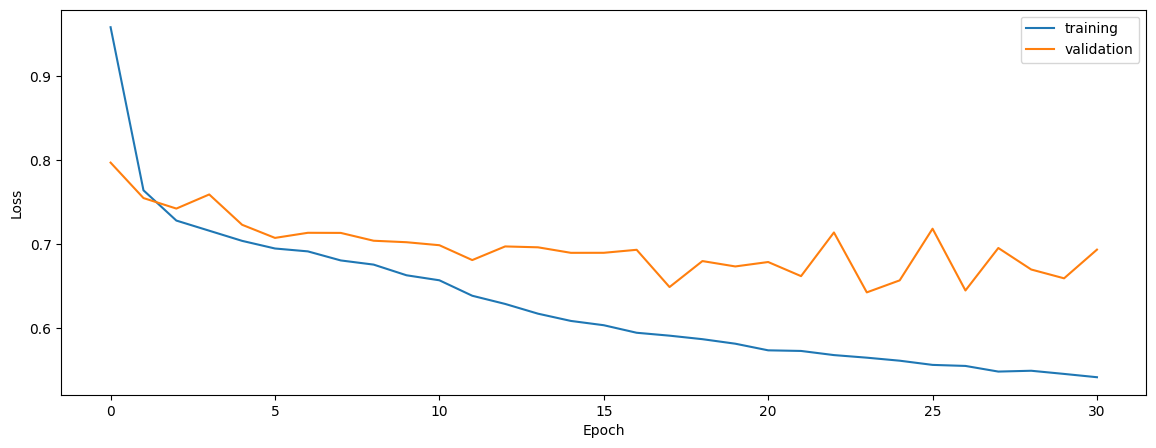

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('train')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

train


0.7575457775939972


0.7221235381064751


0.7376029457108002


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('native')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

native


0.7578126733253169


0.7468171320773871


0.7862946159900005


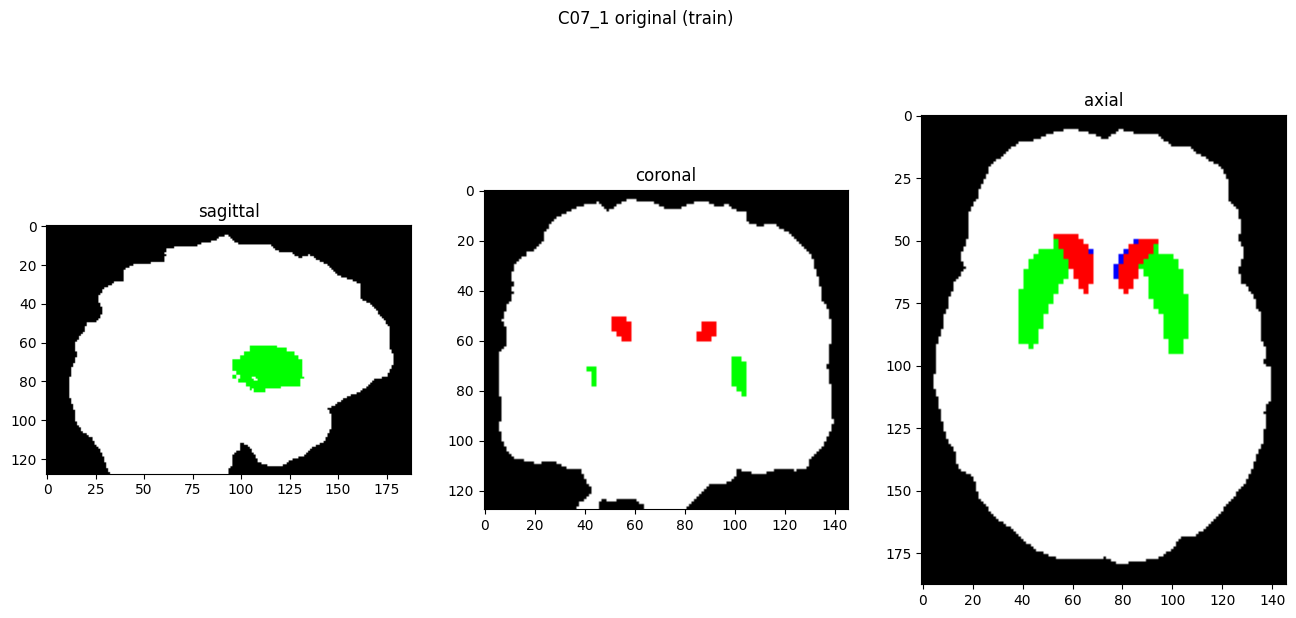

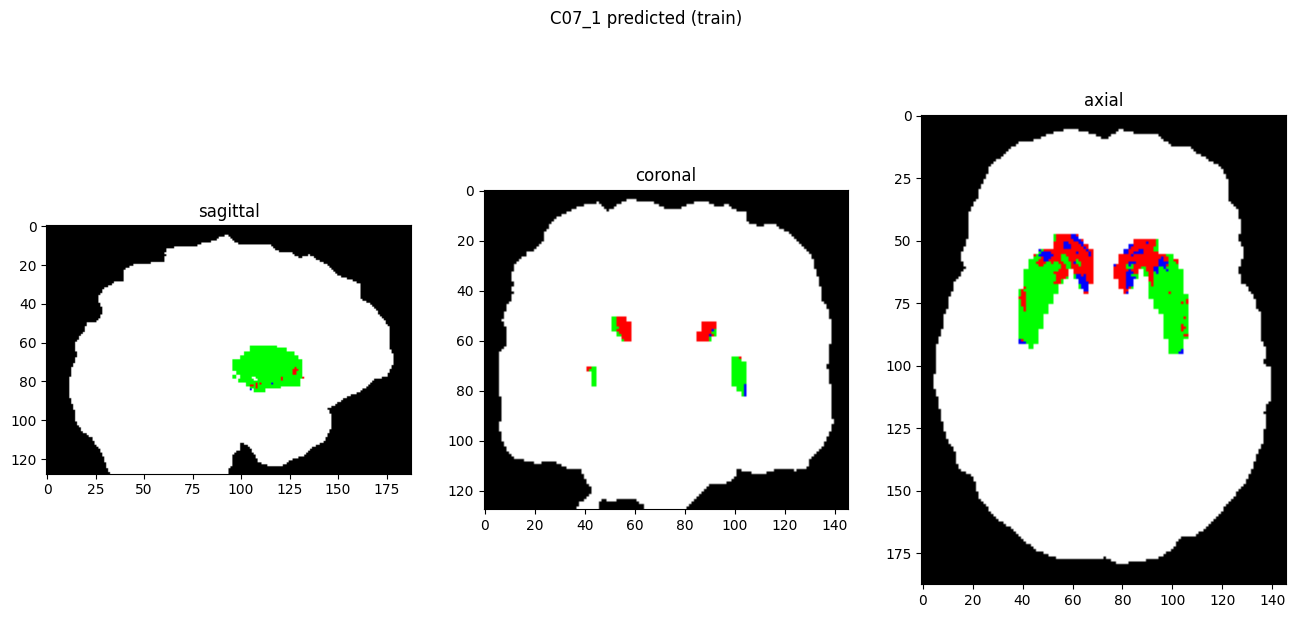

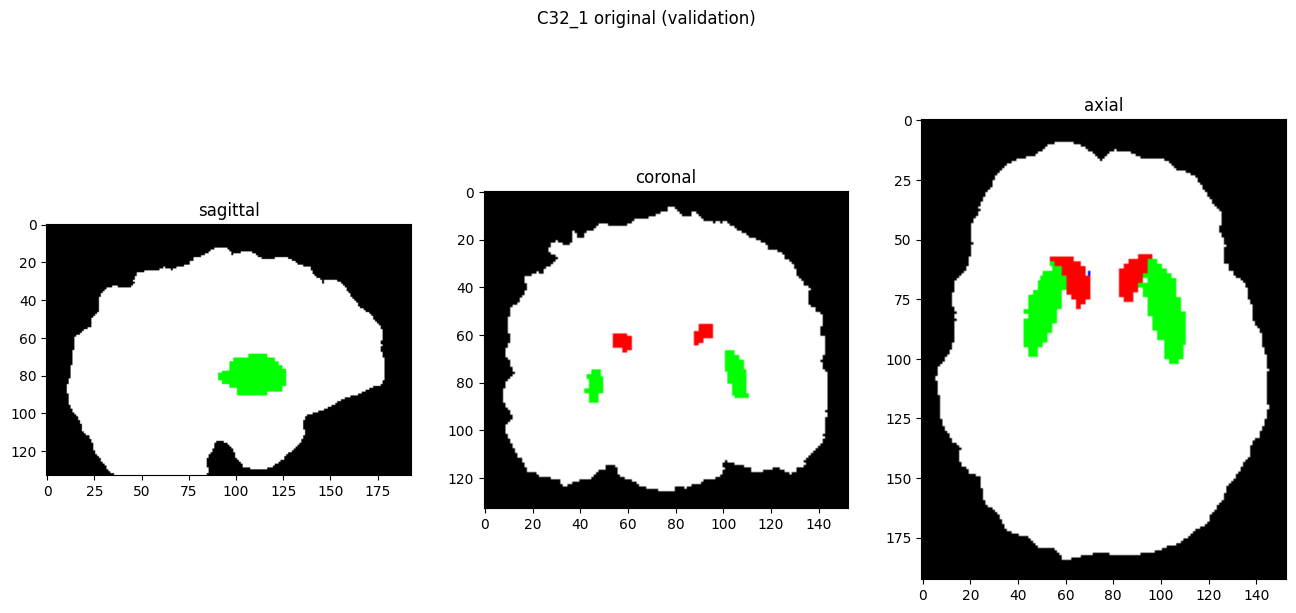

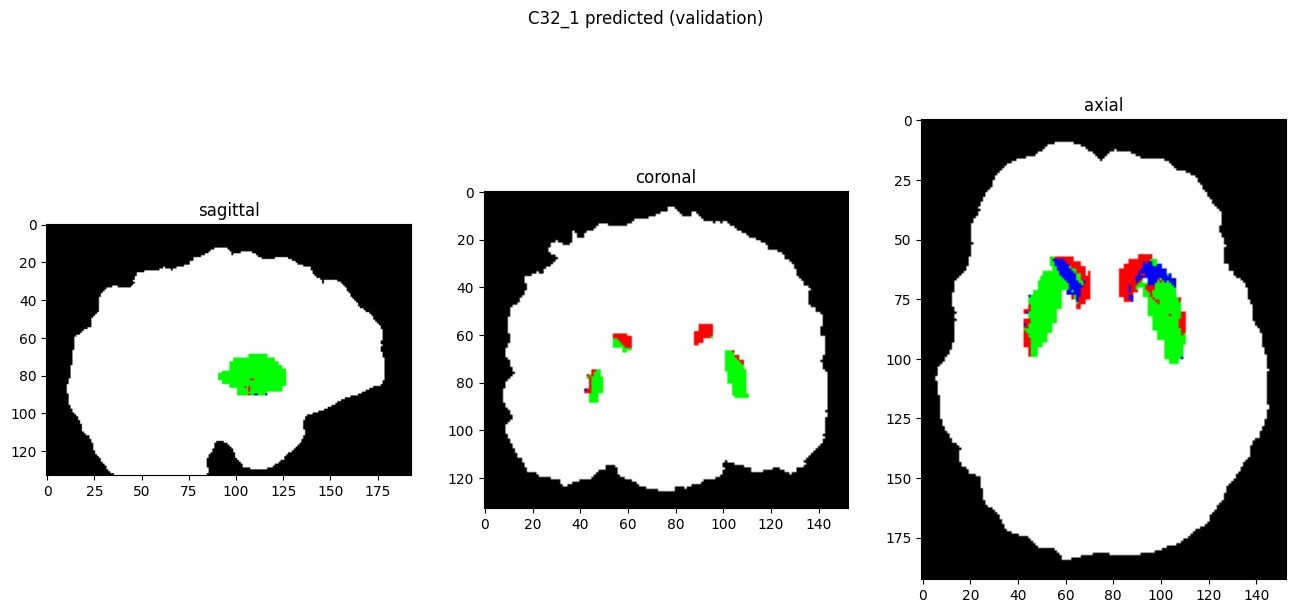

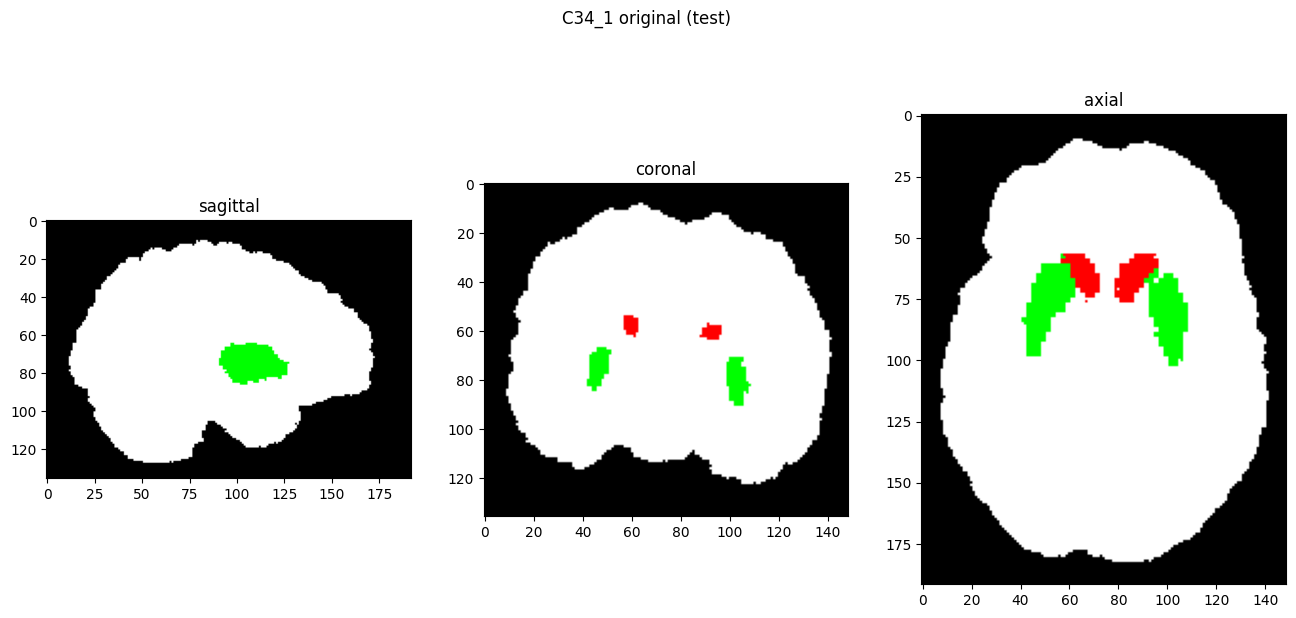

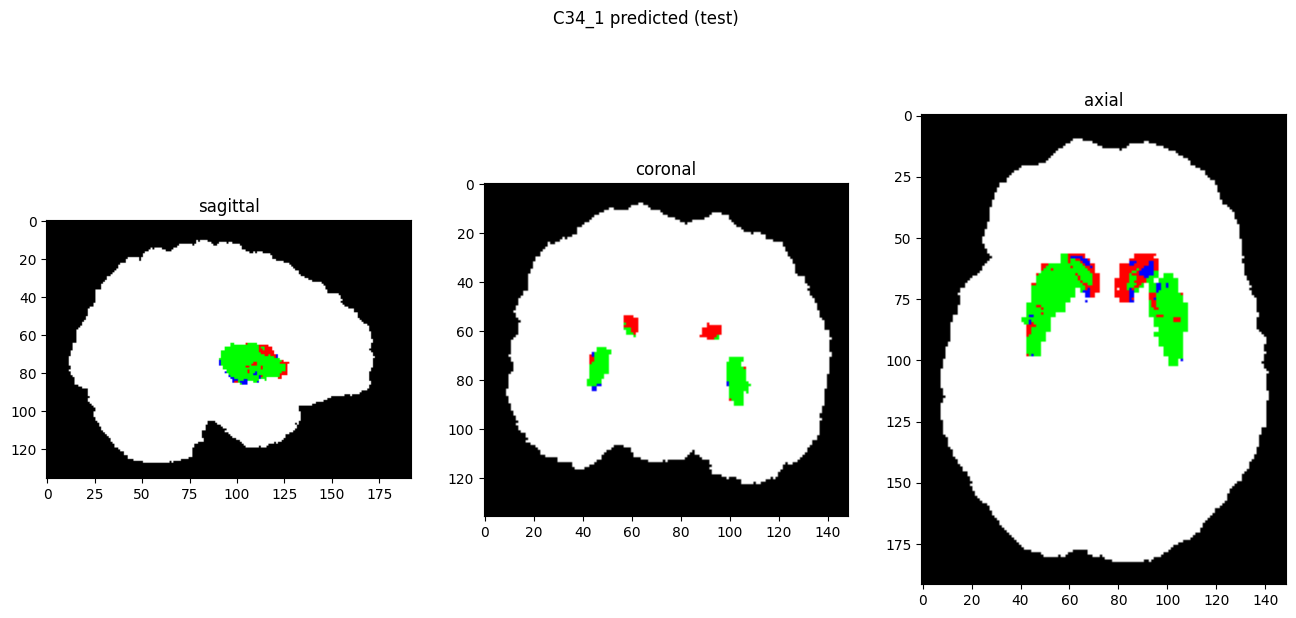

In [9]:
showResults(model, gen, threshold=0)